<a href="https://colab.research.google.com/github/tdehghani/AI-MHE/blob/main/Using_Outcome_Based_Meta_Machine_Learning_Approach_Towards_Predicting_Medical_Student_Status_6_3_1402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import  matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
import scipy
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,RocCurveDisplay,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
address="/content/drive/MyDrive/predict_pre_score_mums/"
number_row=997
data=pd.read_csv(address+"CMPIE_1_3_1402.csv",sep=';',nrows=number_row)
print("check for null",data.isnull().sum())
print(data.columns)
data.info()
col_start=1
col_end=26

print("#######################################")
print(data["CMPIE Status"].value_counts())
data["GPA in Basic Science"].sort_values()
data['Normalized CMPIE MARK Binned'] = pd.qcut(data["Normlized CMPIE MARK "], q=10, duplicates='drop')
print(data["Normalized CMPIE MARK Binned"].value_counts())
print (data.info())
print(pd.crosstab(data["CMPIE Status"] ,data["CCA Status"]))
print("CMPIE Status",data["CMPIE Status"].value_counts())
print("CCA Status",data["CCA Status"].value_counts())

from sklearn.preprocessing import MinMaxScaler
# create a scaler object
scaler = MinMaxScaler(feature_range=(-1,1))
print("CCA Score",data["CCA Score"].value_counts())
print("CCA Status",data["CCA Score"].describe())
# fit and transform the "CCA Score" column using the scaler
normalized_data = scaler.fit_transform(data[["CCA Score"]])
# replace the "CCA Score" column with the normalized data
data["CCA Score"] = normalized_data
print("CCA Status",data["CCA Score"].describe())
print("Normlized CMPIE MARK ",data["Normlized CMPIE MARK "].describe())

Mounted at /content/drive
check for null CODE                                0
Gender                              0
Residency Status                    0
Entrance Semester                   0
Type of Admission                   0
Internal Medicine                   0
General Surgery                     0
Pediatrics                          0
Obstetrics and Gynecology           0
Pathology                           0
Infectious Diseases                 0
Neurosurgery                        0
Dermatology                         0
Orthopedic Surgery                  0
Psychiatry                          0
Pharmacology                        0
Radiology                           0
Urology                             0
Ophthalmology                       0
Otorhinolaryngology                 0
Biostatistics and Epidemiology      0
Medical Ethics                      0
GPA in Basic Science                0
GPA in Preclinical                  0
GPA in clinical clerkship           0
Age at En

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 940
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   CODE                            777 non-null    int64   
 1   Gender                          777 non-null    object  
 2   Residency Status                777 non-null    object  
 3   Entrance Semester               777 non-null    object  
 4   Type of Admission               777 non-null    object  
 5   Internal Medicine               777 non-null    object  
 6   General Surgery                 777 non-null    object  
 7   Pediatrics                      777 non-null    object  
 8   Obstetrics and Gynecology       777 non-null    object  
 9   Pathology                       777 non-null    object  
 10  Infectious Diseases             777 non-null    object  
 11  Neurosurgery                    777 non-null    object  
 12  Dermatology           

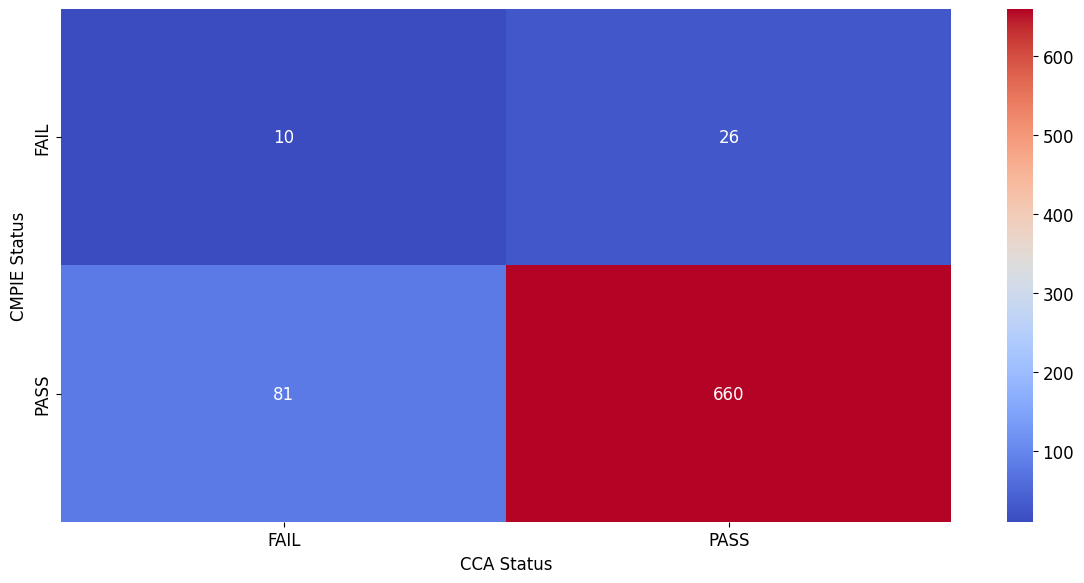

In [ ]:
# create a contingency table of columns 'A' and 'B'
data222=data
data222.dropna(subset=["CCA Status"], inplace=True)
data222.info()
cont_table = pd.crosstab(data222["CCA Status"], data222["CMPIE Status"])

# create a heatmap of the contingency table with formatted annotations
sns.heatmap(cont_table, annot=True,  fmt='.0f',cmap='coolwarm')



# add labels and a title to the plot
plt.xlabel('CCA Status')
plt.ylabel('CMPIE Status')

# display the plot
plt.show()

data statistic

---



In [ ]:
import catboost as cb
import pandas as pd
import shap

# Split the dataset into features and target
X = data.iloc[:, 6:21]
y = data["CMPIE Status"]

# Create an empty dictionary to store the categorical features
cat_features = {}

# Loop through the columns in the DataFrame
for col in X.columns:
    # Check if the column is categorical
    if X[col].dtype == 'object':
        # Store the unique values in the dictionary
        cat_features[col] = list(X[col].unique())


# Define the hyperparameters to search over
param_grid = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5]
}

# Train a CatBoost classifier on the data
model = cb.CatBoostClassifier(random_seed=42)

# Set the feature names for the model
model.set_feature_names(list(X.columns))

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(model, param_grid,cv=5)

# Fit the grid search to the data
grid_search.fit(X, y, cat_features=list(cat_features.keys()))

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Train a new CatBoost classifier using the best hyperparameters
best_model = cb.CatBoostClassifier(iterations=grid_search.best_params_['iterations'],
                                    learning_rate=grid_search.best_params_['learning_rate'],
                                    depth=grid_search.best_params_['depth'],
                                    l2_leaf_reg=grid_search.best_params_['l2_leaf_reg'],
                                    random_seed=42)

# Set the feature names for the model
best_model.set_feature_names(list(X.columns))

Streaming output truncated to the last 5000 lines.
201:	learn: 0.0369771	total: 6.42s	remaining: 3.11s
202:	learn: 0.0369544	total: 6.45s	remaining: 3.08s
203:	learn: 0.0364509	total: 6.5s	remaining: 3.06s
204:	learn: 0.0361169	total: 6.53s	remaining: 3.03s
205:	learn: 0.0359811	total: 6.56s	remaining: 3s
206:	learn: 0.0352143	total: 6.6s	remaining: 2.96s
207:	learn: 0.0351892	total: 6.63s	remaining: 2.93s
208:	learn: 0.0350918	total: 6.66s	remaining: 2.9s
209:	learn: 0.0348203	total: 6.72s	remaining: 2.88s
210:	learn: 0.0346604	total: 6.75s	remaining: 2.85s
211:	learn: 0.0345229	total: 6.79s	remaining: 2.82s
212:	learn: 0.0343623	total: 6.82s	remaining: 2.78s
213:	learn: 0.0339492	total: 6.85s	remaining: 2.75s
214:	learn: 0.0339490	total: 6.88s	remaining: 2.72s
215:	learn: 0.0337474	total: 6.92s	remaining: 2.69s
216:	learn: 0.0335463	total: 6.96s	remaining: 2.66s
217:	learn: 0.0333755	total: 7s	remaining: 2.63s
218:	learn: 0.0330439	total: 7.03s	remaining: 2.6s
219:	learn: 0.0327405	t

0:	learn: 0.6340015	total: 8.2ms	remaining: 811ms
1:	learn: 0.5853792	total: 11.4ms	remaining: 559ms
2:	learn: 0.5452944	total: 12.8ms	remaining: 413ms
3:	learn: 0.5117119	total: 14.5ms	remaining: 349ms
4:	learn: 0.4836428	total: 15.7ms	remaining: 299ms
5:	learn: 0.4599971	total: 16.6ms	remaining: 260ms
6:	learn: 0.4400889	total: 17.9ms	remaining: 238ms
7:	learn: 0.4231920	total: 19.3ms	remaining: 222ms
8:	learn: 0.4088861	total: 19.8ms	remaining: 200ms
9:	learn: 0.3967911	total: 20.6ms	remaining: 186ms
10:	learn: 0.3865673	total: 22.3ms	remaining: 181ms
11:	learn: 0.3778892	total: 23.8ms	remaining: 174ms
12:	learn: 0.3705089	total: 25.1ms	remaining: 168ms
13:	learn: 0.3622076	total: 26.7ms	remaining: 164ms
14:	learn: 0.3548514	total: 30.9ms	remaining: 175ms
15:	learn: 0.3489784	total: 32.2ms	remaining: 169ms
16:	learn: 0.3434890	total: 33.8ms	remaining: 165ms
17:	learn: 0.3384240	total: 37.9ms	remaining: 173ms
18:	learn: 0.3346188	total: 42.3ms	remaining: 180ms
19:	learn: 0.3301707	to

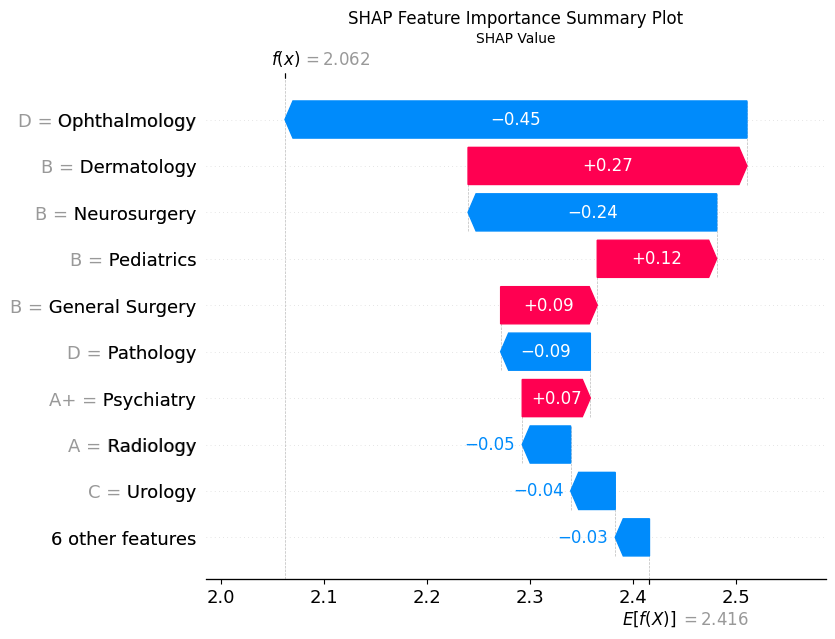

In [ ]:

# Fit the model to the data
best_model.fit(X, y, cat_features=list(cat_features.keys()))


# Calculate the SHAP values for the dataset using the CatBoost method
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

# Configure the appearance of the summary plot
shap.waterfall_plot(shap_values[0],                    show=False)

# Configure the appearance of the summary plot
#shap.summary_plot(shap_values,    X,                  plot_type="bar",                   color="dodgerblue",                   alpha=0.7,                  sort=True,                  show=False)

# Add a title to the plot
plt.title("SHAP Feature Importance Summary Plot")

# Add axis labels
plt.xlabel("SHAP Value")
plt.ylabel("Feature")

# Show the plot
plt.show()


plt.savefig(address+"Shap.png", dpi=300, bbox_inches="tight")







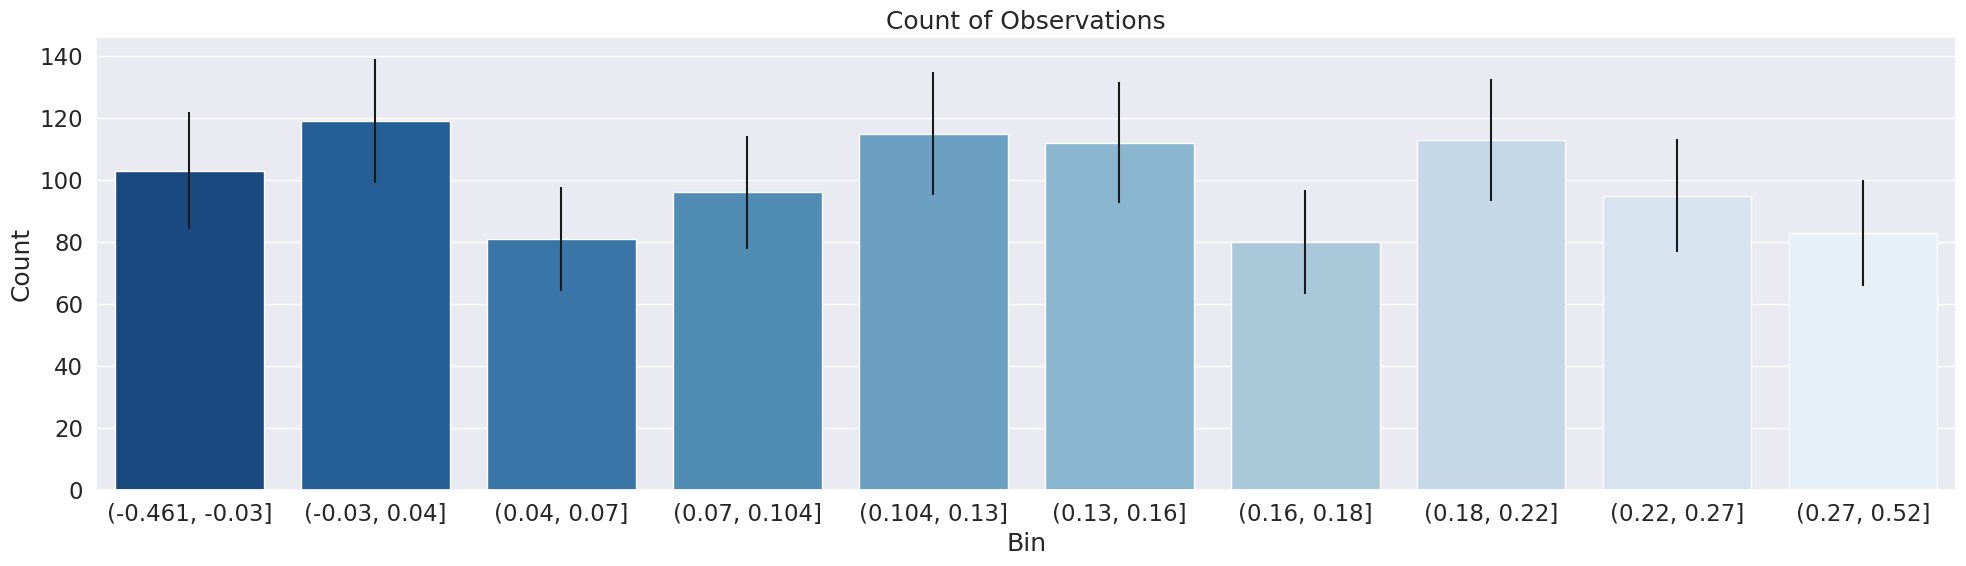

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import seaborn as sns
import seaborn as sns
sns.set(font_scale=1.5)
custom_palette = sns.color_palette(["#006699", "#66CCFF", "#99CCFF", "#003366", "#336699"])
sns.set_palette(custom_palette)
plt.rcParams["figure.figsize"] = [20.00, 10]


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the count of observations in each bin.
bin_counts = data['Normalized CMPIE MARK Binned'].value_counts().sort_index()

# Compute the 95% CI of the counts using the binomial distribution.
ci = 1.96 * np.sqrt(bin_counts * (1 - bin_counts / len(data)))

# Create a custom color palette with a blue to white gradient.
colors = sns.color_palette("Blues", len(bin_counts))
colors = colors[::-1]

# Set the figure size.
plt.figure(figsize=(20, 6))

# Create a bar plot of the binned data with the custom color palette.
ax = sns.barplot(x=bin_counts.index, y=bin_counts, capsize=0.1, errwidth=1.5, yerr=ci, palette=colors)

# Set the axis labels and title.
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title('Count of Observations')

# Show the plot.
plt.show()

plt.savefig(address+"Normalized CMPIE MARK_distribution.png", dpi=300, bbox_inches="tight")


0      20-30%
1      10-20%
2      30-40%
3      60-70%
4      10-20%
        ...  
992    50-60%
993    10-20%
994    60-70%
995     0-10%
996    40-50%
Name: Normalized CMPIE MARK Binned, Length: 997, dtype: category
Categories (10, object): ['0-10%' < '10-20%' < '20-30%' < '30-40%' ... '60-70%' < '70-80%' < '80-90%' <
                          '90-100%']


<Figure size 640x480 with 0 Axes>

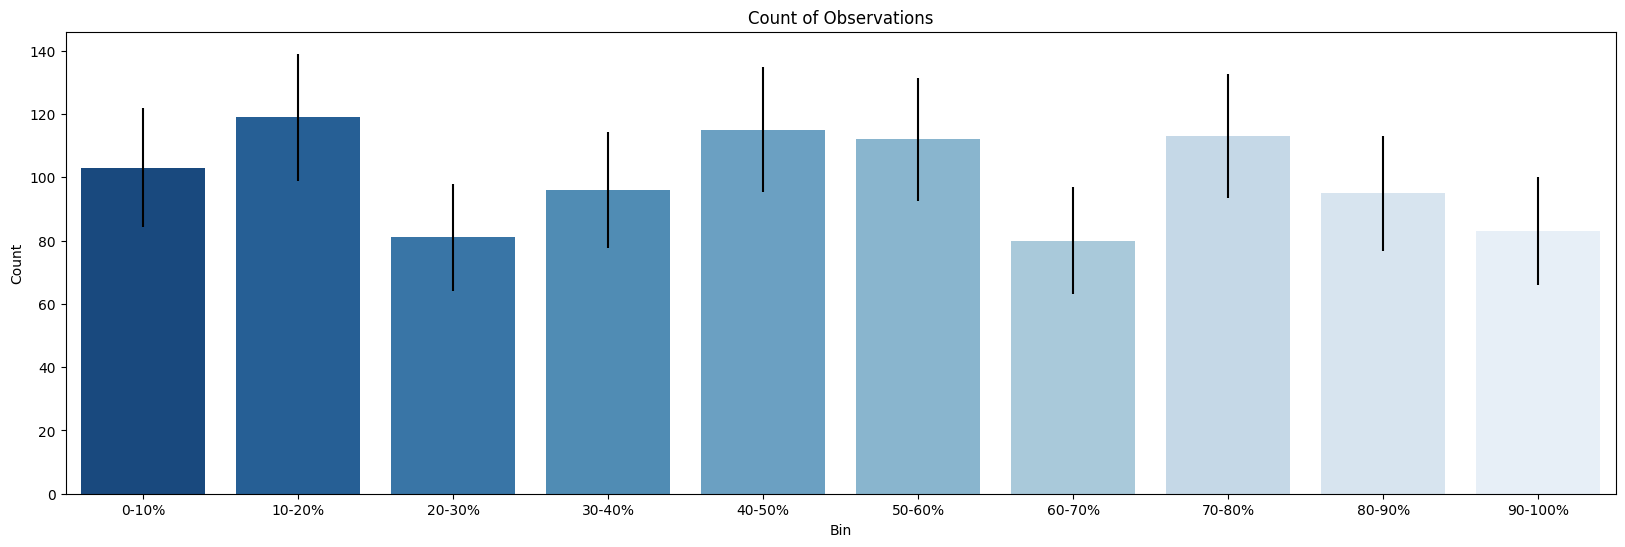

In [ ]:
# Define custom bin labels.
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Use qcut to bin the data into 10 bins with approximately equal counts and add custom labels for each bin.
data['Normalized CMPIE MARK Binned'] = pd.qcut(data["Normlized CMPIE MARK "], q=10, duplicates='drop', labels=labels)
print(data['Normalized CMPIE MARK Binned'])
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your continuous feature is in a column called "Normalized CMPIE MARK"
# and your custom bin labels are in a column called "Normalized CMPIE MARK Binned"
# You can change the column names to match your data.

# Create a histogram with custom bin labels.
#sns.displot(data=data, x="Normalized CMPIE MARK Binned", kde=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the count of observations in each bin.
bin_counts = data['Normalized CMPIE MARK Binned'].value_counts().sort_index()

# Compute the 95% CI of the counts using the binomial distribution.
ci = 1.96 * np.sqrt(bin_counts * (1 - bin_counts / len(data)))

# Create a custom color palette with a blue to white gradient.
colors = sns.color_palette("Blues", len(bin_counts))
colors = colors[::-1]

# Set the figure size.
plt.figure(figsize=(20, 6))

# Create a bar plot of the binned data with the custom color palette.
ax = sns.barplot(x=bin_counts.index, y=bin_counts, capsize=0.1, errwidth=1.5, yerr=ci, palette=colors)

# Set the axis labels and title.
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title('Count of Observations')

# Show the plot.
plt.show()

plt.savefig(address+"Normalized CMPIE MARK_distribution2.png", dpi=300, bbox_inches="tight")

In [ ]:
categorical_features = ['Gender', 'Residency Status', 'Entrance Semester', 'Type of Admission', 'Internal Medicine', 'General Surgery', 'Pediatrics', 'Obstetrics and Gynecology', 'Pathology', 'Infectious Diseases', 'Neurosurgery', 'Dermatology', 'Orthopedic Surgery', 'Psychiatry', 'Pharmacology', 'Radiology', 'Urology', 'Ophthalmology', 'Otorhinolaryngology', 'Biostatistics and Epidemiology', 'Medical Ethics', 'GPA in Basic Science', 'GPA in Preclinical', 'GPA in clinical clerkship', 'Age at Entrance', 'Age at CMPIE', 'CMPIE Status', 'CCA Status', 'CMBSE Status ', 'Normalized CMPIE MARK Binned']

for feature in categorical_features:
    category_counts = data.groupby(['Normalized CMPIE MARK Binned', feature])[feature].count().unstack()
    category_counts = category_counts.fillna(0)
    print(f"Category counts for feature {feature}:")
    print(category_counts)

def plot_cluster_distributions(data, feature):
    category_counts = data.groupby(['Normalized CMPIE MARK Binned', feature])[feature].count().unstack()
    category_counts = category_counts.fillna(0)
    category_counts.plot(kind='bar', stacked=True)
    plt.title(f"{feature} Distribution per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.legend(title=feature)
    plt.show()

# Plot the categorical feature distributions for each cluster
for feature in categorical_features:
    plot_cluster_distributions(data, feature)

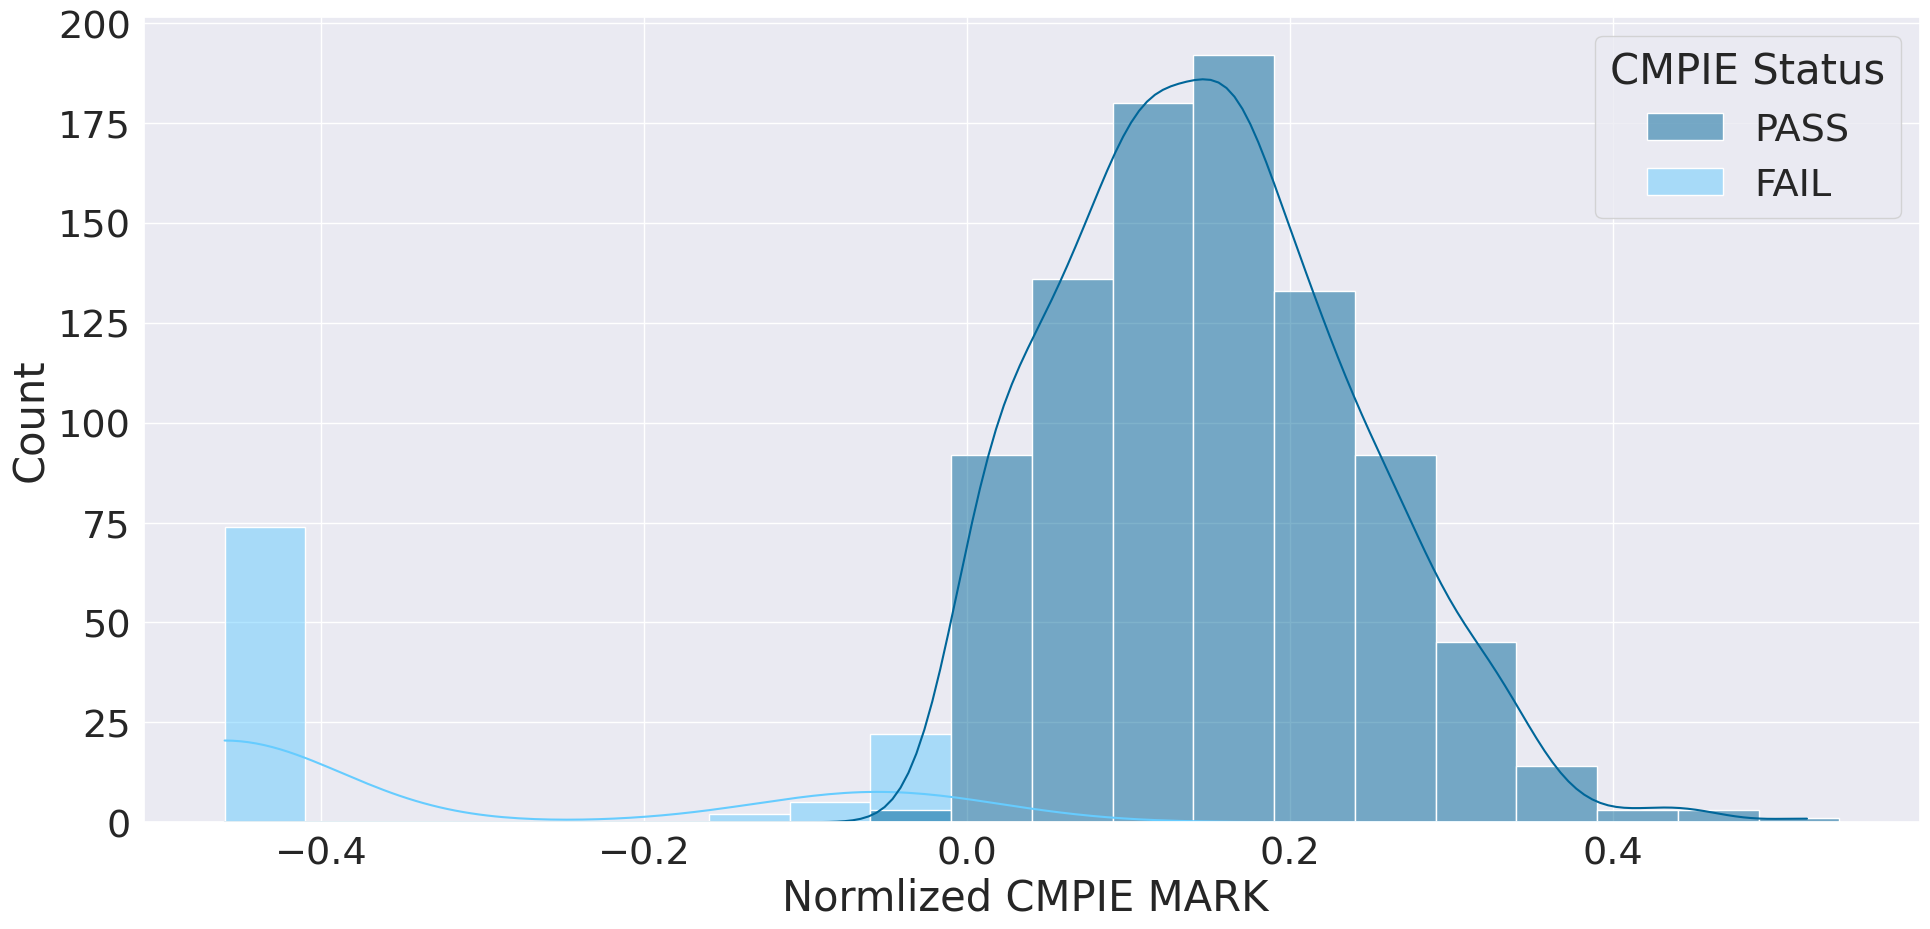

In [ ]:
import seaborn as sns
import seaborn as sns
sns.set(font_scale=2.5)
custom_palette = sns.color_palette(["#006699", "#66CCFF", "#99CCFF", "#003366", "#336699"])
sns.set_palette(custom_palette)
plt.rcParams["figure.figsize"] = [20.00, 10]
plt.rcParams["figure.autolayout"] = True
sns.histplot(data=data,  x="Normlized CMPIE MARK ", hue="CMPIE Status", binwidth=0.05, kde=True)
plt.savefig(address+"histogram.png", dpi=300, bbox_inches="tight")

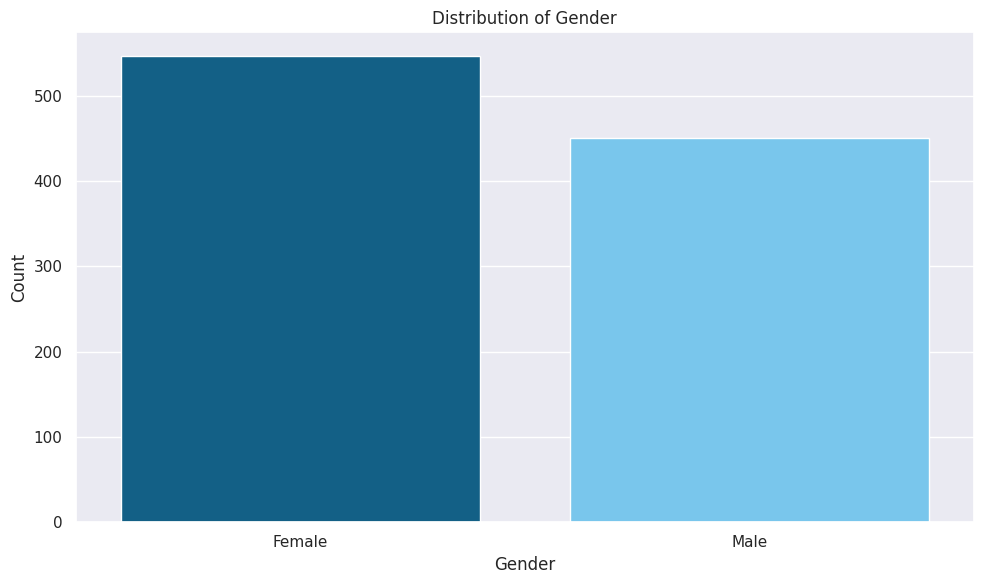

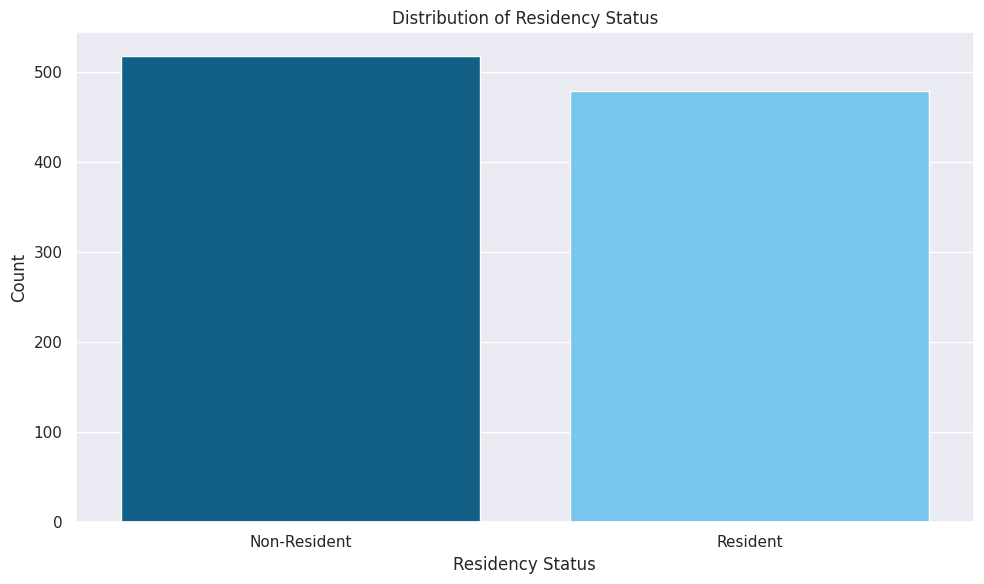

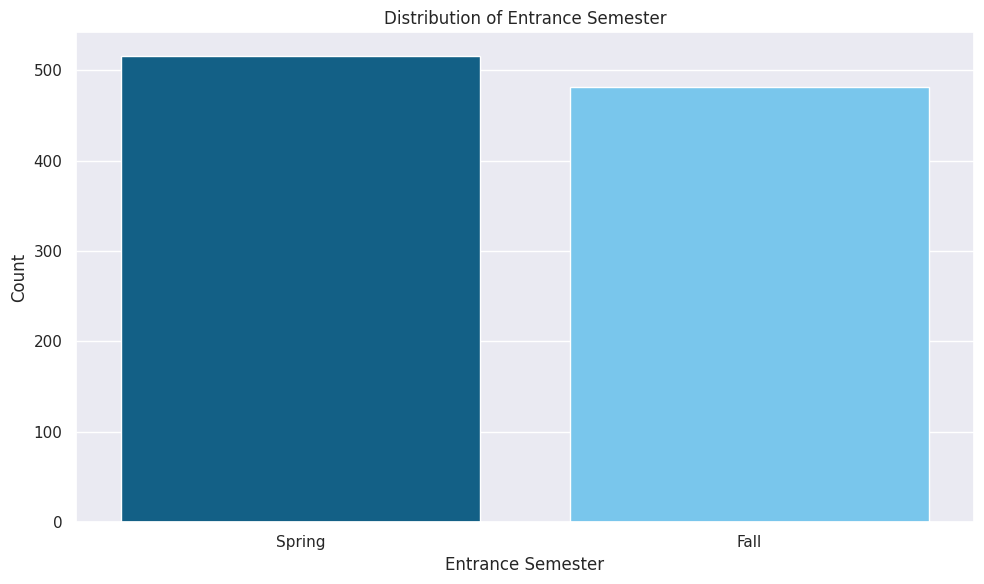

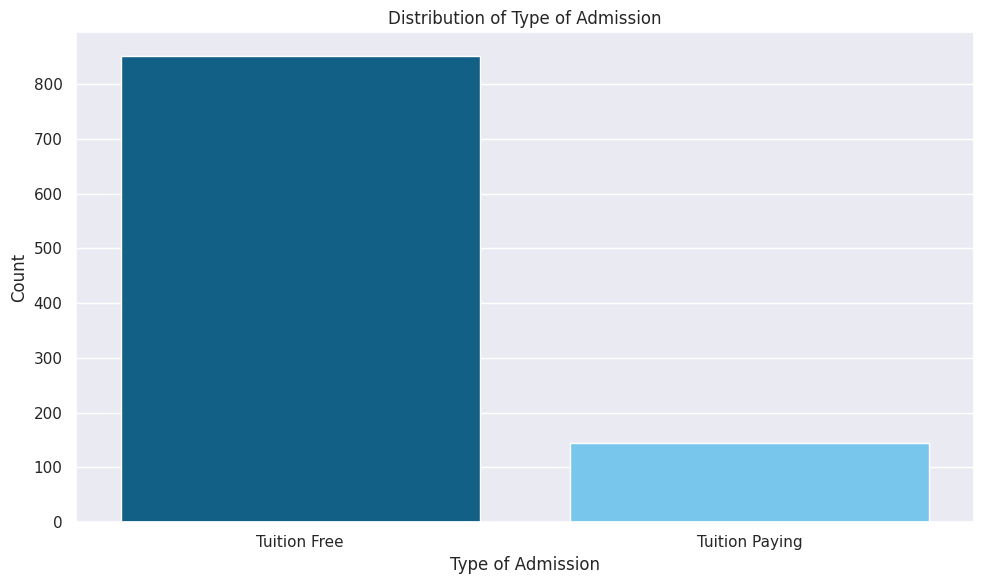

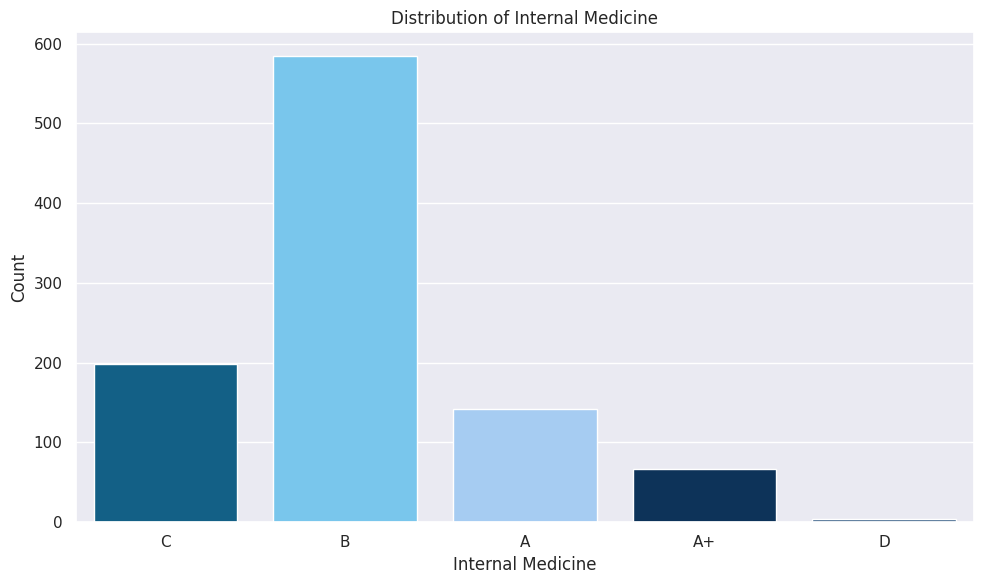

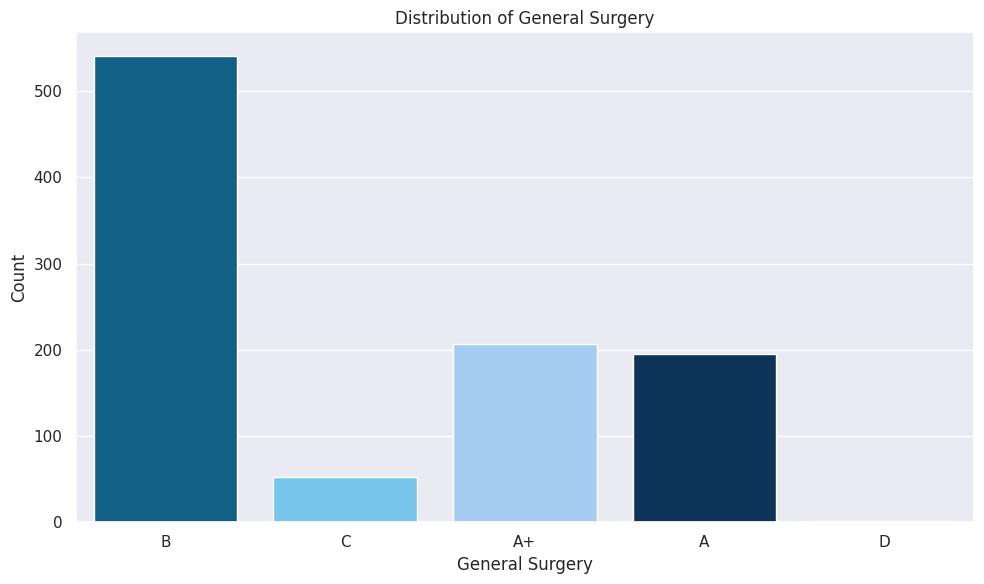

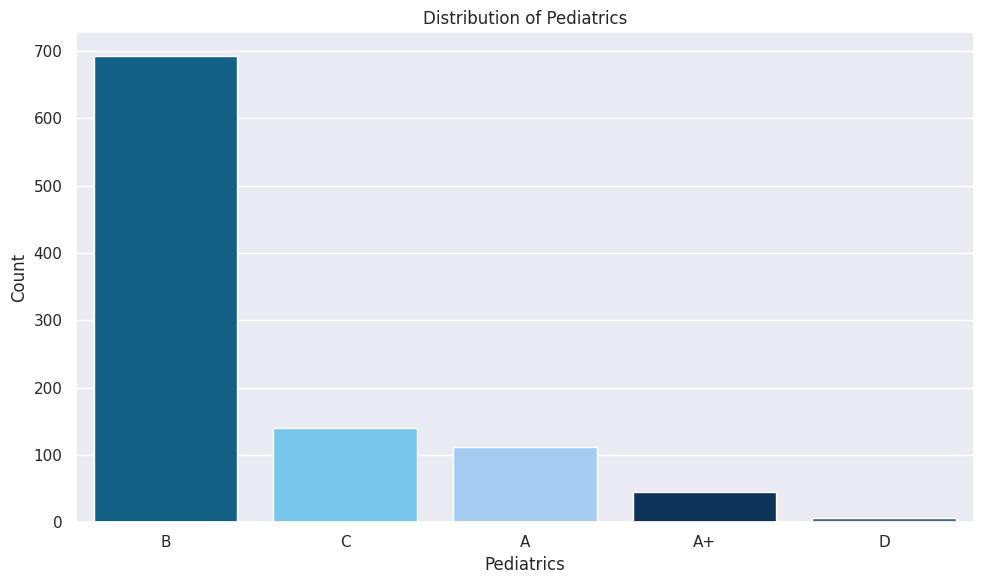

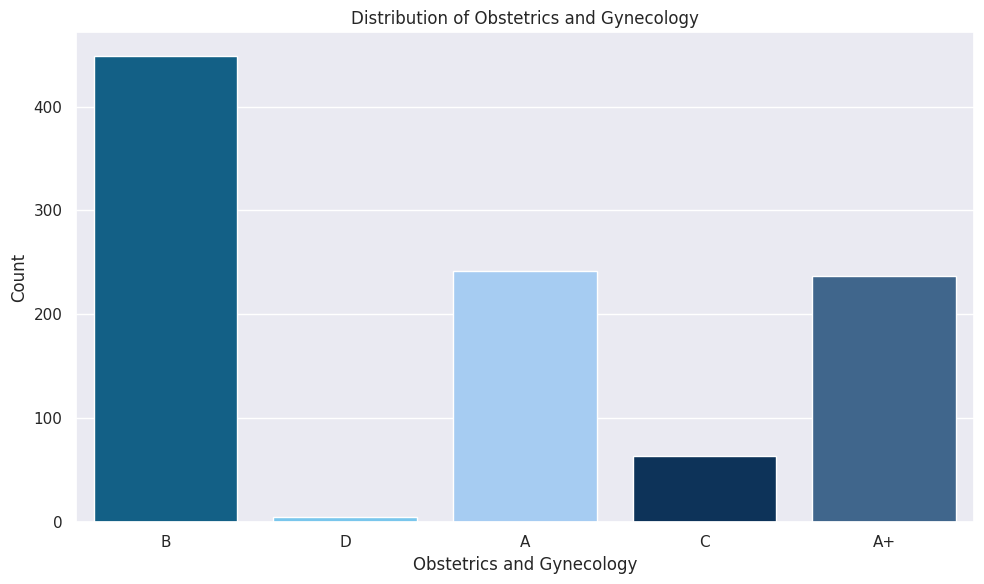

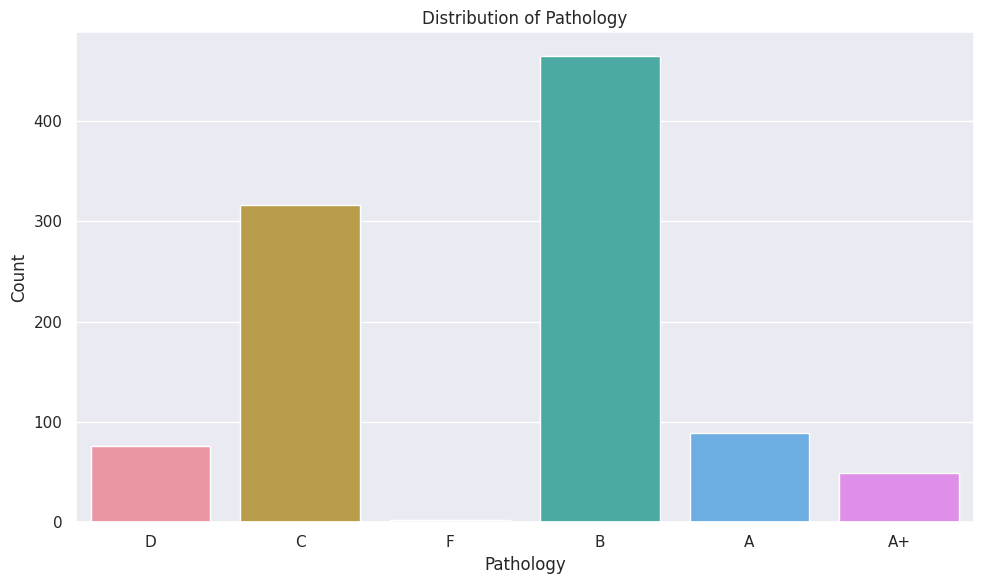

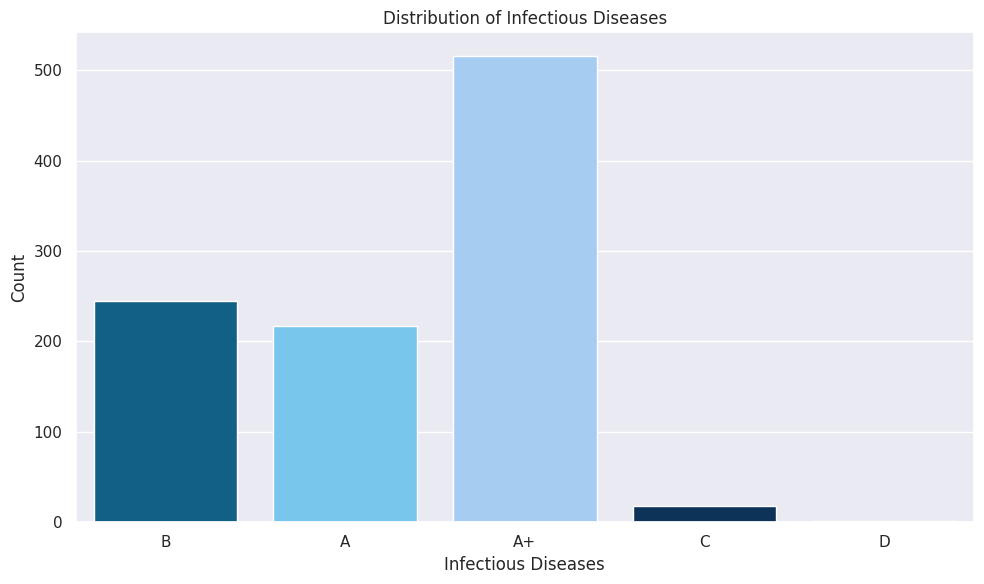

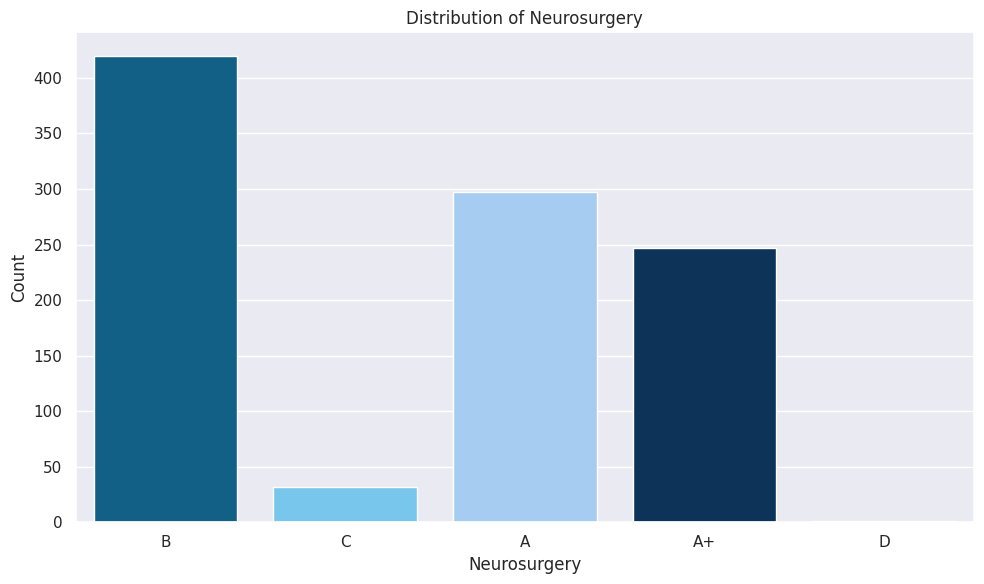

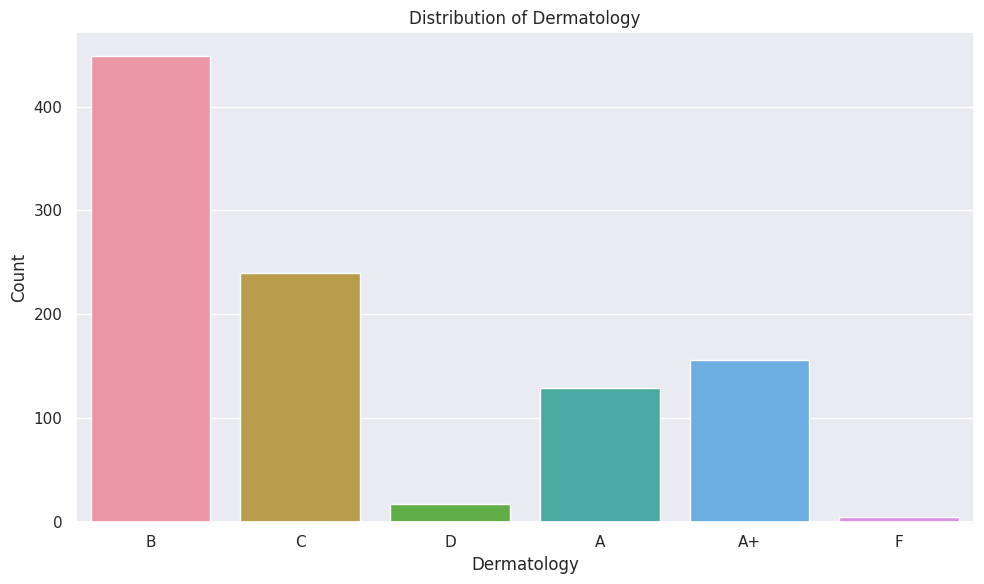

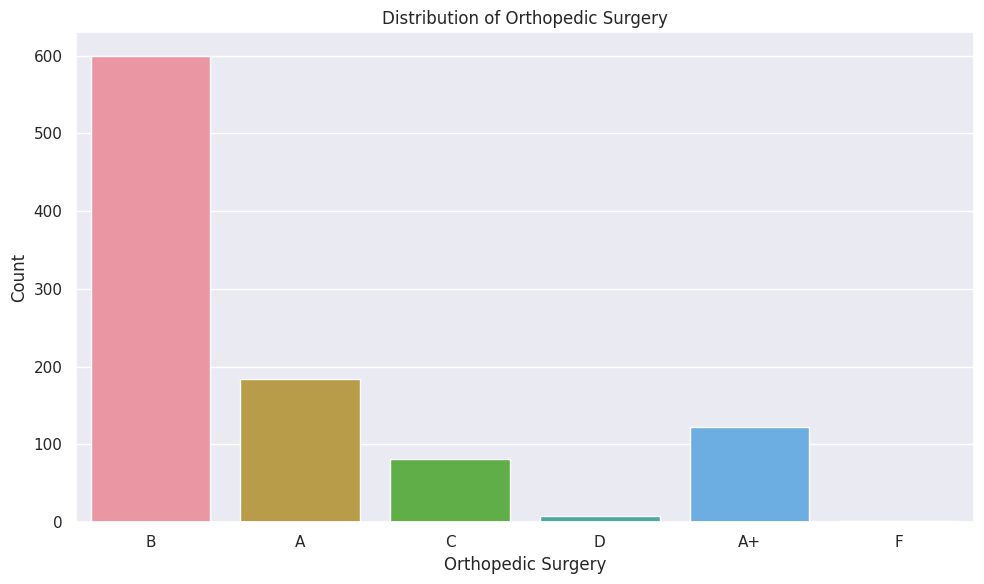

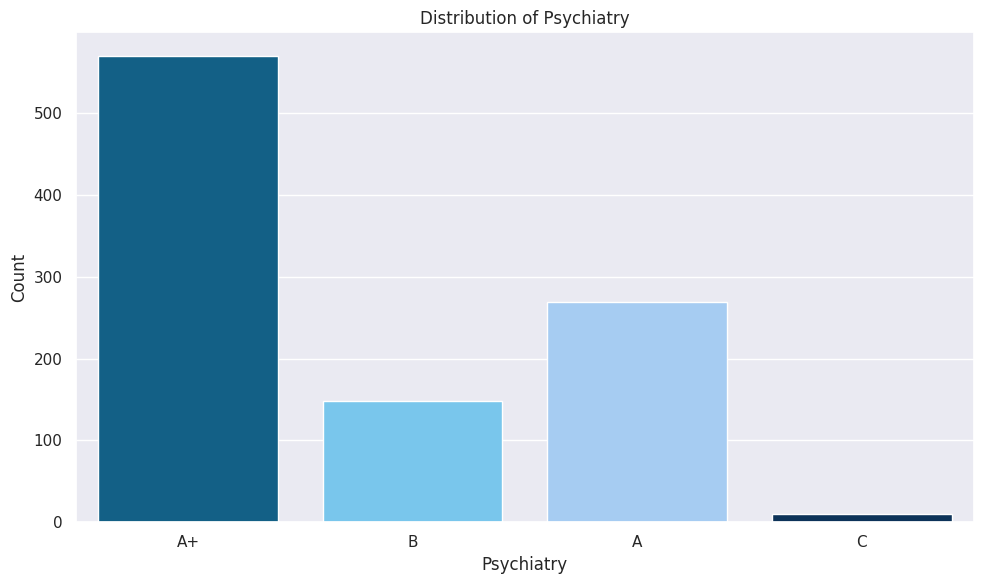

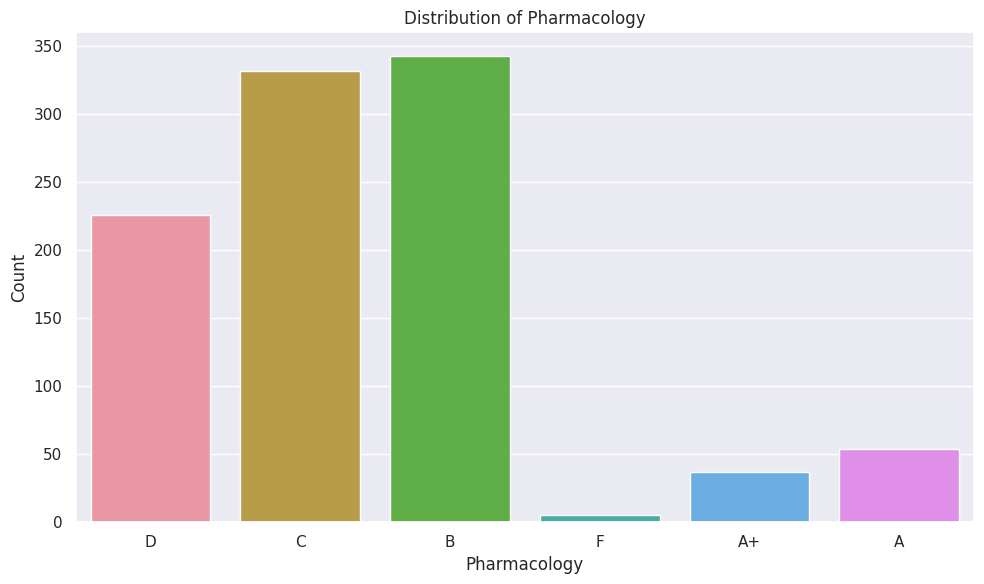

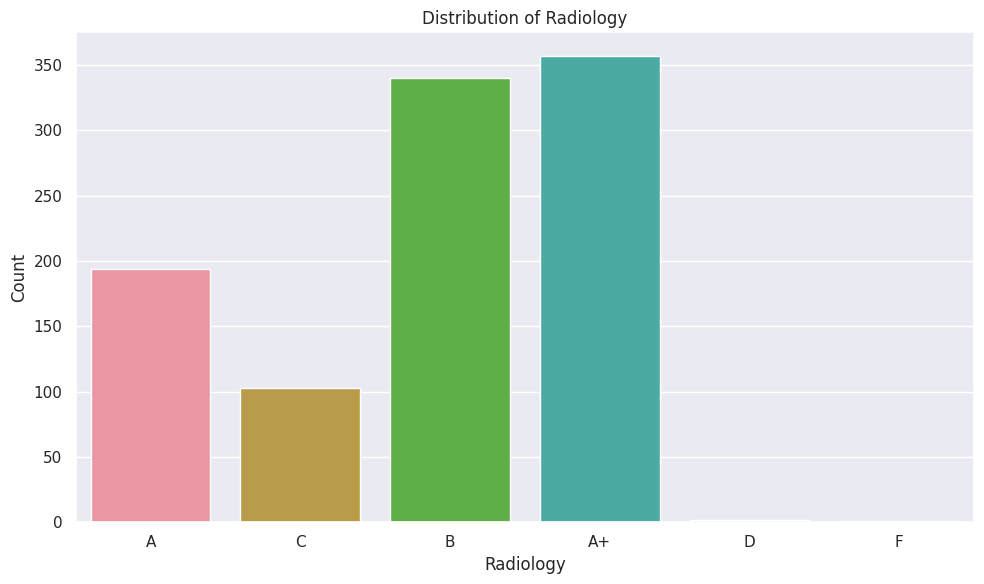

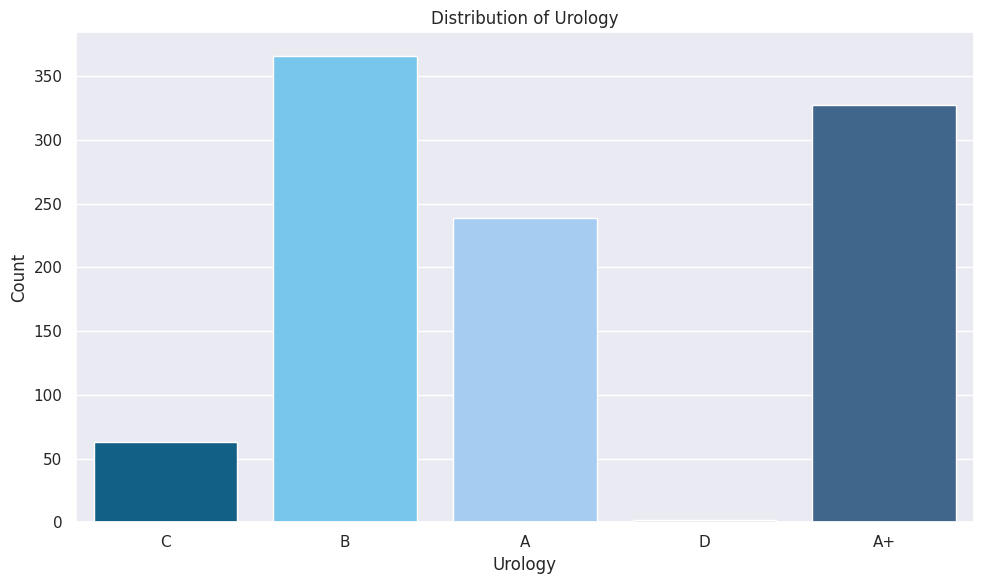

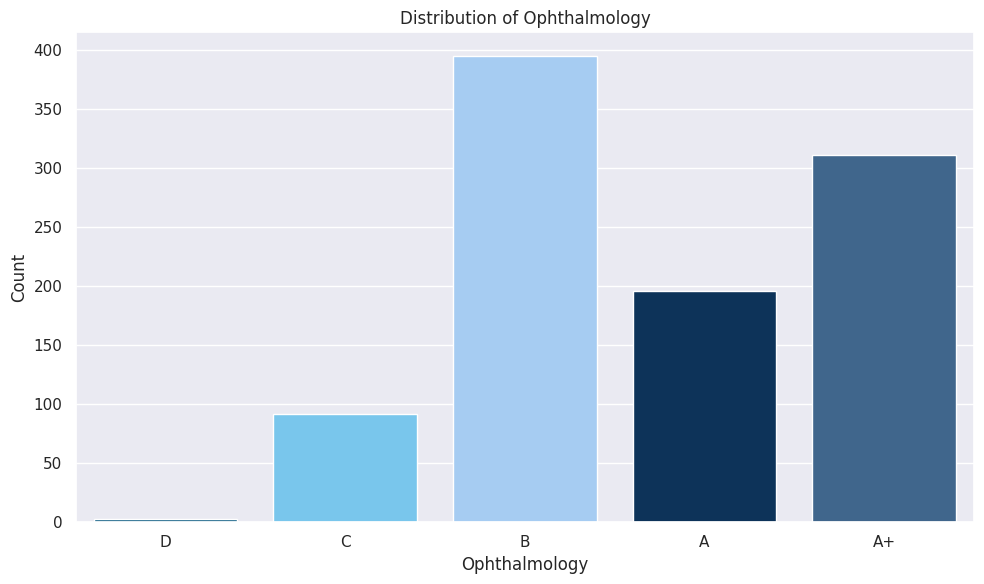

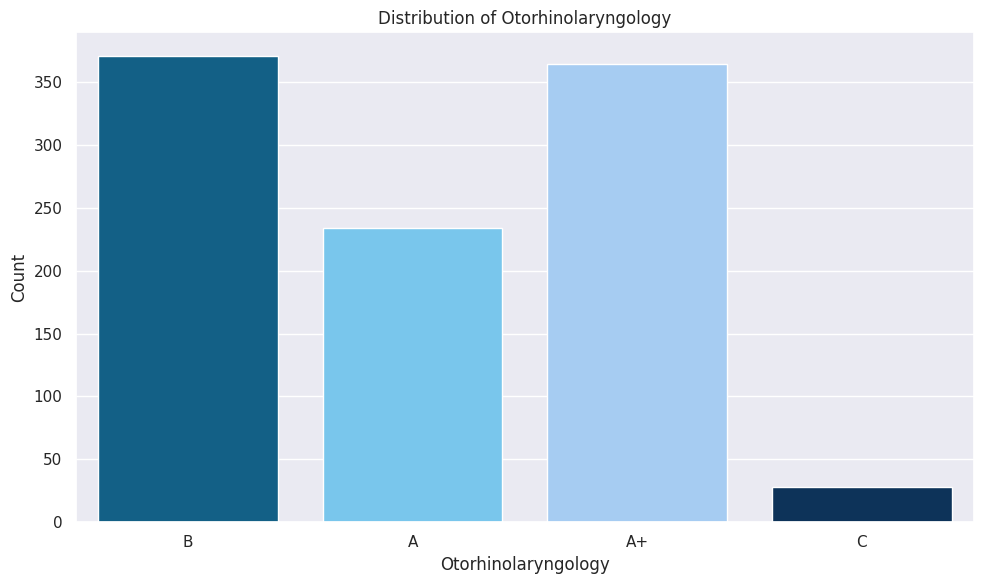

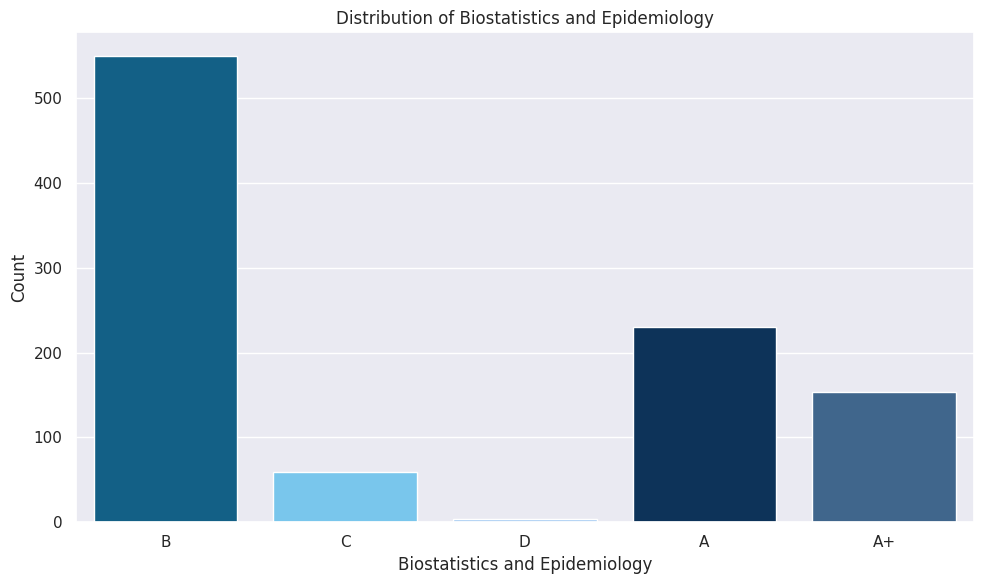

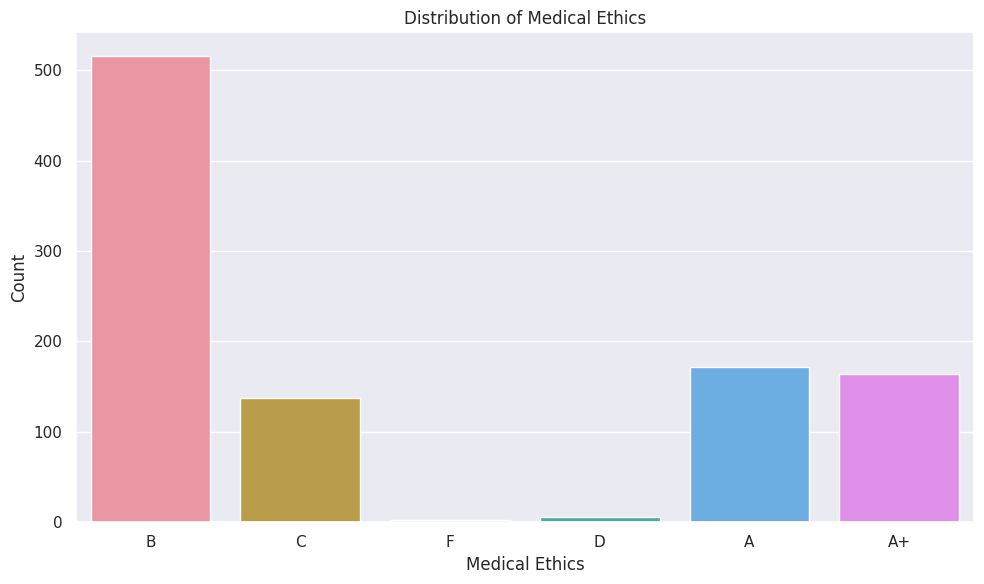

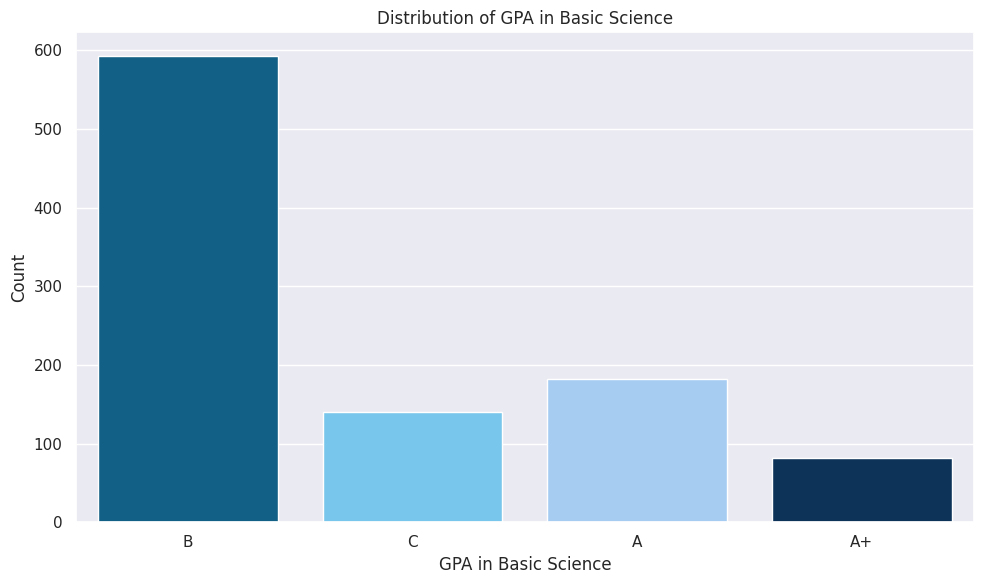

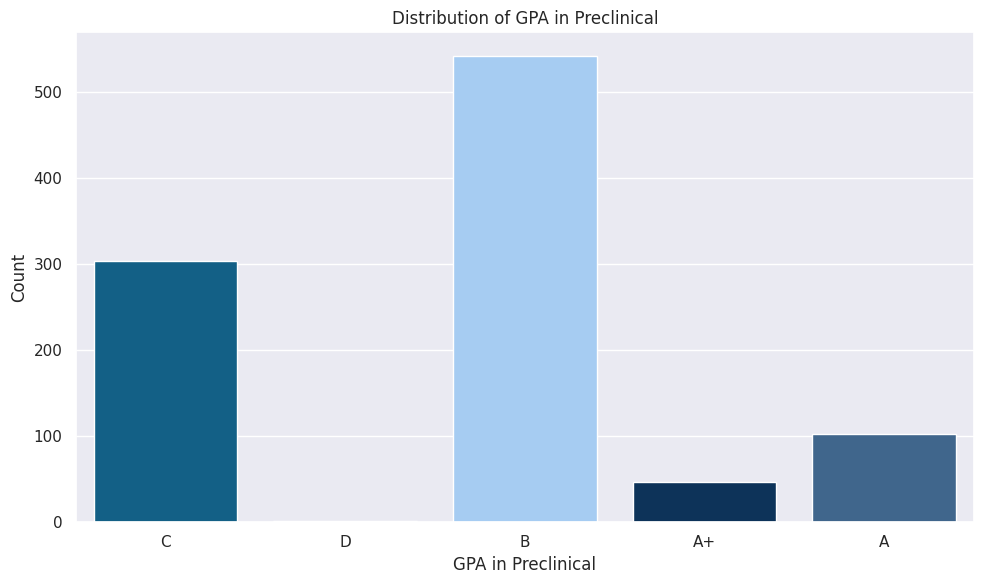

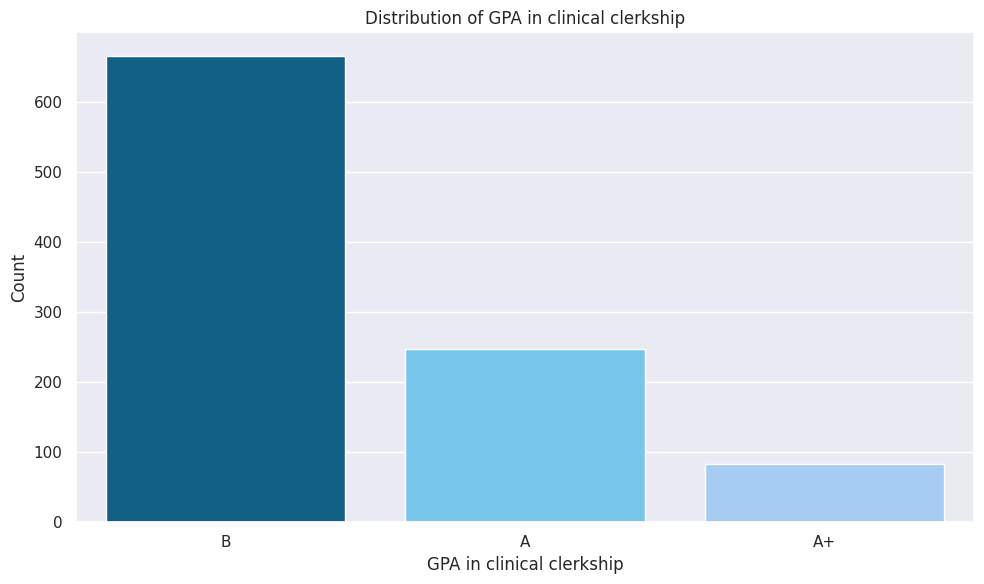

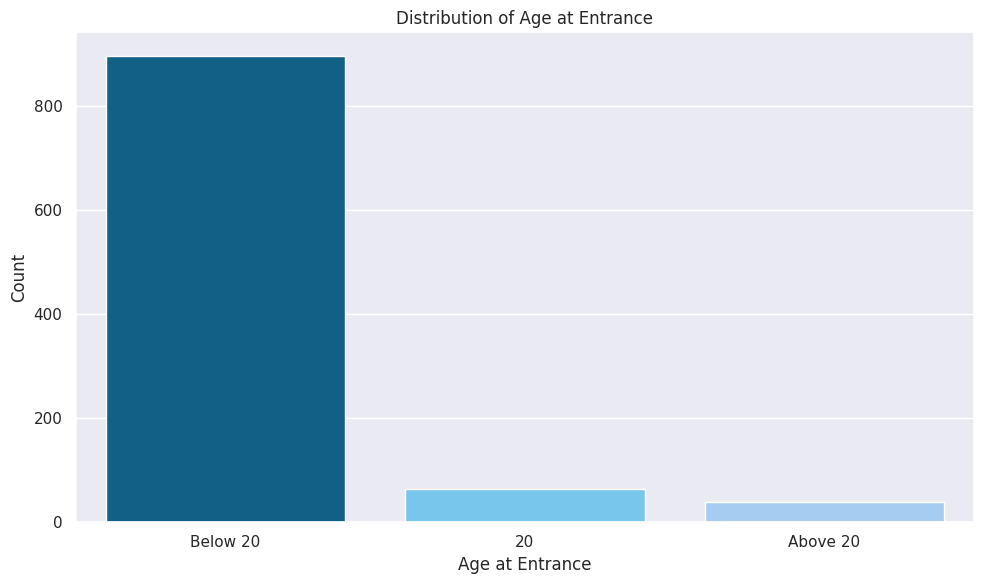

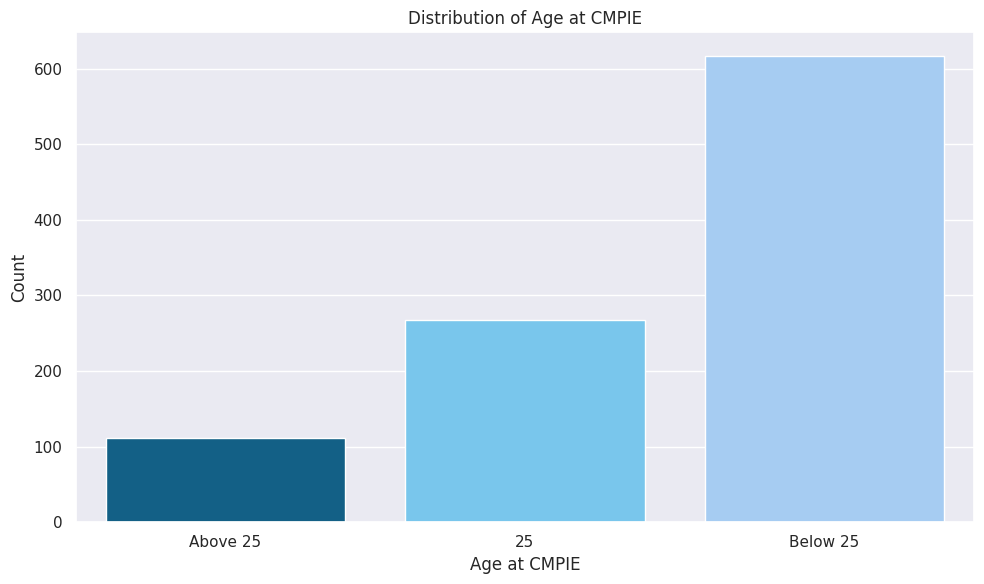

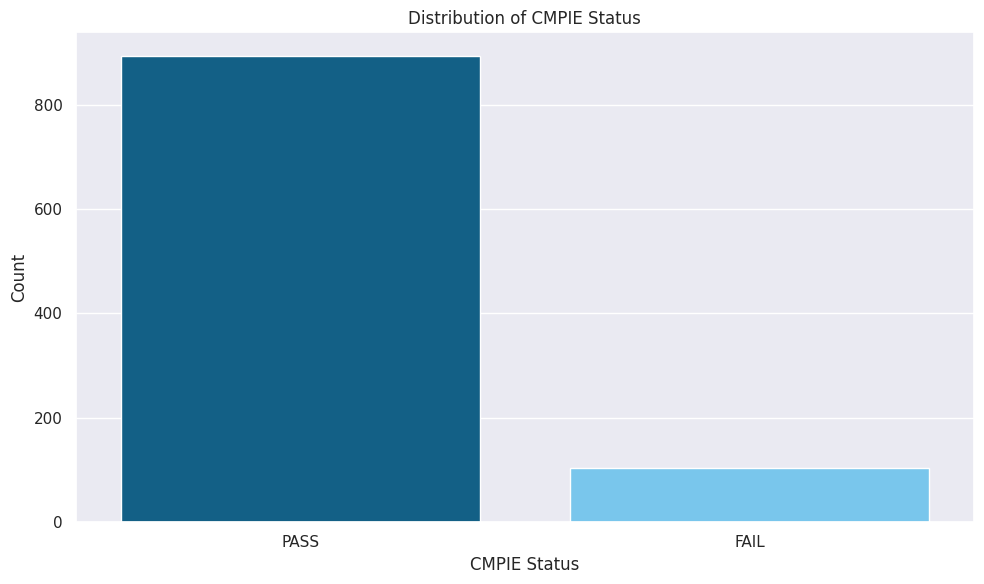

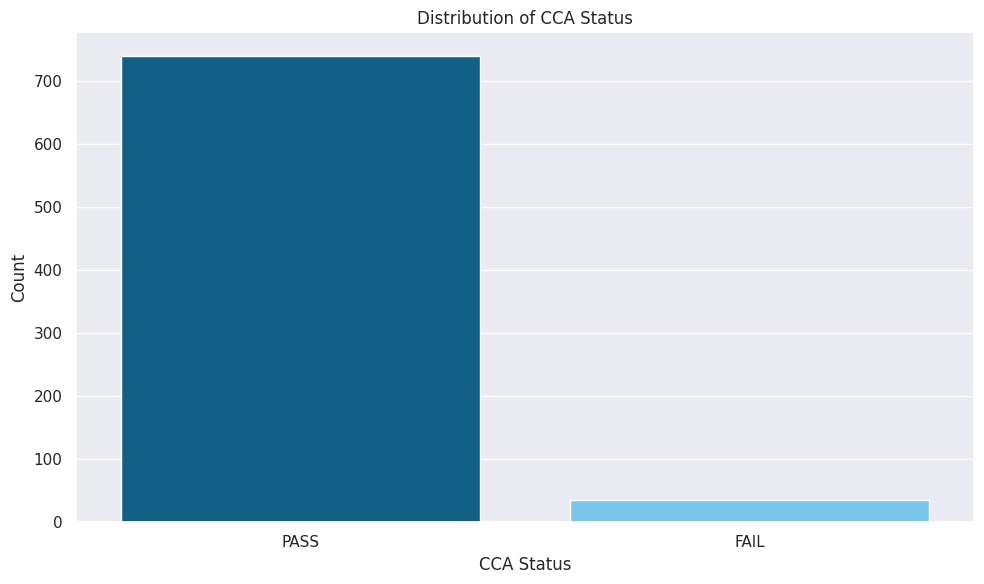

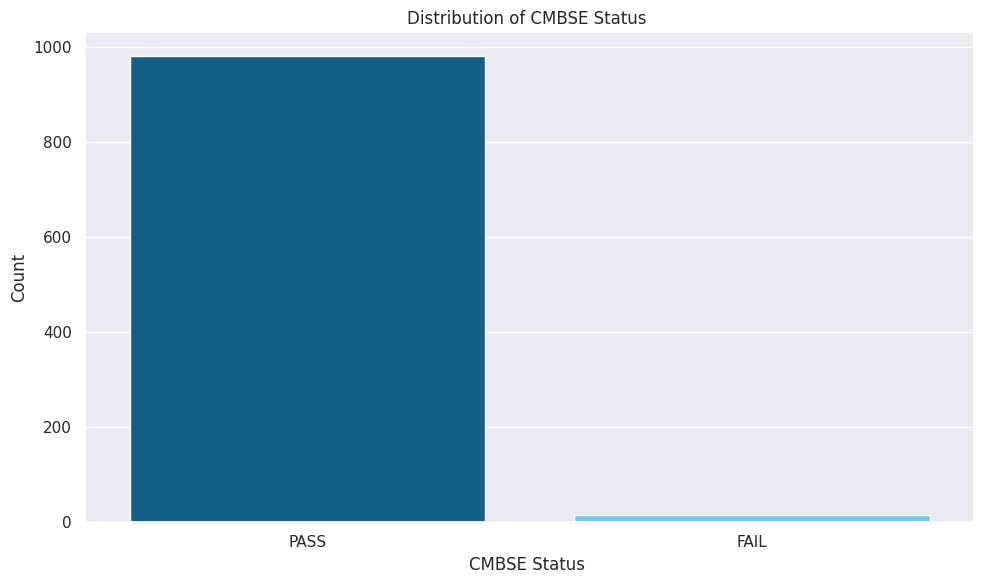

In [ ]:
# Select categorical columns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical columns
cat_cols = data.iloc[:, 1:33].select_dtypes(include=["object"]).columns.tolist()

# Set color palette to blue
custom_palette = sns.color_palette(["#006699", "#66CCFF", "#99CCFF", "#003366", "#336699"])
sns.set_palette(custom_palette)

# Create countplots for each categorical column and save as images
for col in cat_cols:
    plt.figure(figsize=(10,6))
    ax = sns.countplot(x=col, data=data)
    ax.set_ylabel("Count")
    ax.tick_params(axis="y")
    plt.title(f"Distribution of {col}")
    plt.savefig(address+"{col}_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()


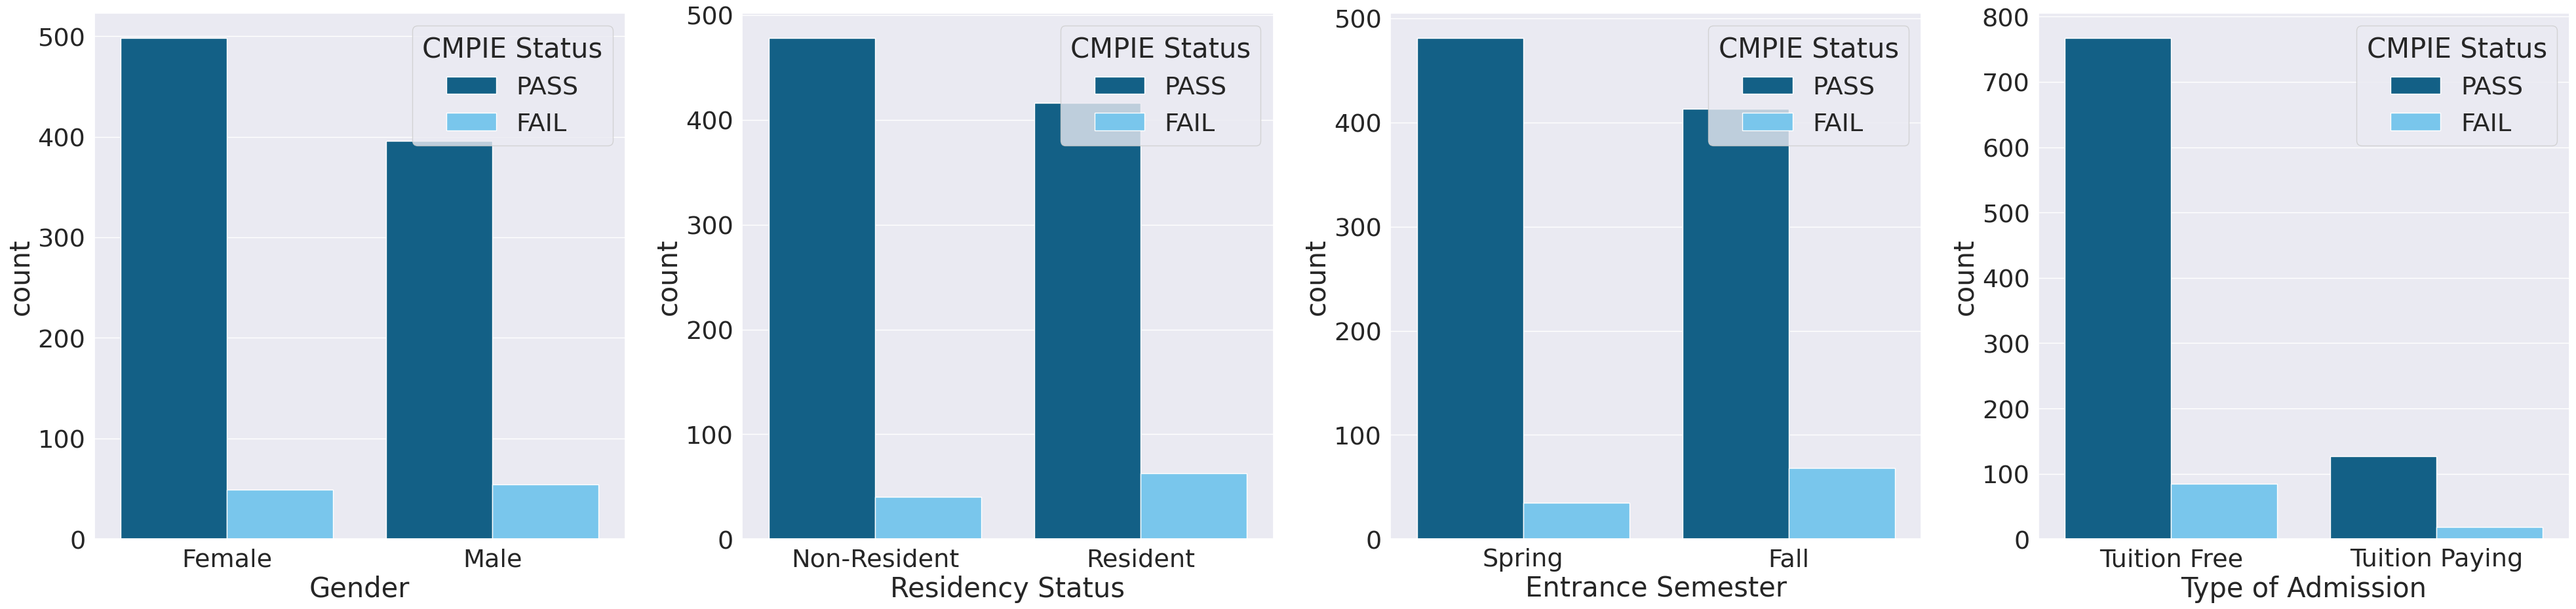

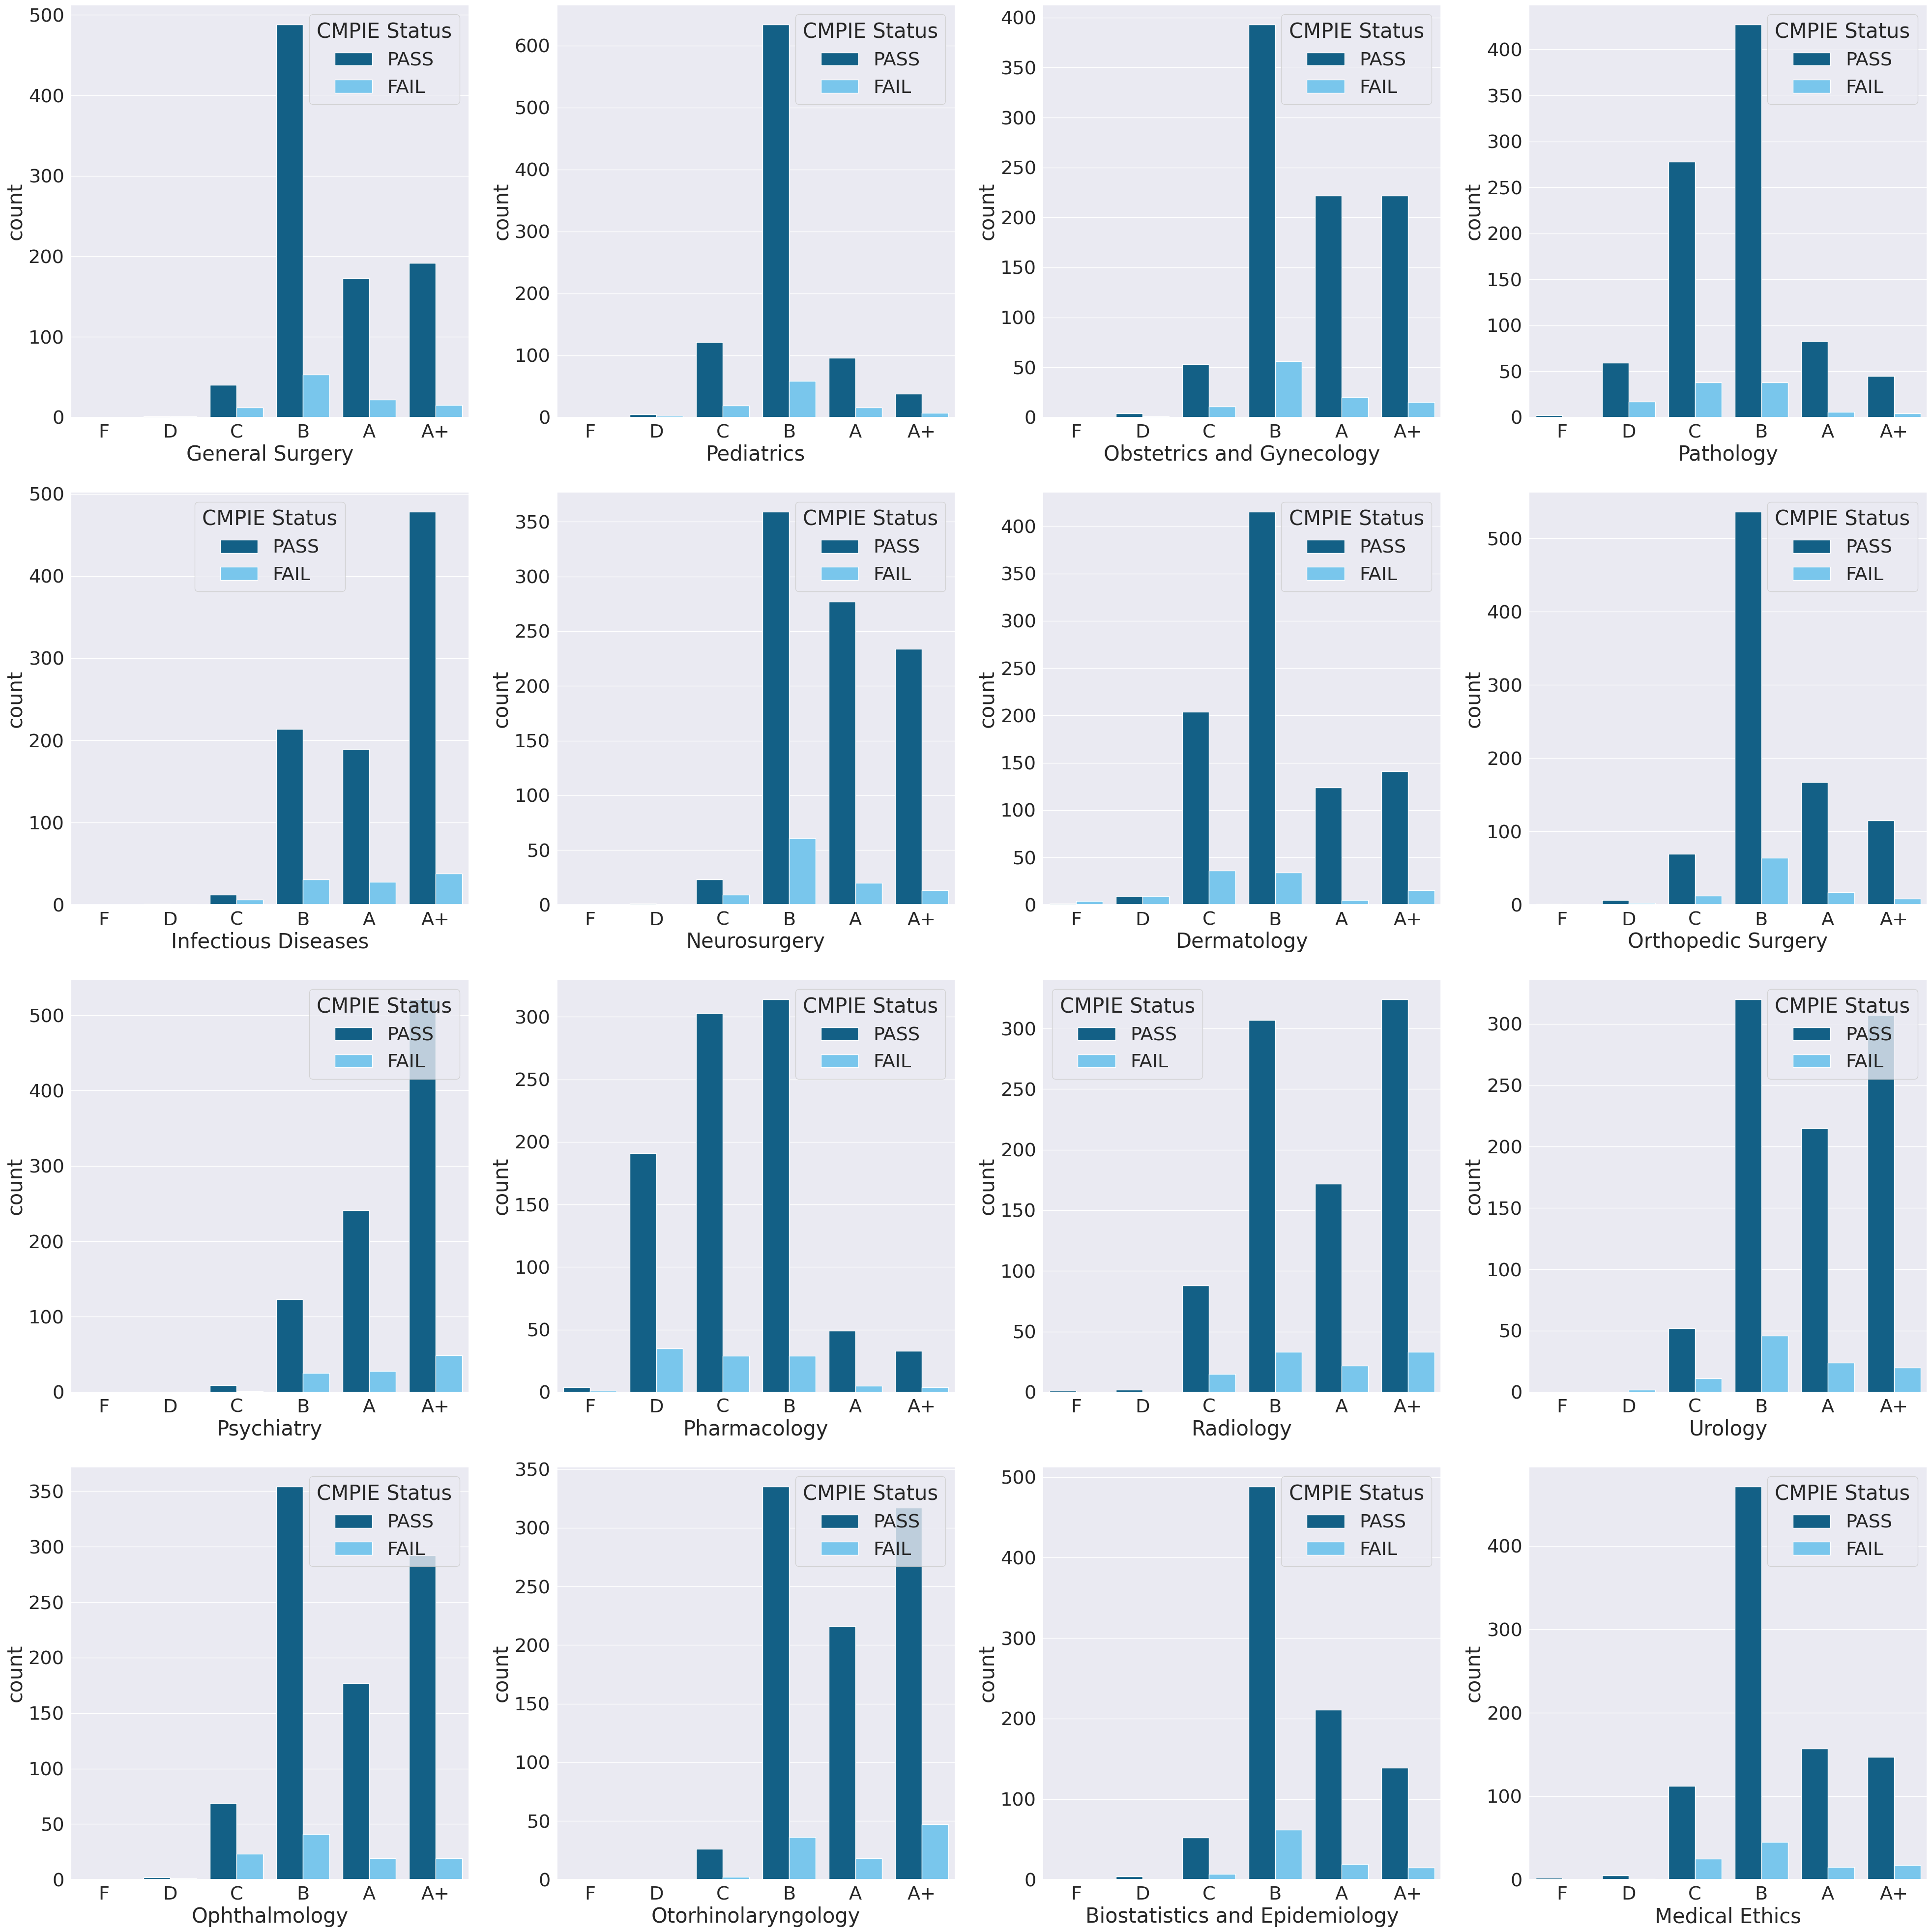

In [ ]:
import seaborn as sns
sns.set(font_scale=2.5)
custom_palette = sns.color_palette(["#006699", "#66CCFF", "#99CCFF", "#003366", "#336699"])
sns.set_palette(custom_palette)
# Create a list of labels in the desired order
label_order = ['F', 'D', 'C','B','A','A+']
plt.rcParams["figure.figsize"] = [40.00, 10]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 4)
i=0
for column in data.columns[col_start:5]:
    #sns.catplot(data=data, x=column, hue="CMPIE Status" , kind="count",ax=axes[i])
    sns_plot=sns.countplot(data=data,x=data[column],  hue=data["CMPIE Status" ],ax=axes[i%4])
    #print(data[column])
    i=i+1
fig=sns_plot.get_figure()
fig.savefig(address+"statistic1-1.jpeg", dpi=300, bbox_inches="tight")
warnings.filterwarnings("ignore", category=FutureWarning)
plt.show()

plt.rcParams["figure.figsize"] = [40.00, 40]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(4, 4)
i=0
for column in data.columns[6:22]:
    #sns.catplot(data=data, x=column, hue="CMPIE Status" , kind="count",ax=axes[i])
    sns_plot=sns.countplot(data=data,x=data[column], order=label_order, hue=data["CMPIE Status" ],ax=axes[i//4,i%4])
    #print(data[column])
    i=i+1
fig=sns_plot.get_figure()
fig.savefig(address+"statistic1-2.jpeg", dpi=300, bbox_inches="tight")
warnings.filterwarnings("ignore", category=FutureWarning)
plt.show()


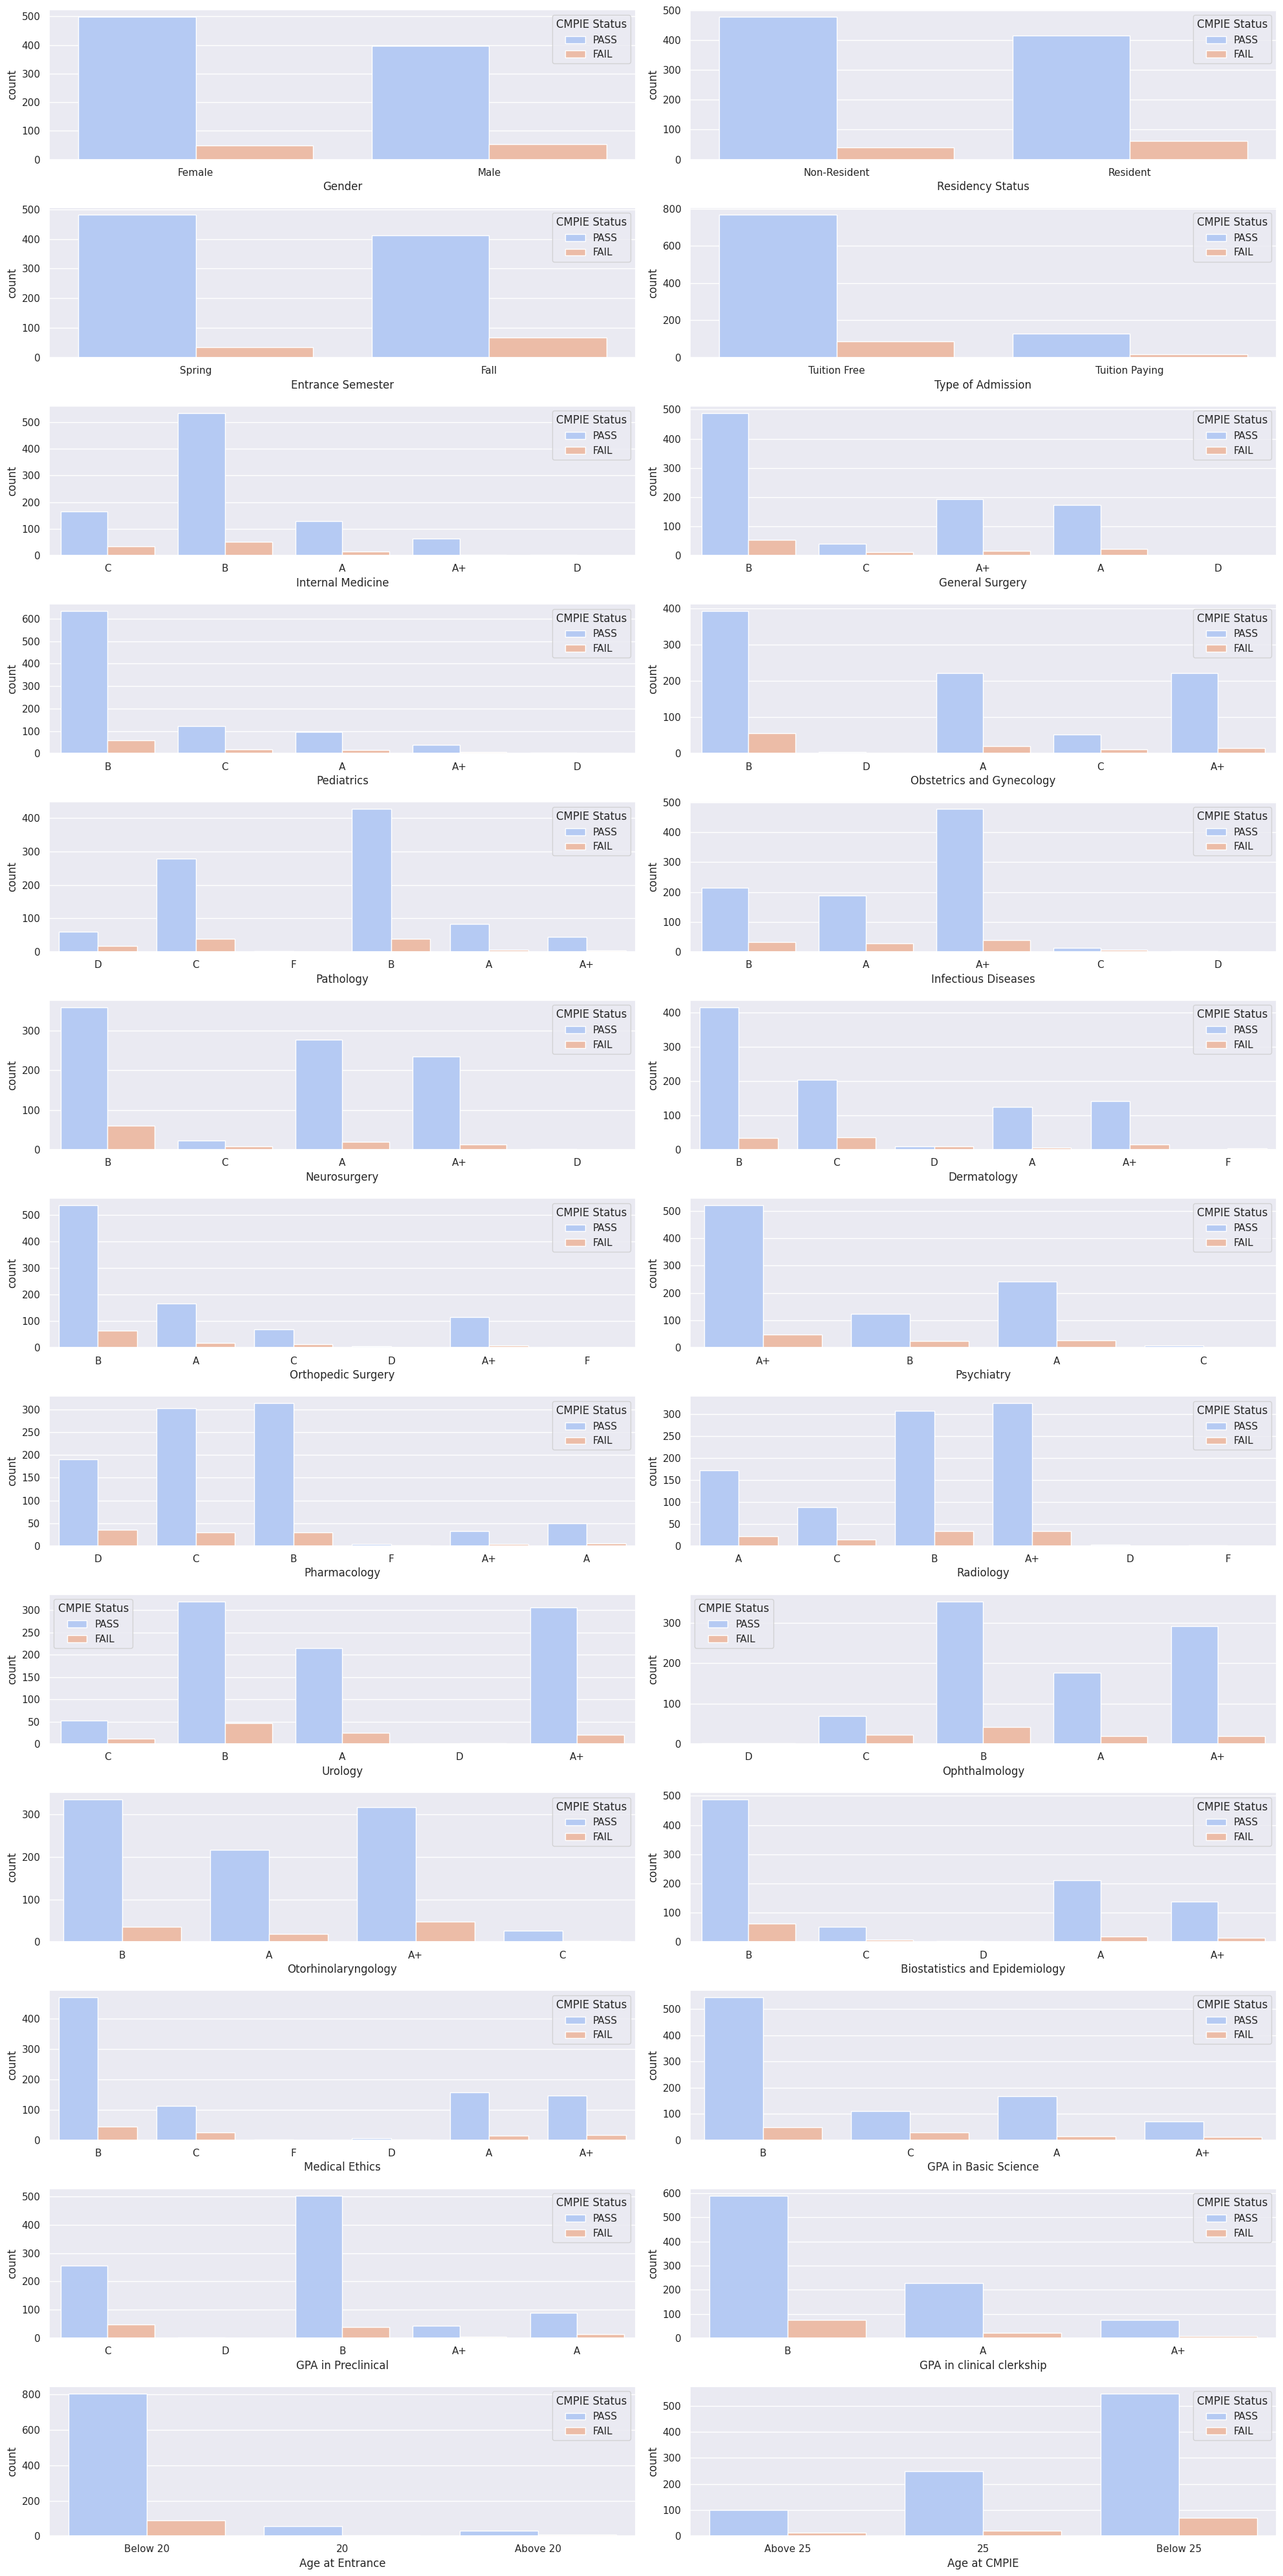

In [ ]:
plt.rcParams["figure.figsize"] = [20.00, 40]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(13,2)
i=0

for column in data.columns[col_start:col_end+1]:
    #sns.catplot(data=data, x=column, hue="CMPIE Status" , kind="count",ax=axes[i])
    sns_plot1=sns.countplot(data=data,x=data[column], palette="coolwarm", hue=data["CMPIE Status" ], ax=axes[i//2,i%2])
   # print(data[column])
    i=i+1
fig1=sns_plot1.get_figure()
fig1.savefig(address+"statistic2.png", dpi=300, bbox_inches="tight")

<ipython-input-24-9d22f91f521d>:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


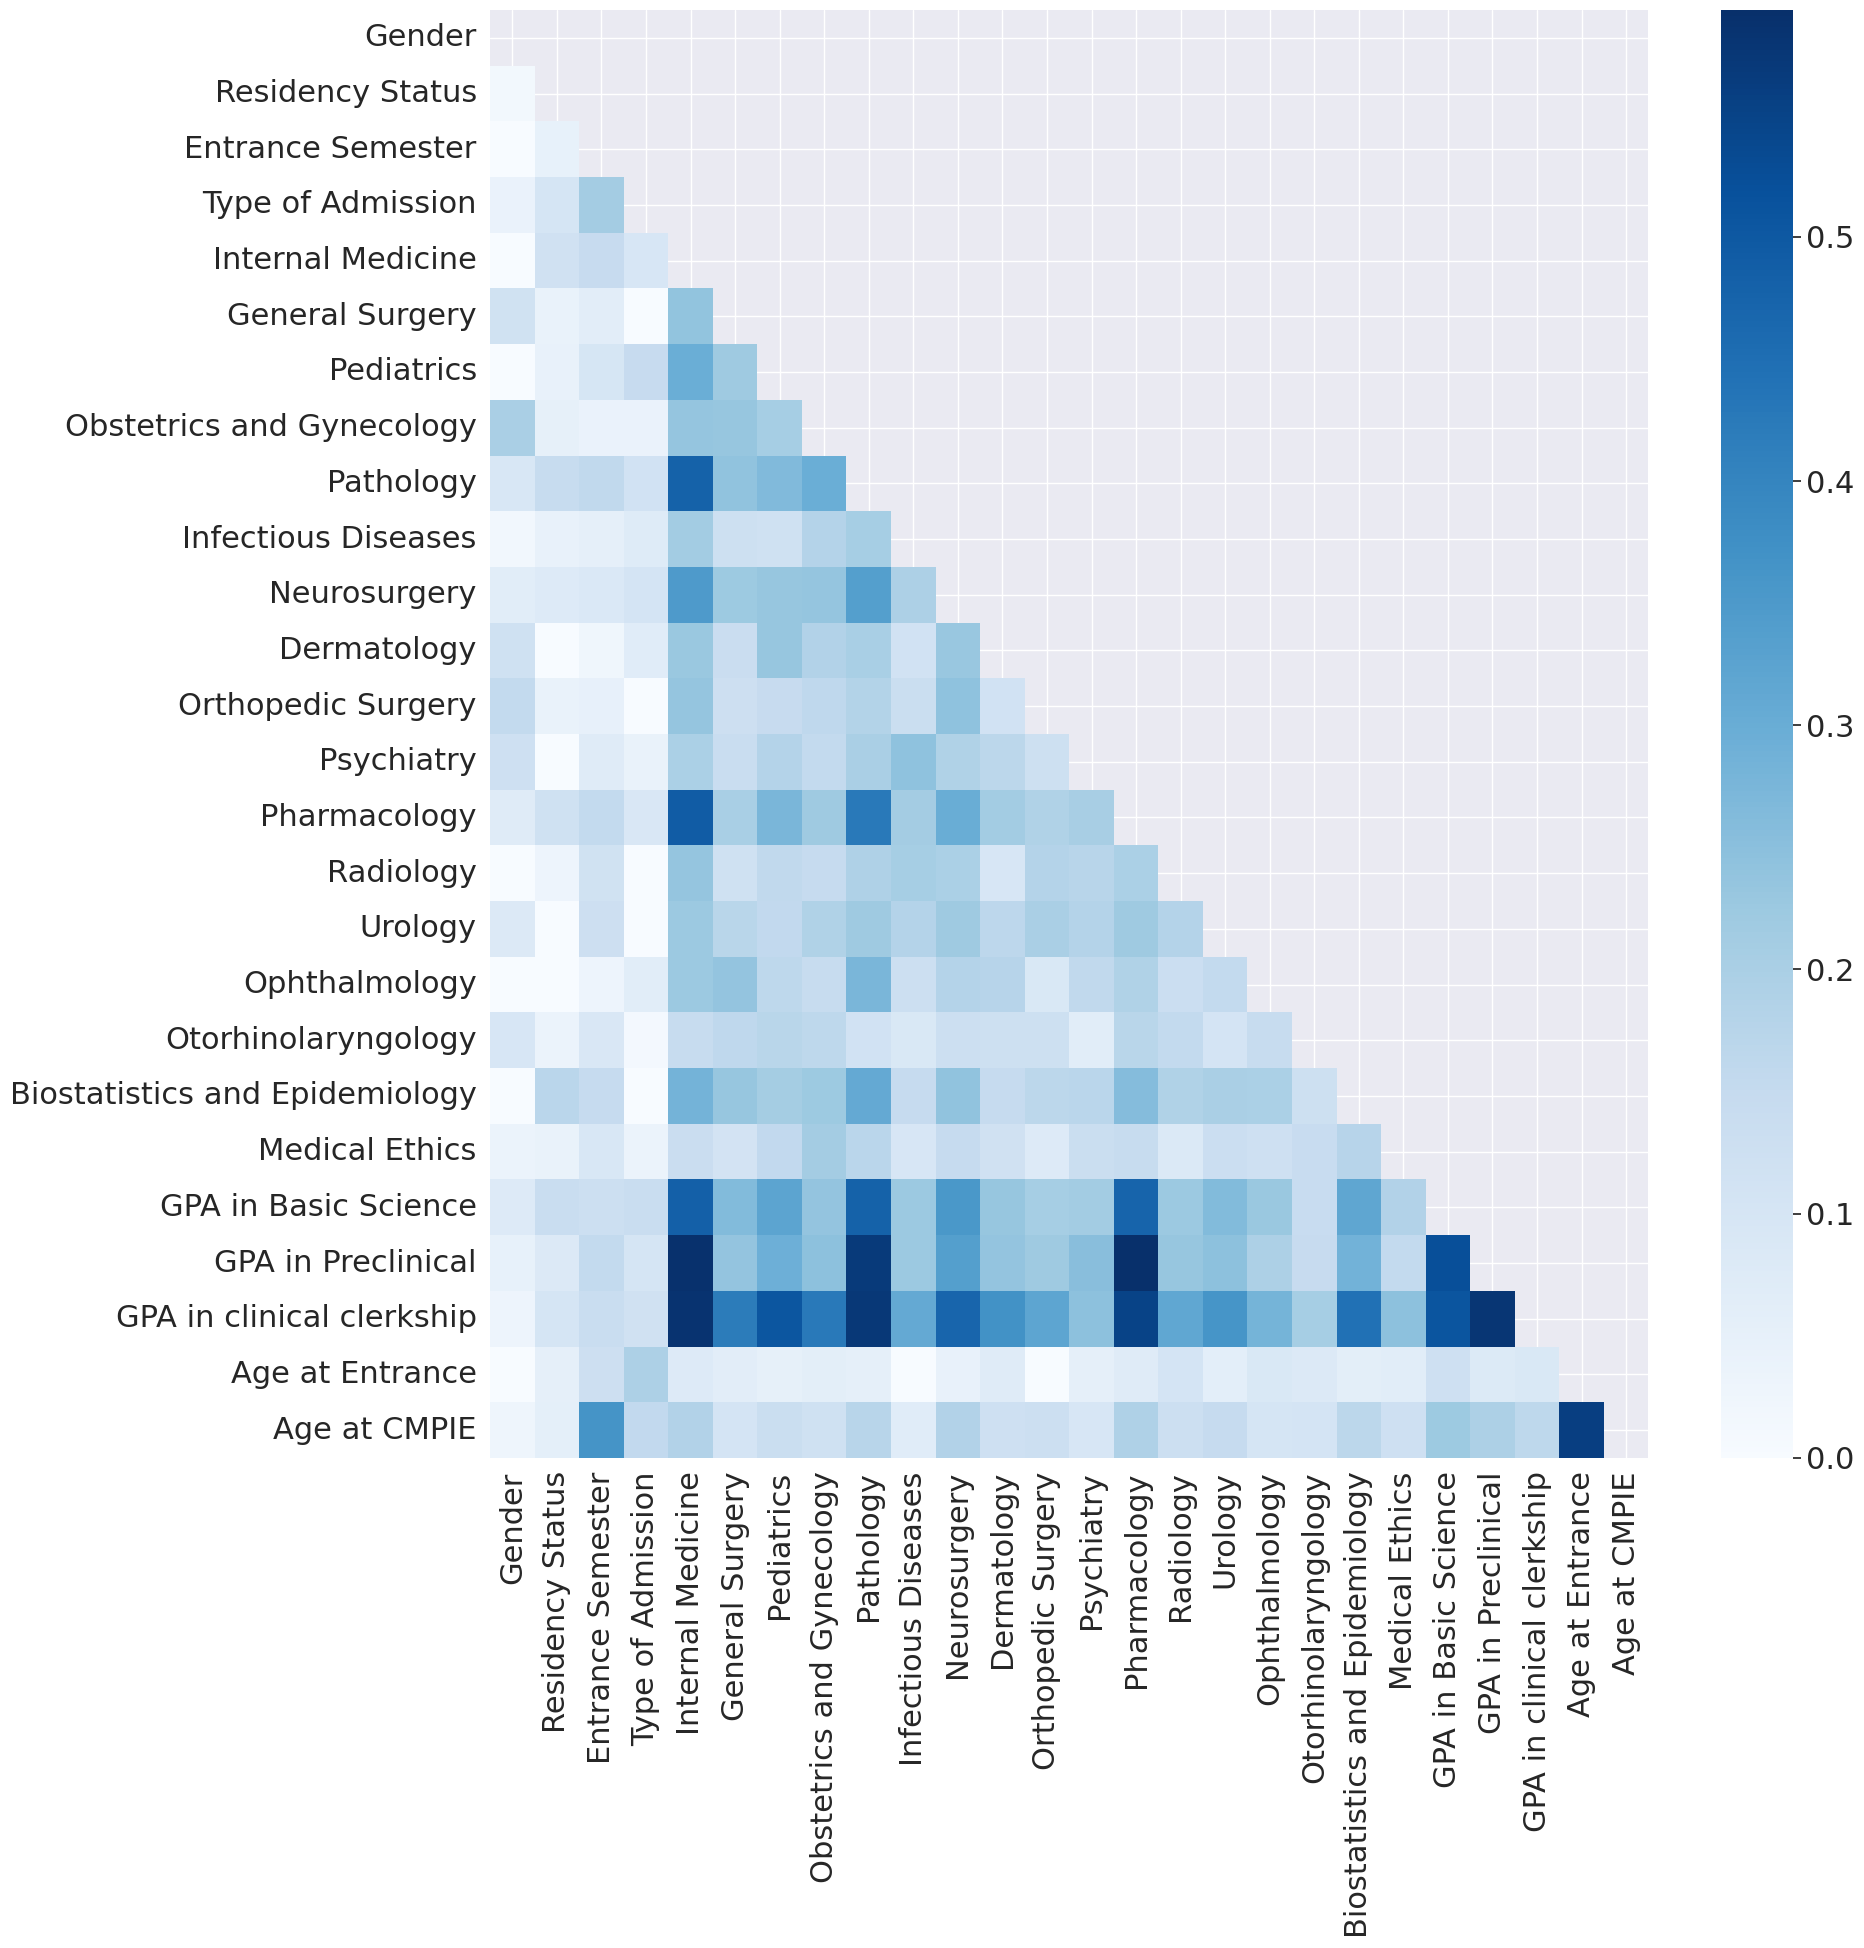

<Figure size 2000x2000 with 0 Axes>

In [ ]:

from scipy.stats import chi2_contingency

import seaborn as sns
sns.set(font_scale=2)
custom_palette = sns.color_palette(["#006699", "#66CCFF", "#99CCFF", "#003366", "#336699"])
sns.set_palette(custom_palette)

plt.rcParams["figure.figsize"] = [20.00, 20]
plt.rcParams["figure.autolayout"] = True
# Create a matrix to store the Cramer's V values
corr_matrix = np.zeros((col_end, col_end))

# Calculate Cramer's V for all pairs of columns
for i in range(1, col_end+1):
    for j in range(i + 1, col_end+1):
        contingency_table = pd.crosstab(data.iloc[:, i], data.iloc[:, j])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        r_corr = r - ((r - 1) ** 2) / (n - 1)
        k_corr = k - ((k - 1) ** 2) / (n - 1)

        # Store the Cramer's V value in the correlation matrix
        corr_matrix[i - 1, j - 1] = np.sqrt(phi2corr / min((k_corr - 1), (r_corr - 1)))
        corr_matrix[j - 1, i - 1] = np.sqrt(phi2corr / min((k_corr - 1), (r_corr - 1)))

# Create a DataFrame from the correlation matrix
corr_df = pd.DataFrame(corr_matrix, columns=data.columns[col_start:col_end+1], index=data.columns[col_start:col_end+1])

# Create a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

# Draw a heatmap of the correlation matrix with values annotated in the cells
sns.heatmap(corr_df, cmap="Blues", mask=mask)

# Display the plot
plt.show()
plt.savefig(address+"heaatmap.png", dpi=300, bbox_inches="tight")
# Save the correlation matrix to a CSV file
corr_df.to_csv(address+"corr_matrix.csv")




In [ ]:
# Set a threshold value for the correlation coefficient
threshold = 0.5

# Find the pairs of columns with correlation coefficient higher than the threshold
high_corr = np.where(corr_df > threshold)

# Print the pairs of columns with high correlation
for i, j in zip(*high_corr):
    print(f"{corr_df.columns[i]} and {corr_df.columns[j]} have a correlation coefficient of {corr_df.iloc[i, j]:.3f}")


Internal Medicine and GPA in Preclinical have a correlation coefficient of 0.590
Internal Medicine and GPA in clinical clerkship have a correlation coefficient of 0.584
Pediatrics and GPA in clinical clerkship have a correlation coefficient of 0.507
Pathology and GPA in Preclinical have a correlation coefficient of 0.568
Pathology and GPA in clinical clerkship have a correlation coefficient of 0.574
Pharmacology and GPA in Preclinical have a correlation coefficient of 0.593
Pharmacology and GPA in clinical clerkship have a correlation coefficient of 0.551
GPA in Basic Science and GPA in Preclinical have a correlation coefficient of 0.521
GPA in Basic Science and GPA in clinical clerkship have a correlation coefficient of 0.509
GPA in Preclinical and Internal Medicine have a correlation coefficient of 0.590
GPA in Preclinical and Pathology have a correlation coefficient of 0.568
GPA in Preclinical and Pharmacology have a correlation coefficient of 0.593
GPA in Preclinical and GPA in Bas

t-test

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

import pandas as pd
from scipy.stats import chi2_contingency

# Select categorical columns
cat_cols = data.iloc[:, 1:28].select_dtypes(include=["object"]).columns.tolist()

# Initialize dictionary to store results
results = {}

# Loop over categorical columns and perform chi-square test
for col in cat_cols:
    contingency_table = pd.crosstab(data[col], data["CMPIE Status"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results[col] = {"Test Statistic": chi2, "p-value": p}

# Convert dictionary to DataFrame and format results
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df["p-value"] = results_df["p-value"].round(3)
results_df["Test Statistic"] = results_df["Test Statistic"].round(3)

# Determine significant columns
sig_cols = results_df[results_df["p-value"] < 0.05].index.tolist()

# Displaythe results in a table
print("Chi-Square Test Results:")
print(results_df)

# Display significant columns
if sig_cols:
    print("\nSignificant Categorical Features:")
    print(sig_cols)
else:
    print("\nNo significant differences found.")
results_df.to_csv(address+"chi2.csv")

Chi-Square Test Results:
                                Test Statistic  p-value
Gender                                   2.149    0.143
Residency Status                         7.347    0.007
Entrance Semester                       13.751    0.000
Type of Admission                        0.553    0.457
Internal Medicine                       15.929    0.003
General Surgery                         15.000    0.005
Pediatrics                               9.788    0.044
Obstetrics and Gynecology               11.187    0.025
Pathology                               16.923    0.005
Infectious Diseases                     18.274    0.001
Neurosurgery                            30.019    0.000
Dermatology                             71.999    0.000
Orthopedic Surgery                       5.986    0.308
Psychiatry                               8.731    0.033
Pharmacology                             9.282    0.098
Radiology                                3.149    0.677
Urology                

##### LET START MPDELING

ONE HOT ENCODDEEEERRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

In [ ]:
##### 2 state
x_all_1=data.iloc[:,1:5]
x_all_2=data.iloc[:,6:27]
y_all=data["CMPIE Status"].values
one_hot_encoder=OneHotEncoder(drop="first") # two state one state drop
onehot_x1=one_hot_encoder.fit_transform(x_all_1).toarray()
newcol=one_hot_encoder.get_feature_names_out()
data_1=pd.DataFrame(onehot_x1,columns=newcol)
data_1.info()
one_hot_encoder=OneHotEncoder()
onehot_x1=one_hot_encoder.fit_transform(x_all_2).toarray()
newcol=one_hot_encoder.get_feature_names_out()
data_2=pd.DataFrame(onehot_x1,columns=newcol)
data_2.info()
one_hot_encoder=OneHotEncoder(drop="first")
onehot_xT=one_hot_encoder.fit_transform(y_all.reshape(-1,1)).toarray()
newcol=one_hot_encoder.get_feature_names_out()
data_T=pd.DataFrame(data=onehot_xT,columns=newcol)
result = pd.concat([data_1, data_2,data_T], axis=1)
for column in result.columns:
    result[column] = result[column].astype('int')
result.to_csv(address+'onhot_results.csv', index=False)
print(result.sum())
print(result.shape[0])
print(result.shape[1])
selected_cols = []
for col in result.columns:
    prop_true = result[col].sum()/result.shape[0]
    if prop_true < 0.01:
      print(f"Column '{col}' has less than 1% True values ({prop_true:.2%})")
      selected_cols.append(col)
print(selected_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender_Male                       997 non-null    float64
 1   Residency Status_Resident         997 non-null    float64
 2   Entrance Semester_Spring          997 non-null    float64
 3   Type of Admission_Tuition Paying  997 non-null    float64
dtypes: float64(4)
memory usage: 31.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Columns: 102 entries, General Surgery_A to Age at CMPIE_Below 25
dtypes: float64(102)
memory usage: 794.6 KB
Gender_Male                         450
Residency Status_Resident           479
Entrance Semester_Spring            516
Type of Admission_Tuition Paying    145
General Surgery_A                   195
                                   ... 
Age at Entrance_Below 20            896
Age at CMPIE_25 

In [ ]:
df_Xarray=result.iloc[:,:-1].values
df_Yarray=result.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(df_Xarray,df_Yarray,test_size=0.33, random_state=42,shuffle=True)
print(X_train.shape)
print(result.shape)

(667, 106)
(997, 107)


without smote

Percentage of 0s: 10.303030303030303
Percentage of 1s: 89.6969696969697


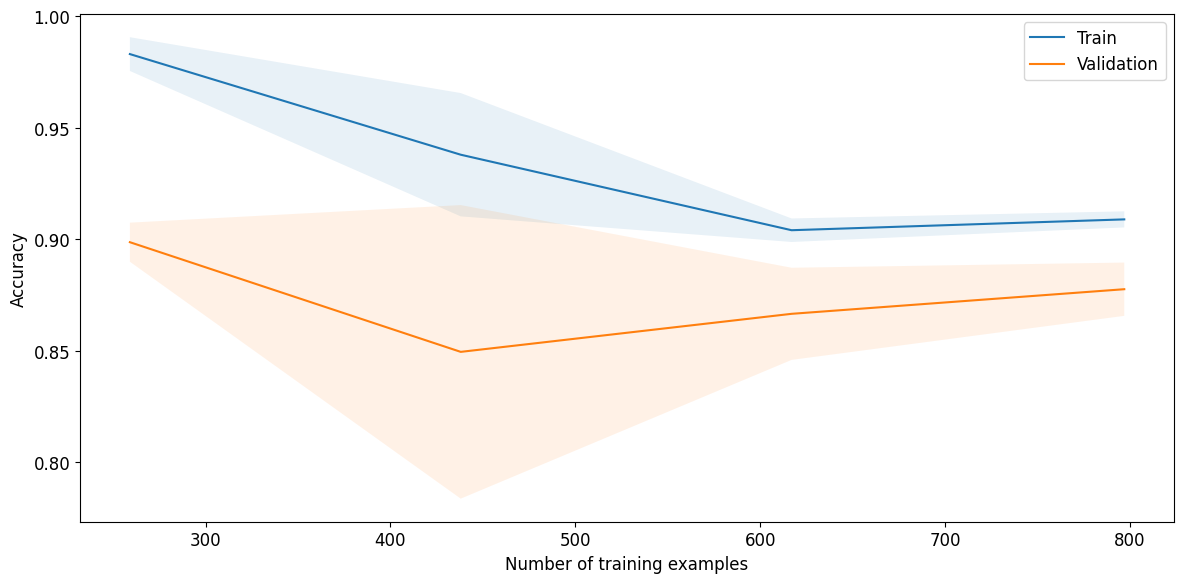

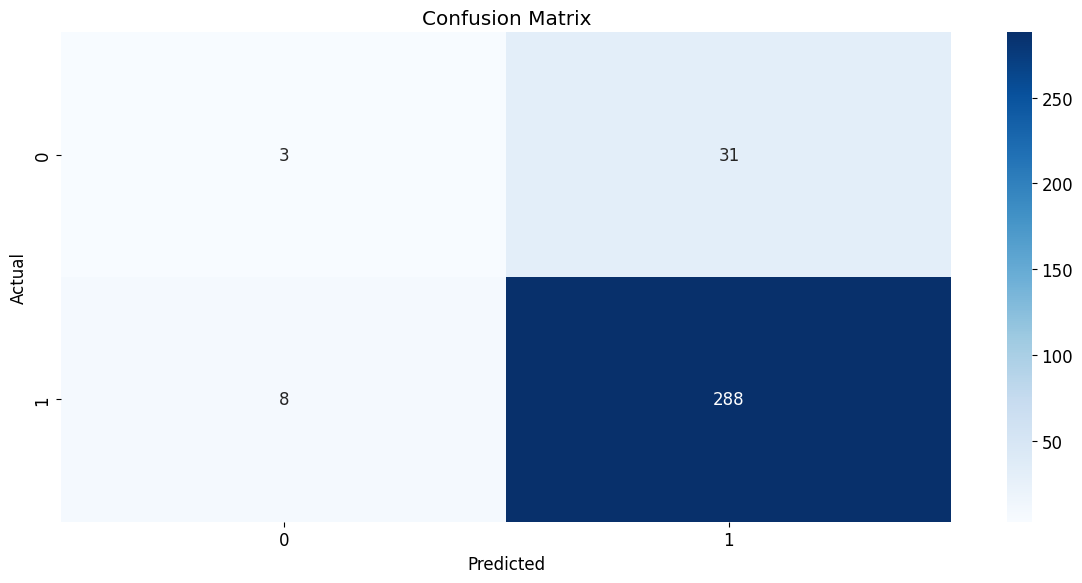

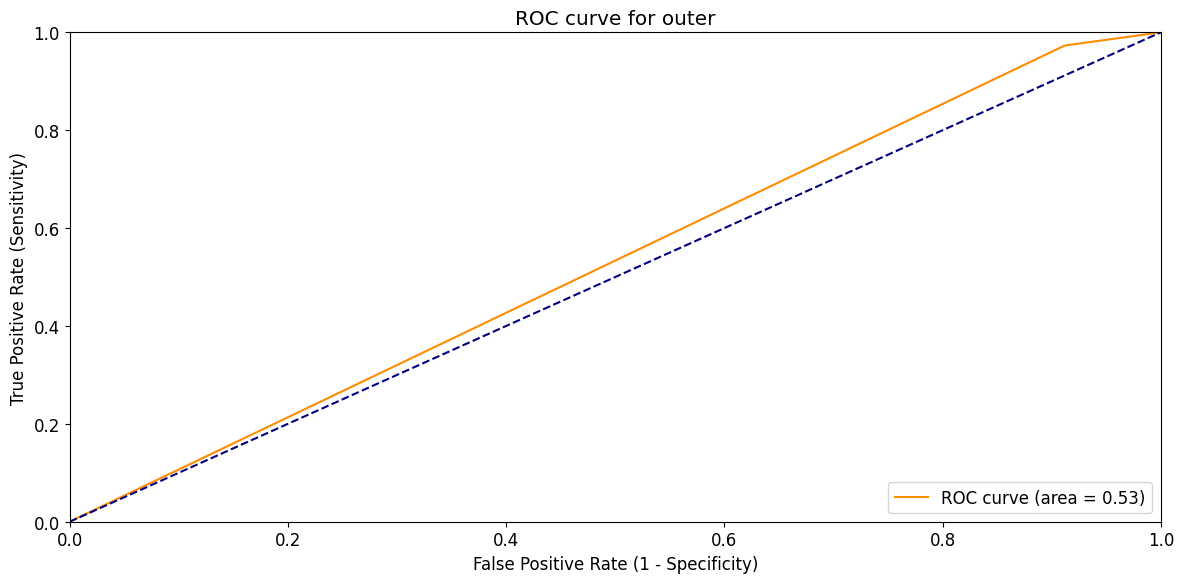

FSCOR 0 :  0.13333333333333333
RECALL 0 :  0.08823529411764706
PRECISION 0 :  0.2727272727272727
FSCOR 1 :  0.9365853658536586
RECALL 1 :  0.972972972972973
PRECISION 1 :  0.9028213166144201
Test set metrics:
Accuracy: 0.8818181818181818
Precision: 0.9028213166144201
Recall: 0.972972972972973
F1 score: 0.9365853658536586
Specificity: 0.08823529411764706
sensitivity: 0.972972972972973
AUC: 0.53060413354531
Train set metrics:
Accuracy: 0.9070464767616192
Precision: 0.9135802469135802
Recall: 0.9899665551839465
F1 score: 0.9502407704654896
Specificity: 0.18840579710144928
sensitivity: 0.9899665551839465
AUC: 0.5891861761426979
Overfitting check (between the test and train sets should be less than 5%):
Accuracy difference: 0.025228294943437368
Precision difference: 0.010758930299160085
Recall difference: 0.016993582210973468
F1 score difference: 0.013655404611831012
Specificity difference: 0.10017050298380221
Sensitivity difference: 0.016993582210973468
AUC difference: 0.05858204259738786


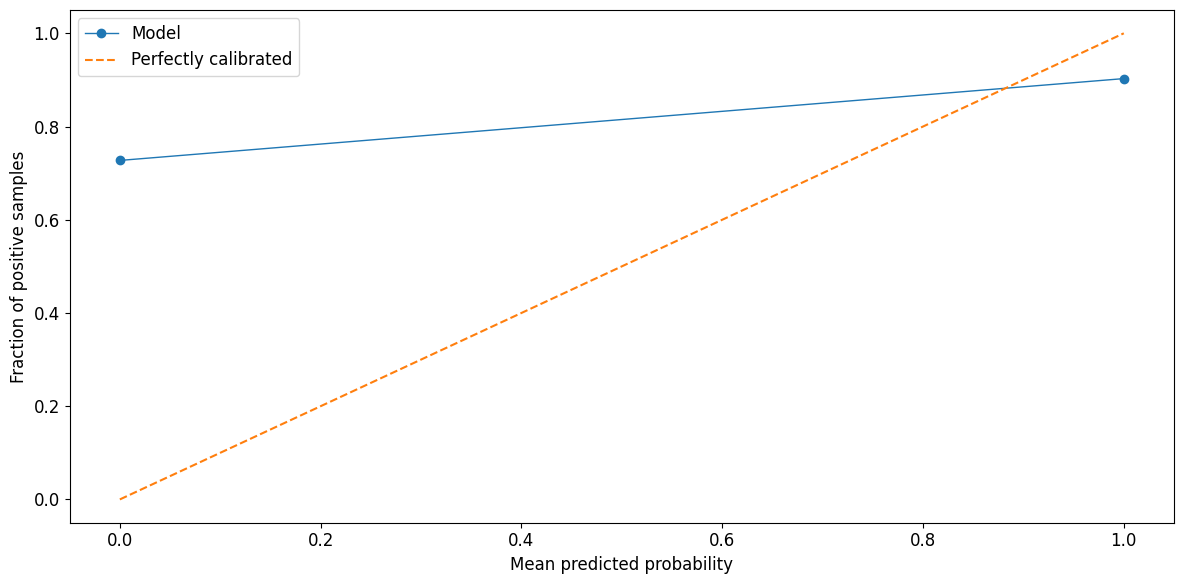

<Figure size 1200x600 with 0 Axes>

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,auc,roc_curve,RocCurveDisplay
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
classes = classifier.classes_
y_pred = classifier.predict(X_test)

counts = np.bincount(y_test)

num_zeros = counts[0]
num_ones = counts[1]

total = len(y_test)
percent_zeros = num_zeros / total * 100
percent_ones = num_ones / total * 100

print("Percentage of 0s:", percent_zeros)
print("Percentage of 1s:", percent_ones)


from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# X and y are the input features and labels, respectively
# model is the classification model to be trained
train_sizes, train_scores, test_scores = learning_curve(classifier, df_Xarray,df_Yarray, cv=5)
# Calculate mean and standard deviation of train and test scores across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(address+"auc_learning_curve_without_smote.png", dpi=300, bbox_inches="tight")

plt.rcParams["figure.figsize"] = [12.00, 6] ## سن امتحان حذف درس اخلاق
plt.rcParams["figure.autolayout"] = True
fpr, tpr, _ = roc_curve(y_test, y_pred)
AUC=auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(address+"confusion_without_smote.png", dpi=300, bbox_inches="tight")



plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for outer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()
plt.savefig(address+"auc_without_smote.png", dpi=300, bbox_inches="tight")

Accuracy = accuracy_score(y_test, y_pred) * 100
FSCORE=f1_score(y_test, y_pred, average=None)
RECALL=recall_score(y_test, y_pred, average=None)
PRECISION=precision_score(y_test, y_pred, average=None)
for i in range(len(classes)):
      print("FSCOR", classes[i], ": ",FSCORE[i])
      print("RECALL", classes[i], ": ",RECALL[i])
      print("PRECISION", classes[i], ": ",PRECISION[i])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# True labels and predicted labels for test set
y_true_train = y_train
y_pred_train = classifier.predict(X_train)
    # True labels and predicted labels for train set
y_true_test = y_test
y_pred_test = classifier.predict(X_test)# predicted labels for train set
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_score_test = f1_score(y_true_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test, y_pred_test).ravel()
specificity_test = tn_test / (tn_test + fp_test)
sensitivity_test = tp_test / (tp_test + fn_test)
auc_test = roc_auc_score(y_true_test, y_pred_test)
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for train set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_score_train = f1_score(y_true_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_true_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train)
sensitivity_train = tp_train / (tp_train + fn_train)
auc_train = roc_auc_score(y_true_train, y_pred_train)
# Print the evaluation metrics
print("Test set metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_score_test)
print("Specificity:", specificity_test)
print("sensitivity:", sensitivity_test)
print("AUC:", auc_test)
print("Train set metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 score:", f1_score_train)
print("Specificity:", specificity_train)
print("sensitivity:", sensitivity_train)
print("AUC:", auc_train)

# Check for overfitting by comparing metrics of test and train sets
#One common rule of thumb is that the difference in performance metrics between the test and train sets should be less than 5%.
print("Overfitting check (between the test and train sets should be less than 5%):")
print("Accuracy difference:", np.abs(accuracy_test - accuracy_train))
print("Precision difference:", np.abs(precision_test - precision_train))
print("Recall difference:", np.abs(recall_test - recall_train))
print("F1 score difference:", np.abs(f1_score_test - f1_score_train))
print("Specificity difference:", np.abs(specificity_test - specificity_train))
print("Sensitivity difference:", abs(sensitivity_test - sensitivity_train))
print("AUC difference:", np.abs(auc_test - auc_train))

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# y_true is the true labels for the test set, and y_probs is the predicted probabilities
y_true = y_test# true labels for test set
y_probs = y_pred # predicted probabilities for test set
# Calculate calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_probs, n_bins=10)
# Plot calibration curve
plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive samples')
plt.legend()
plt.show()
plt.savefig(address+"calibration curve_stacking_without_smote.png", dpi=300, bbox_inches="tight")


with smote



counter_aresamble :   0    889
1    539
Name: target, dtype: int64


<ipython-input-66-69ef24a6318d>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_names, rotation=90, fontsize=12)


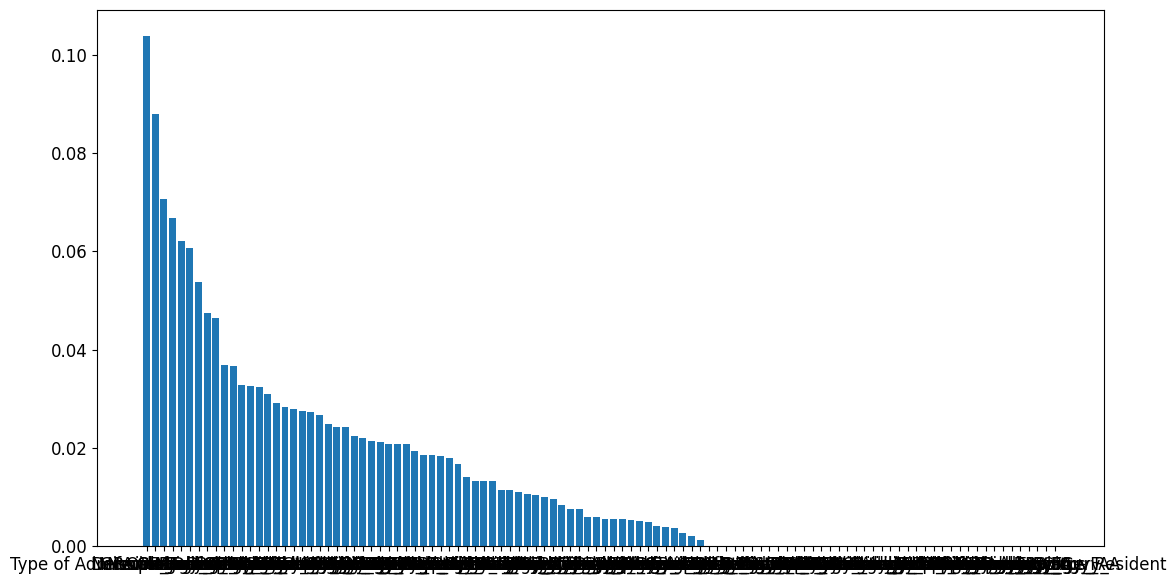

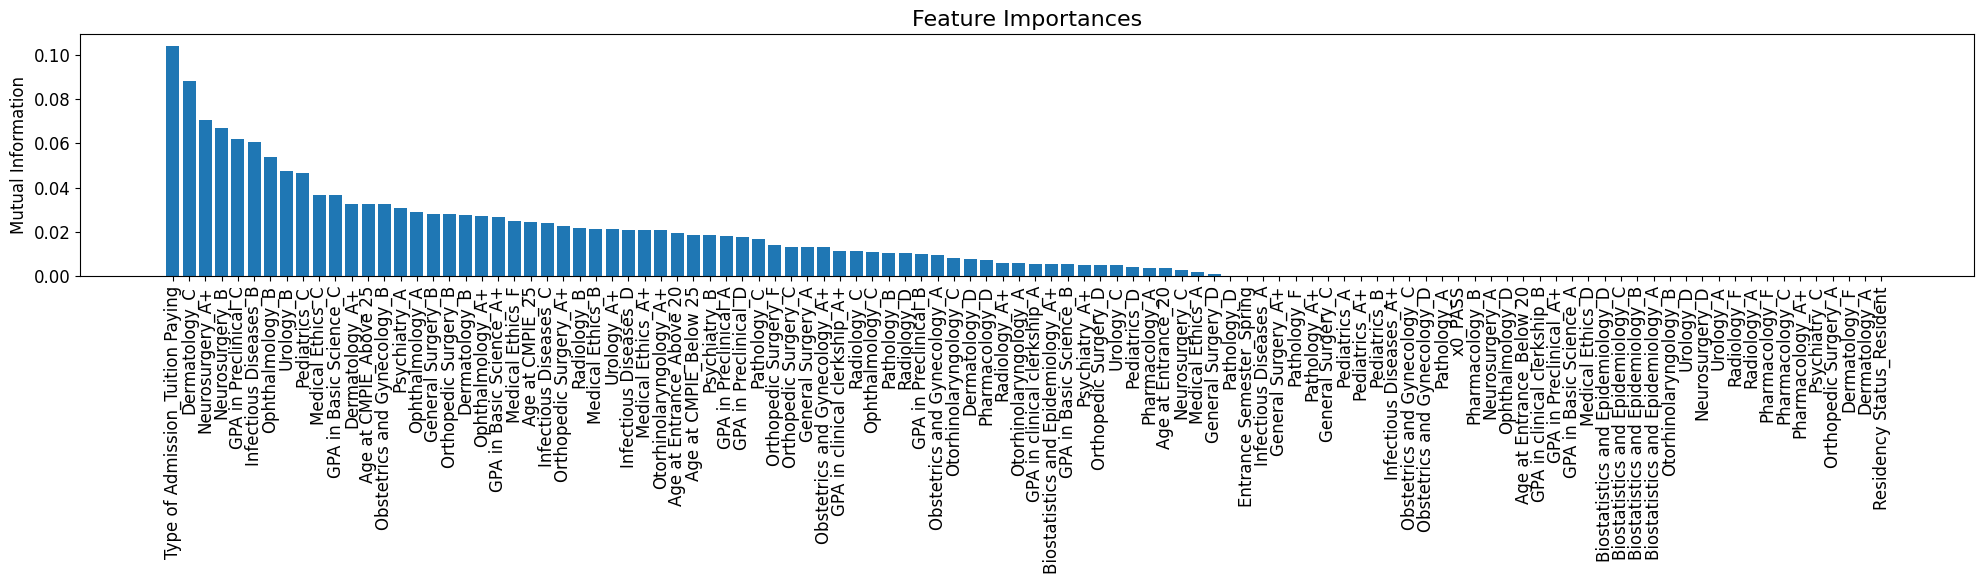

Percentage of 0s: 61.86440677966102
Percentage of 1s: 38.13559322033898


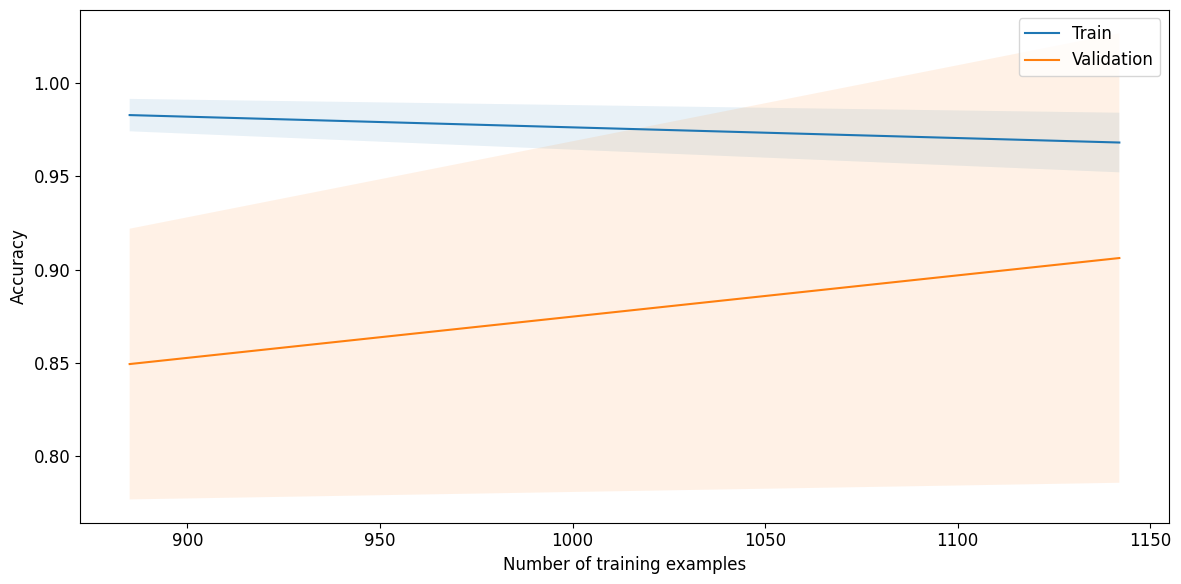

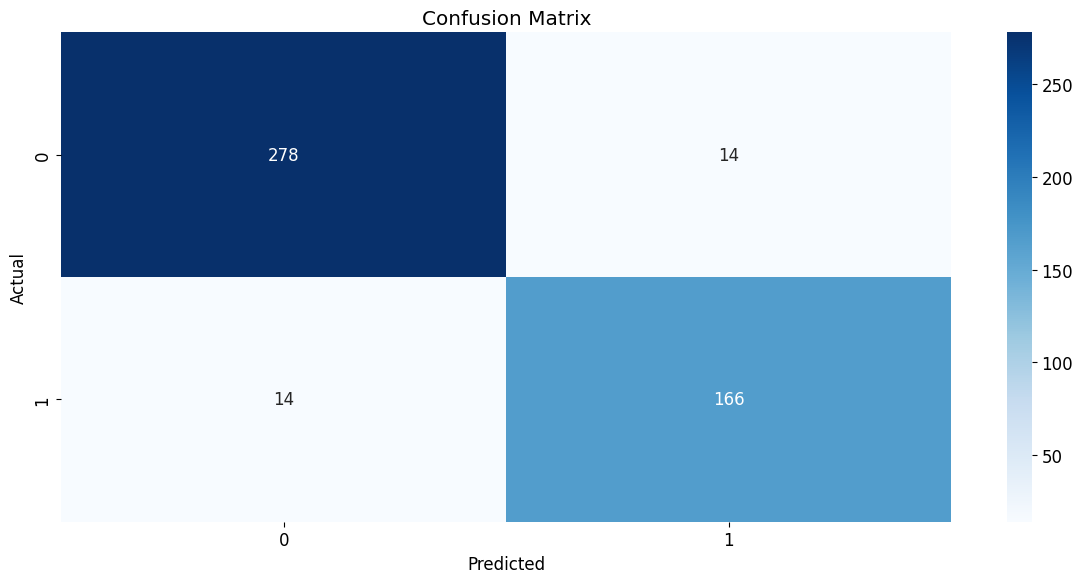

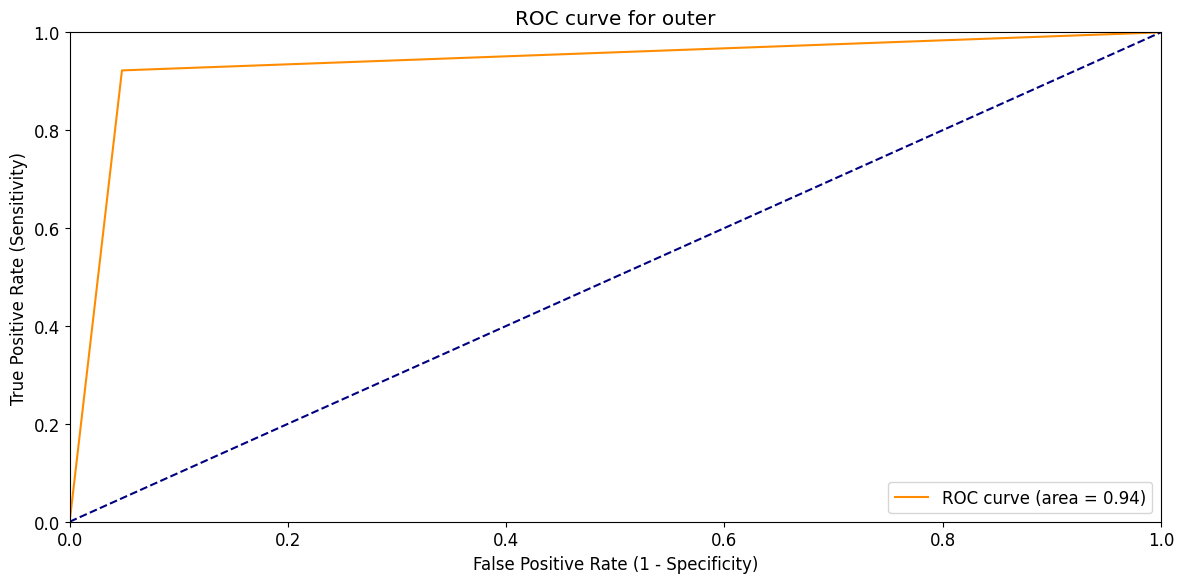

FSCOR 0 :  0.952054794520548
RECALL 0 :  0.952054794520548
PRECISION 0 :  0.952054794520548
FSCOR 1 :  0.9222222222222223
RECALL 1 :  0.9222222222222223
PRECISION 1 :  0.9222222222222223
Test set metrics:
Accuracy: 0.940677966101695
Precision: 0.9222222222222223
Recall: 0.9222222222222223
F1 score: 0.9222222222222223
Specificity: 0.952054794520548
sensitivity: 0.9222222222222223
AUC: 0.9371385083713851
Train set metrics:
Accuracy: 0.9748953974895398
Precision: 0.9514824797843666
Recall: 0.9832869080779945
F1 score: 0.9671232876712329
Specificity: 0.9698492462311558
sensitivity: 0.9832869080779945
AUC: 0.9765680771545752
Overfitting check (between the test and train sets should be less than 5%):
Accuracy difference: 0.03421743138784483
Precision difference: 0.029260257562144343
Recall difference: 0.06106468585577218
F1 score difference: 0.044901065449010624
Specificity difference: 0.017794451710607784
Sensitivity difference: 0.06106468585577218
AUC difference: 0.03942956878319004


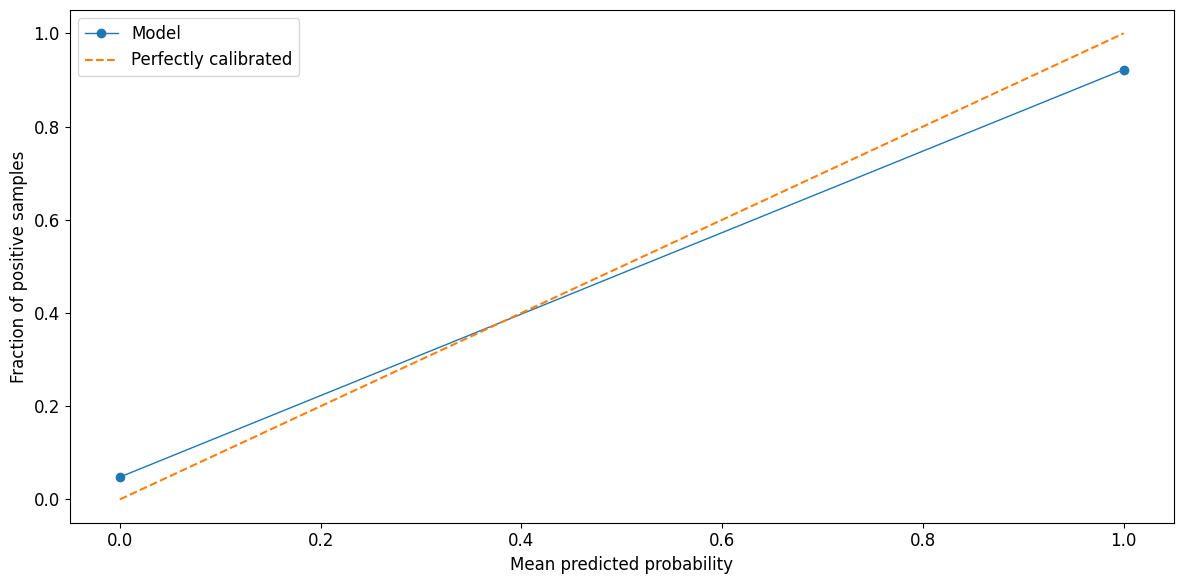

<Figure size 1200x600 with 0 Axes>

In [ ]:
#from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTEN
#from imblearn.over_sampling import KMeansSMOTE
#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.combine import SMOTETomek
#from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,auc,roc_curve,RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTEENN
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

resamble = SMOTEENN(random_state=0)
X_r,Y_r=resamble.fit_resample(df_Xarray,df_Yarray)
c1=result.columns[1:]
df_os=pd.DataFrame(X_r,columns=c1)
df_os["target"]=Y_r
counter_Aresamble = df_os.iloc[:,-1].value_counts()
print("\n")
print("counter_aresamble :  ",counter_Aresamble)
df_Xarray=df_os.iloc[:,:-1].values
df_Yarray=df_os.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(df_Xarray,df_Yarray,test_size=0.33, random_state=42,shuffle=True)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
classes = classifier.classes_
y_pred = classifier.predict(X_test)


# Compute the mutual information between each feature and the target variable
mi = mutual_info_classif(X_train, y_train)
# Sort the feature importances in descending order
sorted_idx = np.argsort(mi)[::-1]
sorted_names = c1[sorted_idx]
sorted_mi = mi[sorted_idx]
# Create a bar chart of the sorted feature importances
fig, ax = plt.subplots()
ax.bar(sorted_names, sorted_mi)
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(sorted_names, sorted_mi)
ax.set_xticklabels(sorted_names, rotation=90, fontsize=12)
ax.set_ylabel('Mutual Information', fontsize=12)
ax.set_title('Feature Importances', fontsize=16)
plt.show()
plt.savefig(address+"Feature Importances.png", dpi=300, bbox_inches="tight")

counts = np.bincount(y_test)

num_zeros = counts[0]
num_ones = counts[1]

total = len(y_test)
percent_zeros = num_zeros / total * 100
percent_ones = num_ones / total * 100

print("Percentage of 0s:", percent_zeros)
print("Percentage of 1s:", percent_ones)


from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# X and y are the input features and labels, respectively
# model is the classification model to be trained
train_sizes, train_scores, test_scores = learning_curve(classifier, df_Xarray,df_Yarray, cv=5)
# Calculate mean and standard deviation of train and test scores across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(address+"auc_learning_curve_smote.png", dpi=300, bbox_inches="tight")

plt.rcParams["figure.figsize"] = [12.00, 6] ## سن امتحان حذف درس اخلاق
plt.rcParams["figure.autolayout"] = True
fpr, tpr, _ = roc_curve(y_test, y_pred)
AUC=auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(address+"confusion_smote.png", dpi=300, bbox_inches="tight")



plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for outer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()
plt.savefig(address+"auc_out_smote.png", dpi=300, bbox_inches="tight")

Accuracy = accuracy_score(y_test, y_pred) * 100
FSCORE=f1_score(y_test, y_pred, average=None)
RECALL=recall_score(y_test, y_pred, average=None)
PRECISION=precision_score(y_test, y_pred, average=None)
for i in range(len(classes)):
      print("FSCOR", classes[i], ": ",FSCORE[i])
      print("RECALL", classes[i], ": ",RECALL[i])
      print("PRECISION", classes[i], ": ",PRECISION[i])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# True labels and predicted labels for test set
y_true_train = y_train
y_pred_train = classifier.predict(X_train)
    # True labels and predicted labels for train set
y_true_test = y_test
y_pred_test = classifier.predict(X_test)# predicted labels for train set
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_score_test = f1_score(y_true_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test, y_pred_test).ravel()
specificity_test = tn_test / (tn_test + fp_test)
sensitivity_test = tp_test / (tp_test + fn_test)
auc_test = roc_auc_score(y_true_test, y_pred_test)
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for train set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_score_train = f1_score(y_true_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_true_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train)
sensitivity_train = tp_train / (tp_train + fn_train)
auc_train = roc_auc_score(y_true_train, y_pred_train)
# Print the evaluation metrics
print("Test set metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_score_test)
print("Specificity:", specificity_test)
print("sensitivity:", sensitivity_test)
print("AUC:", auc_test)
print("Train set metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 score:", f1_score_train)
print("Specificity:", specificity_train)
print("sensitivity:", sensitivity_train)
print("AUC:", auc_train)

# Check for overfitting by comparing metrics of test and train sets
#One common rule of thumb is that the difference in performance metrics between the test and train sets should be less than 5%.
print("Overfitting check (between the test and train sets should be less than 5%):")
print("Accuracy difference:", np.abs(accuracy_test - accuracy_train))
print("Precision difference:", np.abs(precision_test - precision_train))
print("Recall difference:", np.abs(recall_test - recall_train))
print("F1 score difference:", np.abs(f1_score_test - f1_score_train))
print("Specificity difference:", np.abs(specificity_test - specificity_train))
print("Sensitivity difference:", abs(sensitivity_test - sensitivity_train))
print("AUC difference:", np.abs(auc_test - auc_train))

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# y_true is the true labels for the test set, and y_probs is the predicted probabilities
y_true = y_test# true labels for test set
y_probs = y_pred # predicted probabilities for test set
# Calculate calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_probs, n_bins=10)
# Plot calibration curve
plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive samples')
plt.legend()
plt.show()
plt.savefig(address+"calibration curve_stacking_smote.png", dpi=300, bbox_inches="tight")

Stacking model:
accuracy: 0.963 +/- 0.027
f1: 0.951 +/- 0.037
precision: 0.947 +/- 0.034
recall: 0.955 +/- 0.060
roc_auc: 0.992 +/- 0.009
rf
accuracy: 0.923 +/- 0.030
f1: 0.888 +/- 0.049
precision: 0.974 +/- 0.021
recall: 0.817 +/- 0.079
roc_auc: 0.983 +/- 0.014
xgb
accuracy: 0.964 +/- 0.025
f1: 0.952 +/- 0.034
precision: 0.947 +/- 0.034
recall: 0.958 +/- 0.054
roc_auc: 0.993 +/- 0.006
ADA
accuracy: 0.840 +/- 0.036
f1: 0.742 +/- 0.068
precision: 0.941 +/- 0.059
recall: 0.614 +/- 0.087
roc_auc: 0.939 +/- 0.027
Stacking model: 0.975


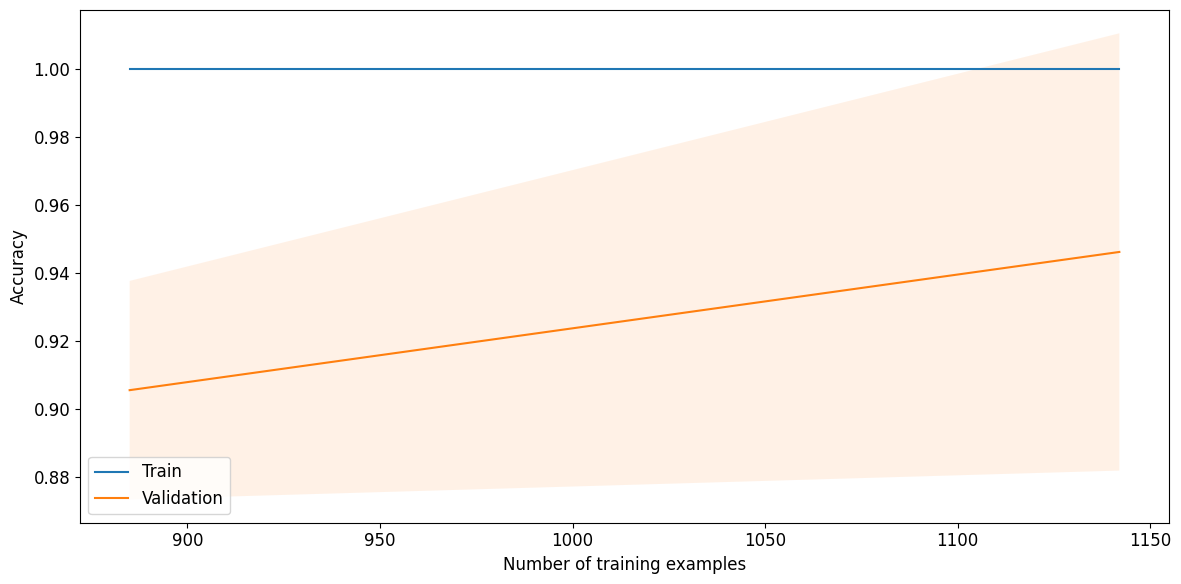

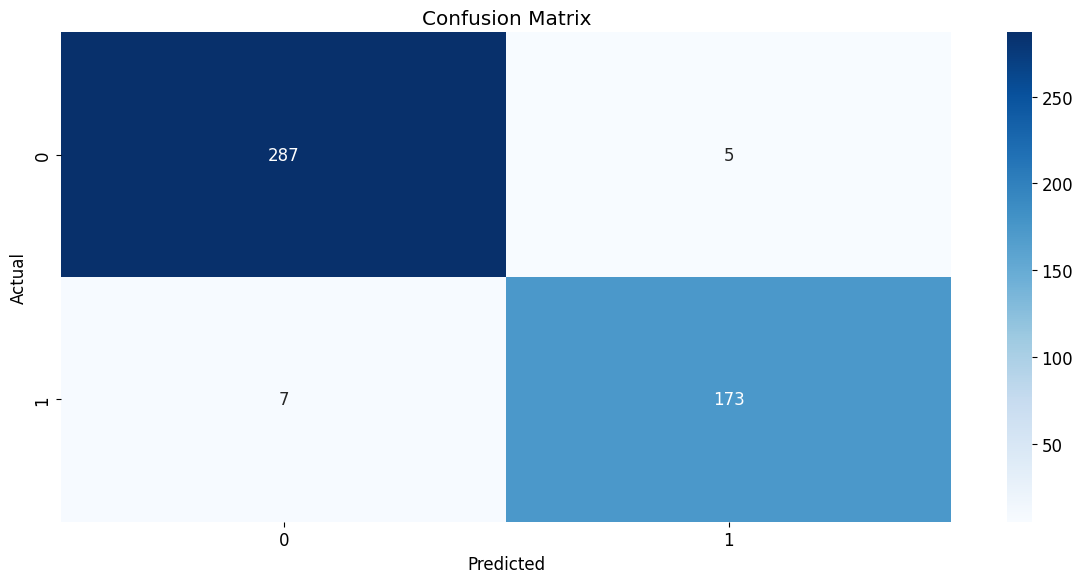

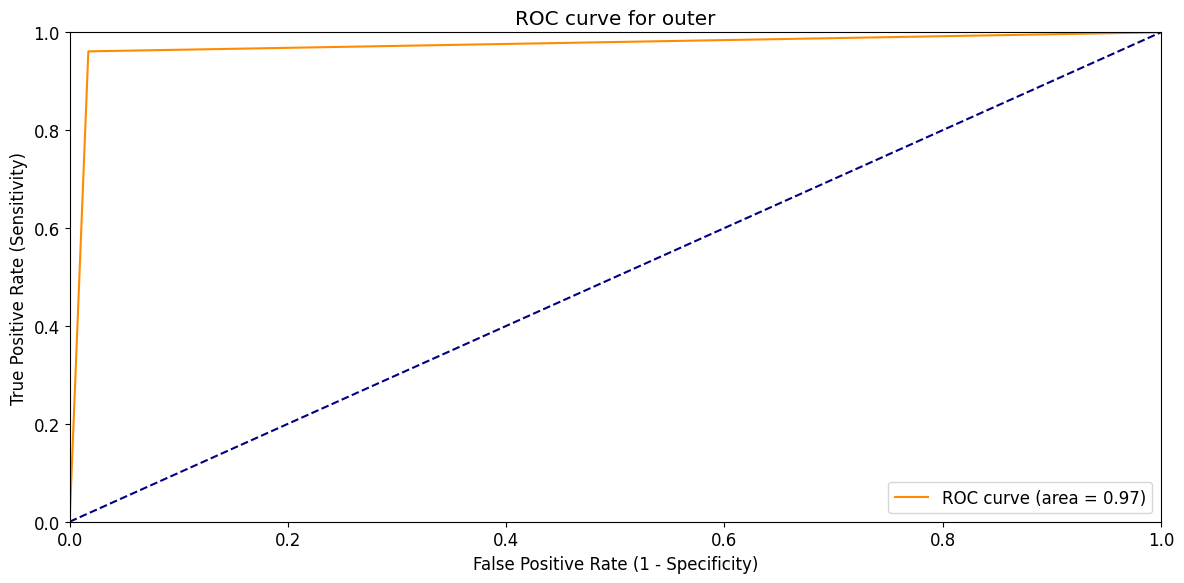

FSCOR 0 :  0.9795221843003412
RECALL 0 :  0.9828767123287672
PRECISION 0 :  0.9761904761904762
FSCOR 1 :  0.9664804469273743
RECALL 1 :  0.9611111111111111
PRECISION 1 :  0.9719101123595506
Test set metrics:
Accuracy: 0.9745762711864406
Precision: 0.9719101123595506
Recall: 0.9611111111111111
F1 score: 0.9664804469273743
Specificity: 0.9828767123287672
sensitivity: 0.9611111111111111
AUC: 0.9719939117199393
Train set metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Specificity: 1.0
sensitivity: 1.0
AUC: 1.0
Overfitting check (between the test and train sets should be less than 5%):
Accuracy difference: 0.025423728813559365
Precision difference: 0.028089887640449396
Recall difference: 0.03888888888888886
F1 score difference: 0.03351955307262566
Specificity difference: 0.017123287671232834
Sensitivity difference: 0.03888888888888886
AUC difference: 0.02800608828006068


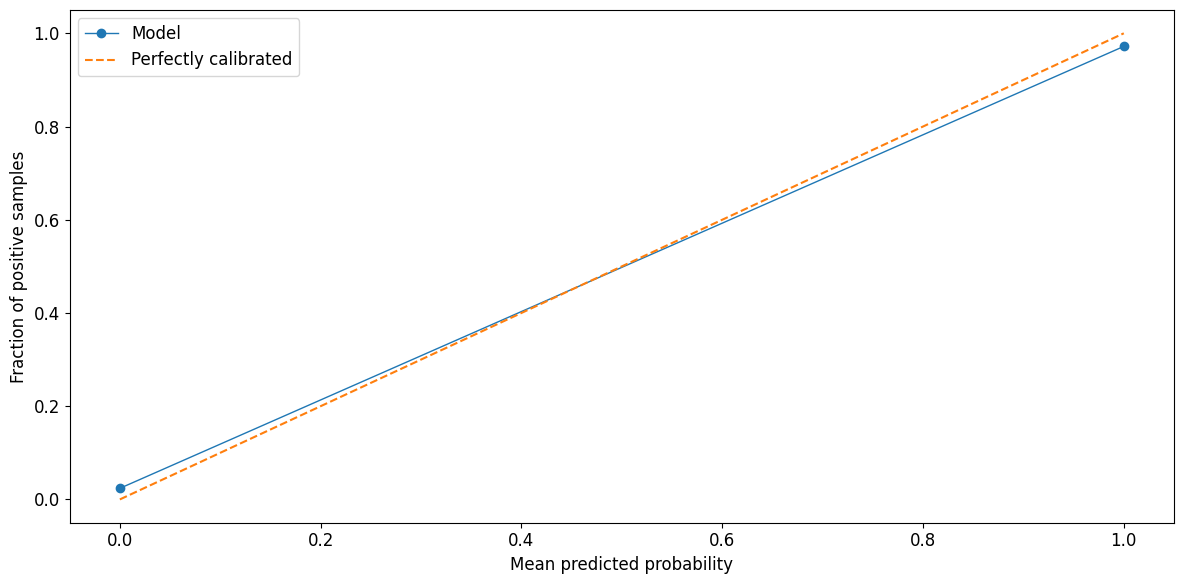

<Figure size 1200x600 with 0 Axes>

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


# Define the base models
models = [
    ('rf', RandomForestClassifier(random_state=42, max_depth=5,min_samples_leaf=5,n_estimators=100)),
    #('gb', GradientBoostingClassifier(random_state=42, max_depth=5)),
      ('xgb', XGBClassifier(random_state=42, max_depth=5,n_estimators=100)),
      ('ADA',AdaBoostClassifier(algorithm= 'SAMME',learning_rate= 0.1,n_estimators=100))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=42)

# Define the stacking model
stacking_model = make_pipeline(
    StandardScaler(),
    StackingClassifier(
        estimators=models,
        final_estimator=meta_model,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        stack_method='predict_proba',
    )
)
#---------------------------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(df_Xarray,df_Yarray,test_size=0.33, random_state=42,shuffle=True)
#stacking_scores = cross_val_score(stacking_model, X_train, y_train, cv=5)
#----------------------------------------------------------------------------------------------------------------
# Load the dataset
X, y = df_Xarray, df_Yarray

# Define the outer cross-validation loop
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define the inner cross-validation loop
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics to evaluate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

# Evaluate the stacking model using nested cross-validation
stacking_scores = cross_validate(stacking_model, X, y, cv=outer_cv, scoring=scoring)

# Print the results
print('Stacking model:')
for metric in scoring:
    scores = stacking_scores[f'test_{metric}']
    print(f'{metric}: {scores.mean():.3f} +/- {2*scores.std():.3f}')

# Evaluate the base models using cross-validation (train)
base_scores = []
for name, model in models:
    base_scores = cross_validate(model, X, y, cv=outer_cv, scoring=scoring)
    print(name)
    for metric in scoring:
        scores = base_scores[f'test_{metric}']
        print(f'{metric}: {scores.mean():.3f} +/- {2*scores.std():.3f}')

#------------------------------------------------------------------------------------------------------------------------------

classifier = stacking_model
classifier.fit(X_train, y_train)
classes = classifier.classes_
y_pred = classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Stacking model: {score.mean():.3f}')

#-----------------------------------------------------------


#-----------------------------------------------------------

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# X and y are the input features and labels, respectively
# model is the classification model to be trained
train_sizes, train_scores, test_scores = learning_curve(classifier, df_Xarray,df_Yarray, cv=5)
# Calculate mean and standard deviation of train and test scores across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(address+"auc_learning_curve_smote_stacking.png", dpi=300, bbox_inches="tight")

plt.rcParams["figure.figsize"] = [12.00, 6] ## سن امتحان حذف درس اخلاق
plt.rcParams["figure.autolayout"] = True
fpr, tpr, _ = roc_curve(y_test, y_pred)
from sklearn import metrics
AUC=metrics.auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(address+"confusion_smote_stacking.png", dpi=300, bbox_inches="tight")


plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for outer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()
plt.savefig(address+"auc__smote_stacking.png", dpi=300, bbox_inches="tight")

Accuracy = accuracy_score(y_test, y_pred) * 100
FSCORE=f1_score(y_test, y_pred, average=None)
RECALL=recall_score(y_test, y_pred, average=None)
PRECISION=precision_score(y_test, y_pred, average=None)
for i in range(len(classes)):
      print("FSCOR", classes[i], ": ",FSCORE[i])
      print("RECALL", classes[i], ": ",RECALL[i])
      print("PRECISION", classes[i], ": ",PRECISION[i])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# True labels and predicted labels for test set
y_true_train = y_train
y_pred_train = classifier.predict(X_train)
    # True labels and predicted labels for train set
y_true_test = y_test
y_pred_test = classifier.predict(X_test)# predicted labels for train set
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_score_test = f1_score(y_true_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test, y_pred_test).ravel()
specificity_test = tn_test / (tn_test + fp_test)
sensitivity_test = tp_test / (tp_test + fn_test)
auc_test = roc_auc_score(y_true_test, y_pred_test)
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for train set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_score_train = f1_score(y_true_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_true_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train)
sensitivity_train = tp_train / (tp_train + fn_train)
auc_train = roc_auc_score(y_true_train, y_pred_train)
# Print the evaluation metrics
print("Test set metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_score_test)
print("Specificity:", specificity_test)
print("sensitivity:", sensitivity_test)
print("AUC:", auc_test)

print("Train set metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 score:", f1_score_train)
print("Specificity:", specificity_train)
print("sensitivity:", sensitivity_train)
print("AUC:", auc_train)

# Check for overfitting by comparing metrics of test and train sets
#One common rule of thumb is that the difference in performance metrics between the test and train sets should be less than 5%.
print("Overfitting check (between the test and train sets should be less than 5%):")
print("Accuracy difference:", np.abs(accuracy_test - accuracy_train))
print("Precision difference:", np.abs(precision_test - precision_train))
print("Recall difference:", np.abs(recall_test - recall_train))
print("F1 score difference:", np.abs(f1_score_test - f1_score_train))
print("Specificity difference:", np.abs(specificity_test - specificity_train))
print("Sensitivity difference:", abs(sensitivity_test - sensitivity_train))
print("AUC difference:", np.abs(auc_test - auc_train))

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# y_true is the true labels for the test set, and y_probs is the predicted probabilities
y_true = y_test# true labels for test set
y_probs = y_pred # predicted probabilities for test set
# Calculate calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_probs, n_bins=10)
# Plot calibration curve
plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive samples')
plt.legend()
plt.show()
plt.savefig(address+"calibration curve_smote_stacking.png", dpi=300, bbox_inches="tight")




In [ ]:
import pickle

# Train your model
# ...

# Save your trained model to a file
with open(address+"final_model.pkl", 'wb') as f:
    pickle.dump(classifier, f)

In [ ]:
print (result.columns)
df_Xarray2=result.iloc[:,:-1].values
df_Yarray2=result.iloc[:,-1].values
y_pred_test = classifier.predict(df_Xarray2)
print(y_pred_test)
y_pred_test = y_pred_test.reshape(-1, 1)
cols_except_last = result.iloc[:, :-1].columns.tolist()


Index(['Gender_Male', 'Residency Status_Resident', 'Entrance Semester_Spring',
       'Type of Admission_Tuition Paying', 'General Surgery_A',
       'General Surgery_A+', 'General Surgery_B', 'General Surgery_C',
       'General Surgery_D', 'Pediatrics_A',
       ...
       'GPA in clinical clerkship_A', 'GPA in clinical clerkship_A+',
       'GPA in clinical clerkship_B', 'Age at Entrance_20',
       'Age at Entrance_Above 20', 'Age at Entrance_Below 20',
       'Age at CMPIE_25', 'Age at CMPIE_Above 25', 'Age at CMPIE_Below 25',
       'x0_PASS'],
      dtype='object', length=107)
[1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1

In [ ]:
# Predict on the test data

data_3=pd.DataFrame(df_Xarray2,columns=cols_except_last)
y_pred_test=pd.DataFrame(data=y_pred_test,columns=["predicted_CMPIE_status"])
cca_status=pd.DataFrame(data=data,columns=["CCA Status"])
cca_status=cca_status.replace({'PASS': 1, 'FAIL': 0})
result2 = pd.concat([data_3, y_pred_test,cca_status], axis=1)
result2 = result2.dropna(subset=["CCA Status"])
result2["CCA Status"]=result2["CCA Status"].astype(int)
print(result2)
result2.to_csv(address+'outcome_based_model_input.csv', index=False)



     Gender_Male  Residency Status_Resident  Entrance Semester_Spring  \
0            0.0                        0.0                       1.0   
2            0.0                        0.0                       0.0   
3            0.0                        0.0                       0.0   
5            0.0                        1.0                       1.0   
11           0.0                        0.0                       1.0   
..           ...                        ...                       ...   
904          0.0                        1.0                       1.0   
907          1.0                        1.0                       0.0   
915          1.0                        0.0                       0.0   
934          0.0                        1.0                       0.0   
940          1.0                        1.0                       1.0   

     Type of Admission_Tuition Paying  General Surgery_A  General Surgery_A+  \
0                                 0.0      

In [ ]:
null_counts = result2.isnull().sum()

# print the number of null values in each column
print(null_counts)

Gender_Male                         0
Residency Status_Resident           0
Entrance Semester_Spring            0
Type of Admission_Tuition Paying    0
General Surgery_A                   0
                                   ..
Age at CMPIE_25                     0
Age at CMPIE_Above 25               0
Age at CMPIE_Below 25               0
predicted_CMPIE_status              0
CCA Status                          0
Length: 108, dtype: int64


In [ ]:
result2= pd.read_csv(address+'outcome_based_model_input.csv')
df_Xarray3=result2.iloc[:,:-1].values
df_Yarray3=result2.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(df_Xarray3,df_Yarray3,test_size=0.33, random_state=42,shuffle=True)
print(X_train.shape)
print(result2.shape)
result2.columns


(520, 107)
(777, 108)


Index(['Gender_Male', 'Residency Status_Resident', 'Entrance Semester_Spring',
       'Type of Admission_Tuition Paying', 'General Surgery_A',
       'General Surgery_A+', 'General Surgery_B', 'General Surgery_C',
       'General Surgery_D', 'Pediatrics_A',
       ...
       'GPA in clinical clerkship_A+', 'GPA in clinical clerkship_B',
       'Age at Entrance_20', 'Age at Entrance_Above 20',
       'Age at Entrance_Below 20', 'Age at CMPIE_25', 'Age at CMPIE_Above 25',
       'Age at CMPIE_Below 25', 'predicted_CMPIE_status', 'CCA Status'],
      dtype='object', length=108)



counter_aresamble :   0    741
1    719
Name: target, dtype: int64


<ipython-input-77-2575922e940d>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_names, rotation=90, fontsize=12)


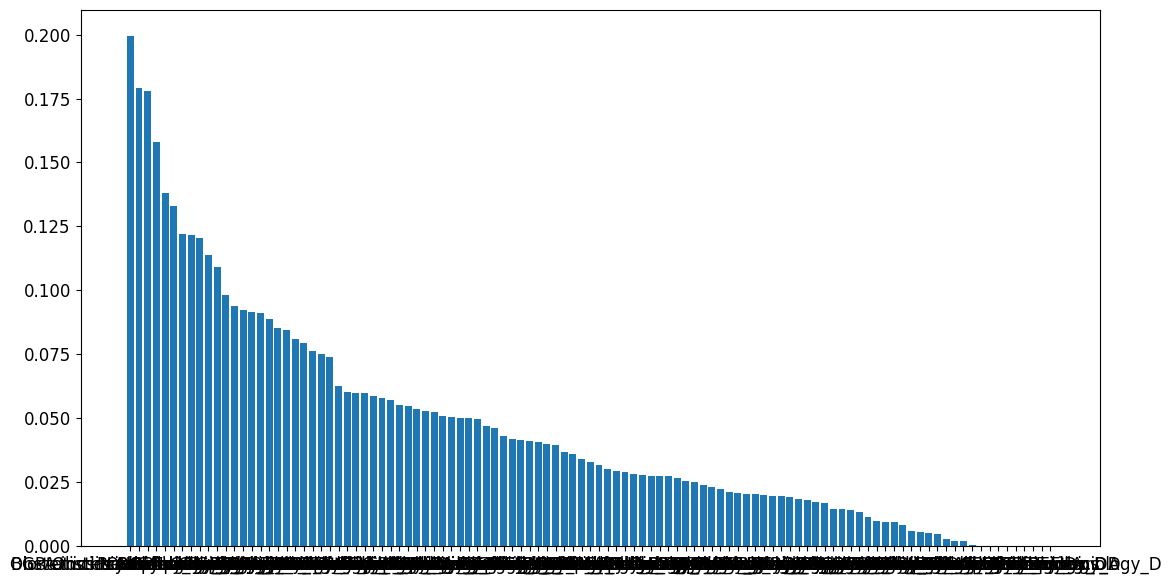

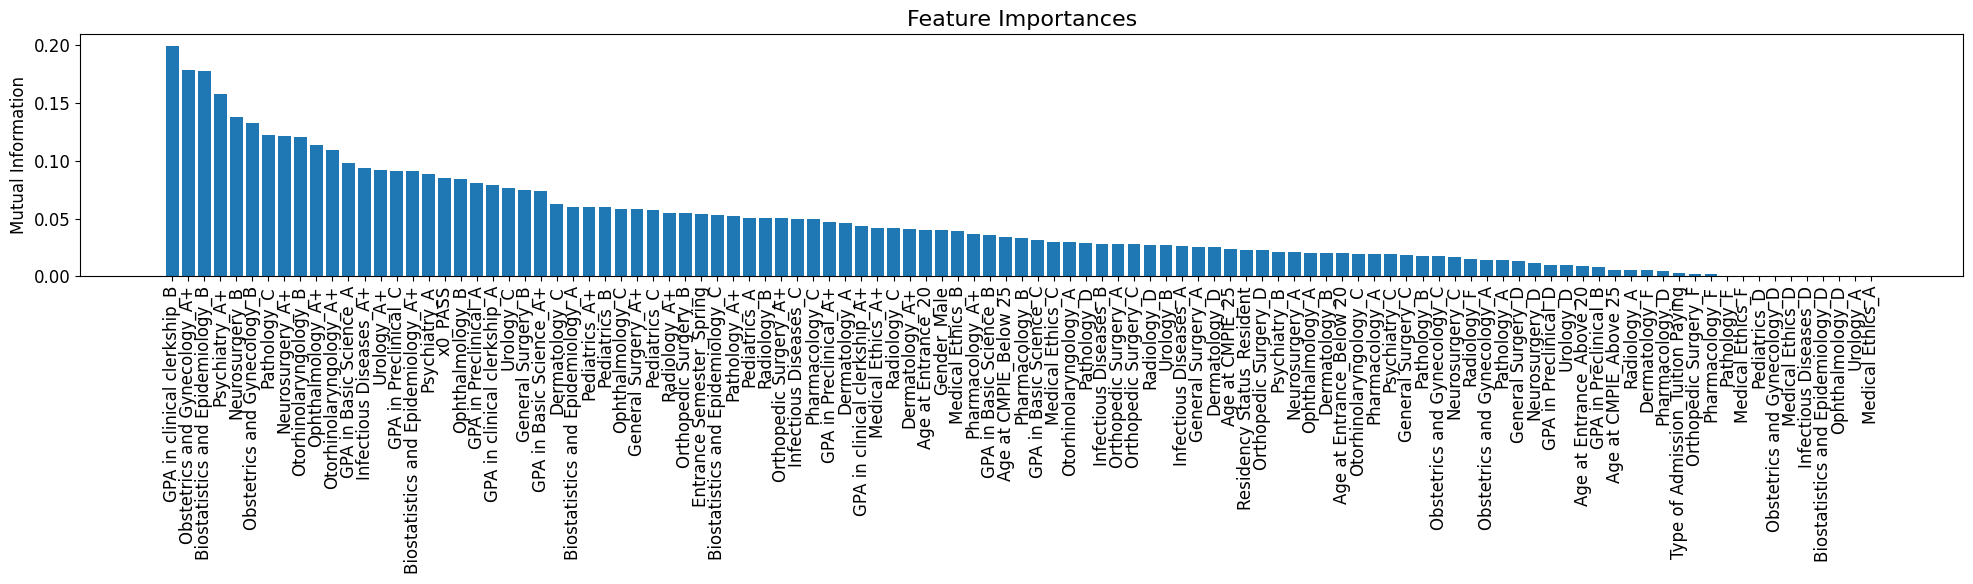

Percentage of 0s: 50.62240663900415
Percentage of 1s: 49.37759336099585


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


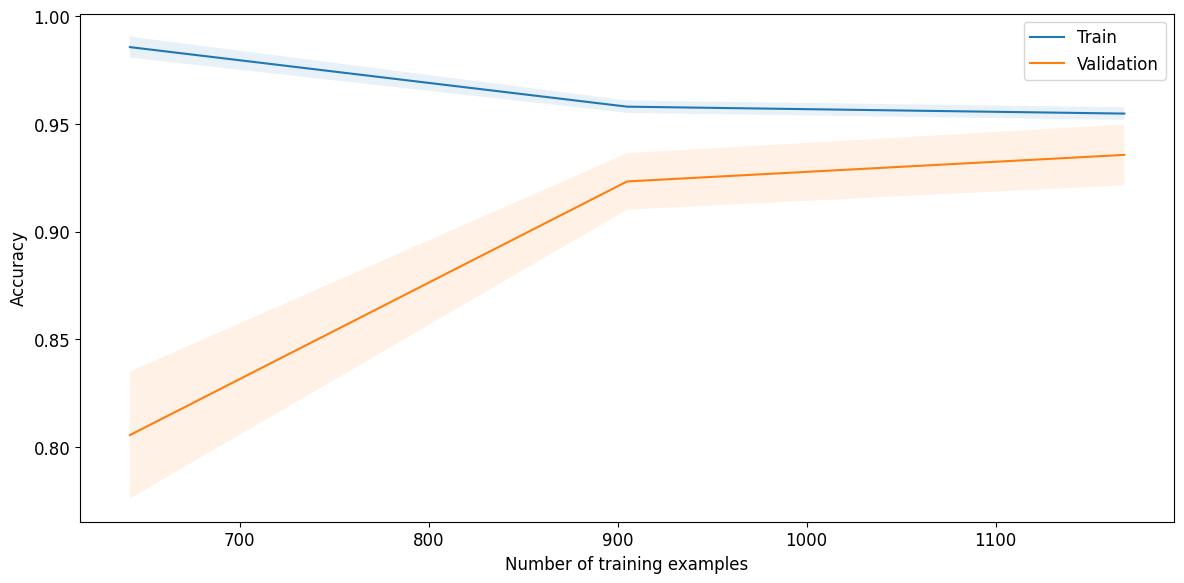

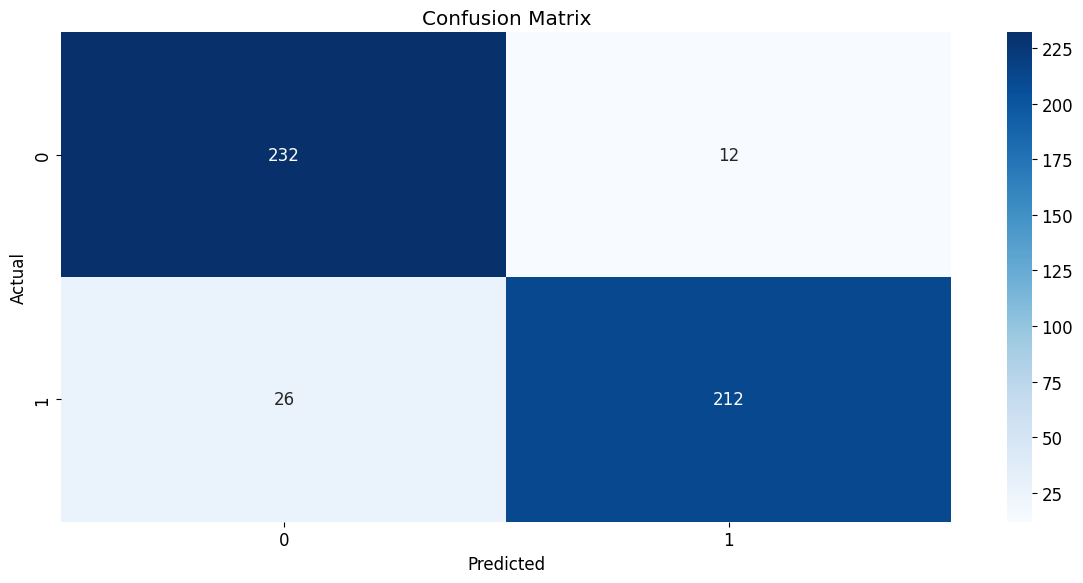

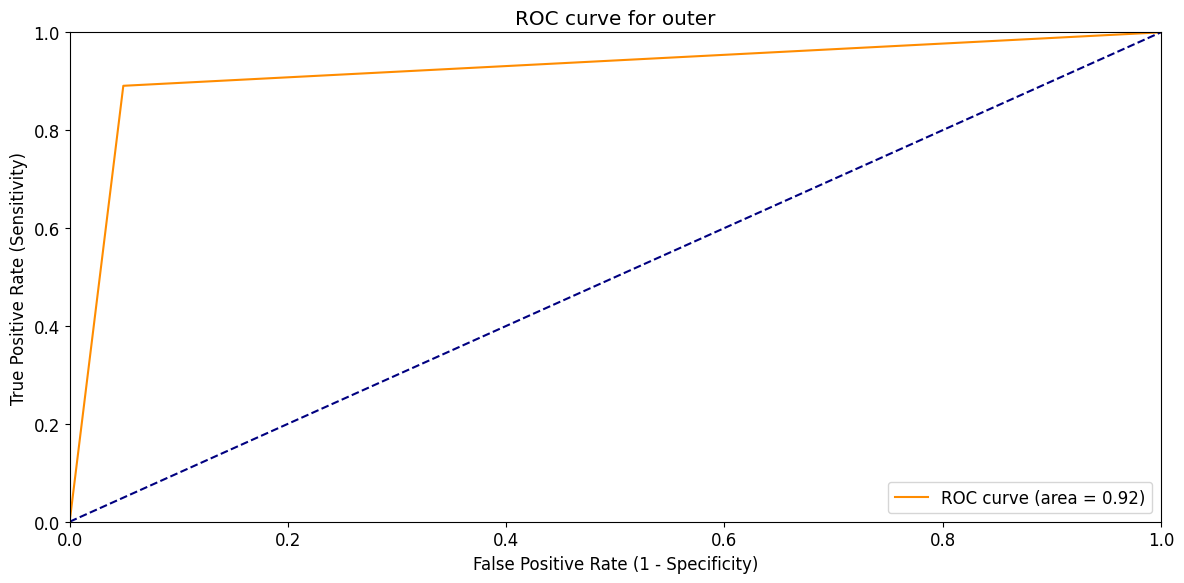

FSCOR 0 :  0.9243027888446215
RECALL 0 :  0.9508196721311475
PRECISION 0 :  0.8992248062015504
FSCOR 1 :  0.9177489177489176
RECALL 1 :  0.8907563025210085
PRECISION 1 :  0.9464285714285714
Test set metrics:
Accuracy: 0.921161825726141
Precision: 0.9464285714285714
Recall: 0.8907563025210085
F1 score: 0.9177489177489176
Specificity: 0.9508196721311475
sensitivity: 0.8907563025210085
AUC: 0.9207879873260779
Train set metrics:
Accuracy: 0.9621676891615542
Precision: 0.9723404255319149
Recall: 0.9501039501039501
F1 score: 0.9610935856992638
Specificity: 0.9738430583501007
sensitivity: 0.9501039501039501
AUC: 0.9619735042270254
Overfitting check (between the test and train sets should be less than 5%):
Accuracy difference: 0.041005863435413126
Precision difference: 0.025911854103343512
Recall difference: 0.05934764758294164
F1 score difference: 0.043344667950346194
Specificity difference: 0.023023386218953168
Sensitivity difference: 0.05934764758294164
AUC difference: 0.041185516900947516


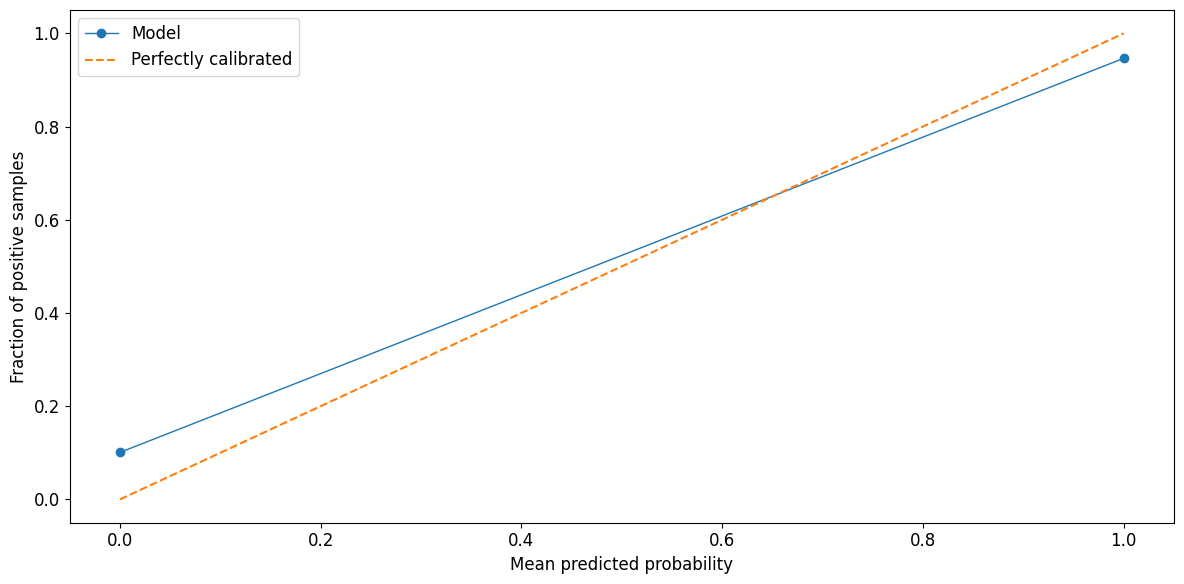

<Figure size 1200x600 with 0 Axes>

In [ ]:
#from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTEN
#from imblearn.over_sampling import KMeansSMOTE
#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.combine import SMOTETomek
#from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,auc,roc_curve,RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTEENN
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

resamble = SMOTEENN(random_state=0)
X_r,Y_r=resamble.fit_resample(df_Xarray3,df_Yarray3)
c1=result.columns[:]
df_os=pd.DataFrame(X_r,columns=c1)
df_os["target"]=Y_r
counter_Aresamble = df_os.iloc[:,-1].value_counts()
print("\n")
print("counter_aresamble :  ",counter_Aresamble)
df_Xarray3=df_os.iloc[:,:-1].values
df_Yarray3=df_os.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(df_Xarray3,df_Yarray3,test_size=0.33, random_state=42,shuffle=True)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
classes = classifier.classes_
y_pred = classifier.predict(X_test)


# Compute the mutual information between each feature and the target variable
mi = mutual_info_classif(X_train, y_train)
# Sort the feature importances in descending order
sorted_idx = np.argsort(mi)[::-1]
sorted_names = c1[sorted_idx]
sorted_mi = mi[sorted_idx]
# Create a bar chart of the sorted feature importances
fig, ax = plt.subplots()
ax.bar(sorted_names, sorted_mi)
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(sorted_names, sorted_mi)
ax.set_xticklabels(sorted_names, rotation=90, fontsize=12)
ax.set_ylabel('Mutual Information', fontsize=12)
ax.set_title('Feature Importances', fontsize=16)
plt.show()
plt.savefig(address+"Feature Importances.png", dpi=300, bbox_inches="tight")

counts = np.bincount(y_test)

num_zeros = counts[0]
num_ones = counts[1]

total = len(y_test)
percent_zeros = num_zeros / total * 100
percent_ones = num_ones / total * 100

print("Percentage of 0s:", percent_zeros)
print("Percentage of 1s:", percent_ones)


from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# X and y are the input features and labels, respectively
# model is the classification model to be trained
train_sizes, train_scores, test_scores = learning_curve(classifier, df_Xarray3,df_Yarray3, cv=5)
# Calculate mean and standard deviation of train and test scores across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(address+"auc_learning_curve_smote.png", dpi=300, bbox_inches="tight")

plt.rcParams["figure.figsize"] = [12.00, 6] ## سن امتحان حذف درس اخلاق
plt.rcParams["figure.autolayout"] = True
fpr, tpr, _ = roc_curve(y_test, y_pred)
AUC=auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(address+"confusion_smote.png", dpi=300, bbox_inches="tight")



plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for outer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()
plt.savefig(address+"auc_out_smote.png", dpi=300, bbox_inches="tight")

Accuracy = accuracy_score(y_test, y_pred) * 100
FSCORE=f1_score(y_test, y_pred, average=None)
RECALL=recall_score(y_test, y_pred, average=None)
PRECISION=precision_score(y_test, y_pred, average=None)
for i in range(len(classes)):
      print("FSCOR", classes[i], ": ",FSCORE[i])
      print("RECALL", classes[i], ": ",RECALL[i])
      print("PRECISION", classes[i], ": ",PRECISION[i])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# True labels and predicted labels for test set
y_true_train = y_train
y_pred_train = classifier.predict(X_train)
    # True labels and predicted labels for train set
y_true_test = y_test
y_pred_test = classifier.predict(X_test)# predicted labels for train set
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_score_test = f1_score(y_true_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test, y_pred_test).ravel()
specificity_test = tn_test / (tn_test + fp_test)
sensitivity_test = tp_test / (tp_test + fn_test)
auc_test = roc_auc_score(y_true_test, y_pred_test)
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for train set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_score_train = f1_score(y_true_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_true_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train)
sensitivity_train = tp_train / (tp_train + fn_train)
auc_train = roc_auc_score(y_true_train, y_pred_train)
# Print the evaluation metrics
print("Test set metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_score_test)
print("Specificity:", specificity_test)
print("sensitivity:", sensitivity_test)
print("AUC:", auc_test)
print("Train set metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 score:", f1_score_train)
print("Specificity:", specificity_train)
print("sensitivity:", sensitivity_train)
print("AUC:", auc_train)

# Check for overfitting by comparing metrics of test and train sets
#One common rule of thumb is that the difference in performance metrics between the test and train sets should be less than 5%.
print("Overfitting check (between the test and train sets should be less than 5%):")
print("Accuracy difference:", np.abs(accuracy_test - accuracy_train))
print("Precision difference:", np.abs(precision_test - precision_train))
print("Recall difference:", np.abs(recall_test - recall_train))
print("F1 score difference:", np.abs(f1_score_test - f1_score_train))
print("Specificity difference:", np.abs(specificity_test - specificity_train))
print("Sensitivity difference:", abs(sensitivity_test - sensitivity_train))
print("AUC difference:", np.abs(auc_test - auc_train))

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# y_true is the true labels for the test set, and y_probs is the predicted probabilities
y_true = y_test# true labels for test set
y_probs = y_pred # predicted probabilities for test set
# Calculate calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_probs, n_bins=10)
# Plot calibration curve
plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive samples')
plt.legend()
plt.show()
plt.savefig(address+"calibration curve_stacking_smote.png", dpi=300, bbox_inches="tight")

Stacking model:
accuracy: 0.988 +/- 0.020
f1: 0.987 +/- 0.020
precision: 0.991 +/- 0.021
recall: 0.984 +/- 0.022
roc_auc: 0.999 +/- 0.002
rf
accuracy: 0.941 +/- 0.039
f1: 0.937 +/- 0.042
precision: 0.981 +/- 0.033
recall: 0.898 +/- 0.064
roc_auc: 0.991 +/- 0.011
xgb
accuracy: 0.990 +/- 0.014
f1: 0.990 +/- 0.015
precision: 0.993 +/- 0.016
recall: 0.986 +/- 0.018
roc_auc: 1.000 +/- 0.001
ADA
accuracy: 0.870 +/- 0.045
f1: 0.857 +/- 0.051
precision: 0.934 +/- 0.053
recall: 0.793 +/- 0.067
roc_auc: 0.947 +/- 0.030
Stacking model: 0.994


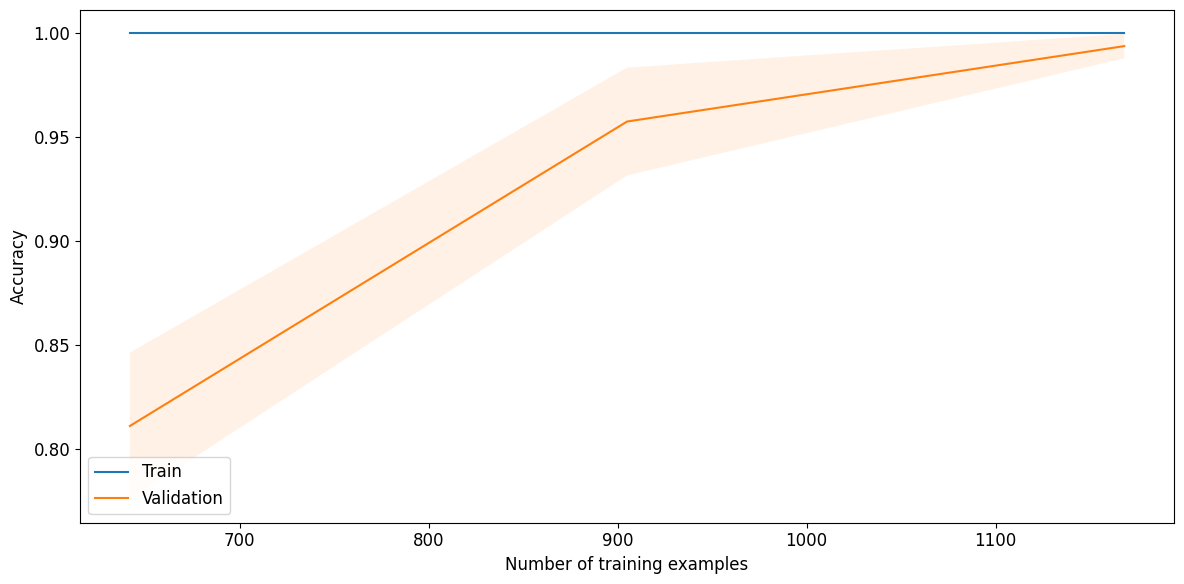

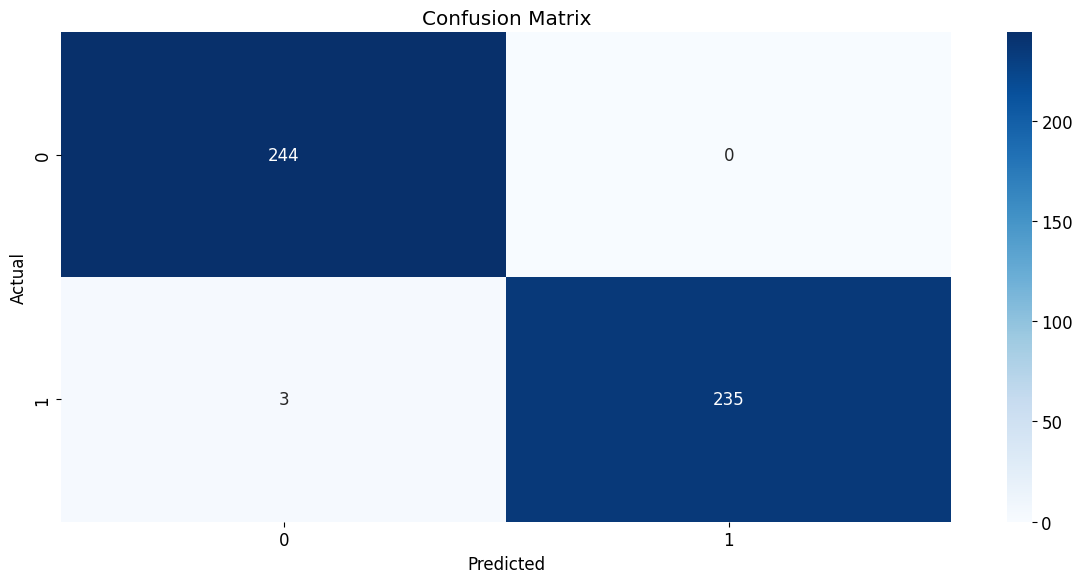

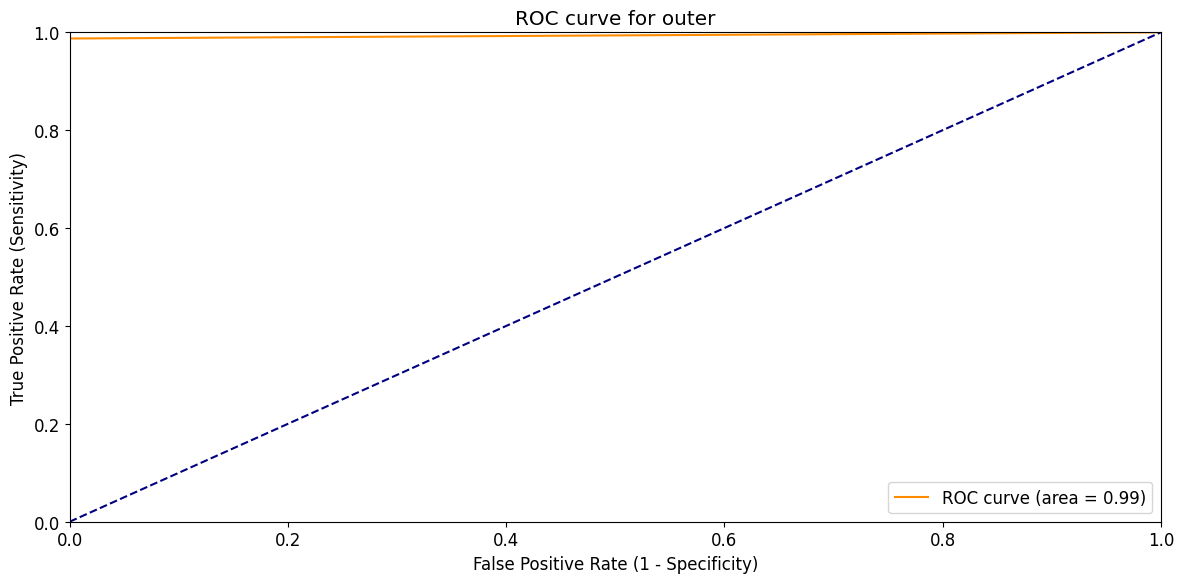

FSCOR 0 :  0.9938900203665988
RECALL 0 :  1.0
PRECISION 0 :  0.9878542510121457
FSCOR 1 :  0.9936575052854123
RECALL 1 :  0.9873949579831933
PRECISION 1 :  1.0
Test set metrics:
Accuracy: 0.9937759336099585
Precision: 1.0
Recall: 0.9873949579831933
F1 score: 0.9936575052854123
Specificity: 1.0
sensitivity: 0.9873949579831933
AUC: 0.9936974789915967
Train set metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Specificity: 1.0
sensitivity: 1.0
AUC: 1.0
Overfitting check (between the test and train sets should be less than 5%):
Accuracy difference: 0.006224066390041472
Precision difference: 0.0
Recall difference: 0.012605042016806678
F1 score difference: 0.006342494714587699
Specificity difference: 0.0
Sensitivity difference: 0.012605042016806678
AUC difference: 0.006302521008403339


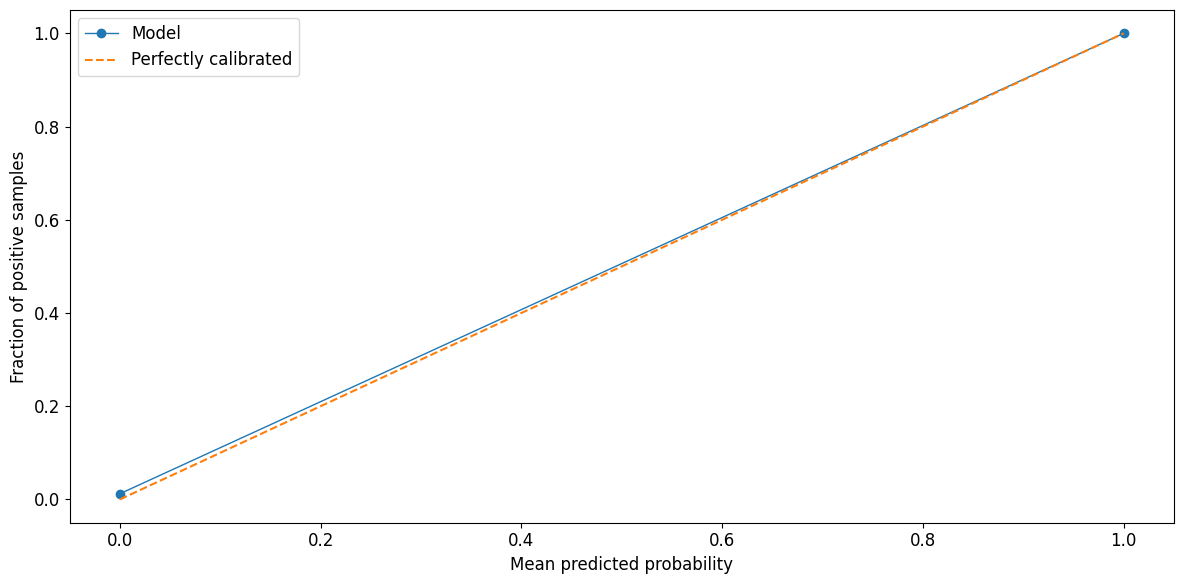

<Figure size 1200x600 with 0 Axes>

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


# Define the base models
models = [
    ('rf', RandomForestClassifier(random_state=42, max_depth=5,min_samples_leaf=5,n_estimators=100)),
    #('gb', GradientBoostingClassifier(random_state=42, max_depth=5)),
      ('xgb', XGBClassifier(random_state=42, max_depth=5,n_estimators=100)),
      ('ADA',AdaBoostClassifier(algorithm= 'SAMME',learning_rate= 0.1,n_estimators=100))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=42)

# Define the stacking model
stacking_model = make_pipeline(
    StandardScaler(),
    StackingClassifier(
        estimators=models,
        final_estimator=meta_model,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        stack_method='predict_proba',
    )
)
#---------------------------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(df_Xarray3,df_Yarray3,test_size=0.33, random_state=42,shuffle=True)
#stacking_scores = cross_val_score(stacking_model, X_train, y_train, cv=5)
#----------------------------------------------------------------------------------------------------------------
# Load the dataset
X, y = df_Xarray3, df_Yarray3

# Define the outer cross-validation loop
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define the inner cross-validation loop
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics to evaluate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

# Evaluate the stacking model using nested cross-validation
stacking_scores = cross_validate(stacking_model, X, y, cv=outer_cv, scoring=scoring)

# Print the results
print('Stacking model:')
for metric in scoring:
    scores = stacking_scores[f'test_{metric}']
    print(f'{metric}: {scores.mean():.3f} +/- {2*scores.std():.3f}')

# Evaluate the base models using cross-validation (train)
base_scores = []
for name, model in models:
    base_scores = cross_validate(model, X, y, cv=outer_cv, scoring=scoring)
    print(name)
    for metric in scoring:
        scores = base_scores[f'test_{metric}']
        print(f'{metric}: {scores.mean():.3f} +/- {2*scores.std():.3f}')

#------------------------------------------------------------------------------------------------------------------------------

classifier = stacking_model
classifier.fit(X_train, y_train)
classes = classifier.classes_
y_pred = classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Stacking model: {score.mean():.3f}')

#-----------------------------------------------------------


#-----------------------------------------------------------

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# X and y are the input features and labels, respectively
# model is the classification model to be trained
train_sizes, train_scores, test_scores = learning_curve(classifier, df_Xarray3,df_Yarray3, cv=5)
# Calculate mean and standard deviation of train and test scores across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(address+"auc_learning_curve_smote_stacking.png", dpi=300, bbox_inches="tight")

plt.rcParams["figure.figsize"] = [12.00, 6] ## سن امتحان حذف درس اخلاق
plt.rcParams["figure.autolayout"] = True
fpr, tpr, _ = roc_curve(y_test, y_pred)
from sklearn import metrics
AUC=metrics.auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(address+"confusion_smote_stacking.png", dpi=300, bbox_inches="tight")


plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for outer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()
plt.savefig(address+"auc__smote_stacking.png", dpi=300, bbox_inches="tight")

Accuracy = accuracy_score(y_test, y_pred) * 100
FSCORE=f1_score(y_test, y_pred, average=None)
RECALL=recall_score(y_test, y_pred, average=None)
PRECISION=precision_score(y_test, y_pred, average=None)
for i in range(len(classes)):
      print("FSCOR", classes[i], ": ",FSCORE[i])
      print("RECALL", classes[i], ": ",RECALL[i])
      print("PRECISION", classes[i], ": ",PRECISION[i])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# True labels and predicted labels for test set
y_true_train = y_train
y_pred_train = classifier.predict(X_train)
    # True labels and predicted labels for train set
y_true_test = y_test
y_pred_test = classifier.predict(X_test)# predicted labels for train set
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_score_test = f1_score(y_true_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test, y_pred_test).ravel()
specificity_test = tn_test / (tn_test + fp_test)
sensitivity_test = tp_test / (tp_test + fn_test)
auc_test = roc_auc_score(y_true_test, y_pred_test)
    # Calculate accuracy, precision, recall, F1 score, specificity, and AUC for train set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_score_train = f1_score(y_true_train, y_pred_train)
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_true_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train)
sensitivity_train = tp_train / (tp_train + fn_train)
auc_train = roc_auc_score(y_true_train, y_pred_train)
# Print the evaluation metrics
print("Test set metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_score_test)
print("Specificity:", specificity_test)
print("sensitivity:", sensitivity_test)
print("AUC:", auc_test)

print("Train set metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 score:", f1_score_train)
print("Specificity:", specificity_train)
print("sensitivity:", sensitivity_train)
print("AUC:", auc_train)

# Check for overfitting by comparing metrics of test and train sets
#One common rule of thumb is that the difference in performance metrics between the test and train sets should be less than 5%.
print("Overfitting check (between the test and train sets should be less than 5%):")
print("Accuracy difference:", np.abs(accuracy_test - accuracy_train))
print("Precision difference:", np.abs(precision_test - precision_train))
print("Recall difference:", np.abs(recall_test - recall_train))
print("F1 score difference:", np.abs(f1_score_test - f1_score_train))
print("Specificity difference:", np.abs(specificity_test - specificity_train))
print("Sensitivity difference:", abs(sensitivity_test - sensitivity_train))
print("AUC difference:", np.abs(auc_test - auc_train))

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# y_true is the true labels for the test set, and y_probs is the predicted probabilities
y_true = y_test# true labels for test set
y_probs = y_pred # predicted probabilities for test set
# Calculate calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_probs, n_bins=10)
# Plot calibration curve
plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positive samples')
plt.legend()
plt.show()
plt.savefig(address+"calibration curve_smote_stacking.png", dpi=300, bbox_inches="tight")




<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 940
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   CODE                            777 non-null    int64   
 1   Gender                          777 non-null    object  
 2   Residency Status                777 non-null    object  
 3   Entrance Semester               777 non-null    object  
 4   Type of Admission               777 non-null    object  
 5   Internal Medicine               777 non-null    object  
 6   General Surgery                 777 non-null    object  
 7   Pediatrics                      777 non-null    object  
 8   Obstetrics and Gynecology       777 non-null    object  
 9   Pathology                       777 non-null    object  
 10  Infectious Diseases             777 non-null    object  
 11  Neurosurgery                    777 non-null    object  
 12  Dermatology           

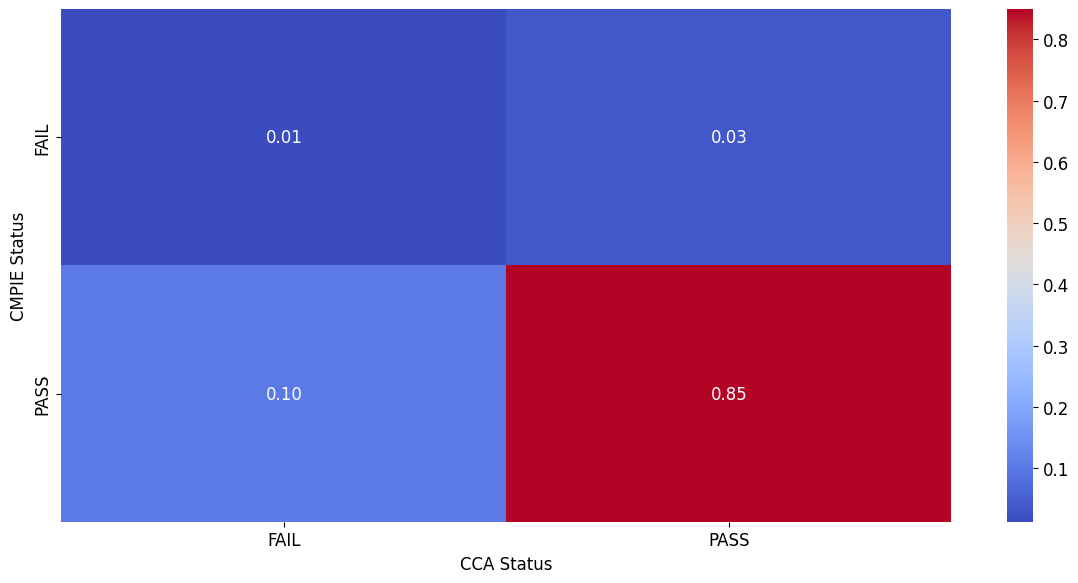

In [ ]:
# create a contingency table of columns 'A' and 'B'
data222=data
data222.dropna(subset=["CCA Status"], inplace=True)
data222.info()
cont_table = pd.crosstab(data222["CCA Status"], data222["CMPIE Status"], normalize='all')

# create a heatmap of the contingency table with formatted annotations
sns.heatmap(cont_table, annot=True,  fmt='.2f',cmap='coolwarm')



# add labels and a title to the plot
plt.xlabel('CCA Status')
plt.ylabel('CMPIE Status')

# display the plot
plt.show()